# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1-(1/24)
min_width = 50
# Ablation Finess
N_plot_finess = 10
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 20
Tied_Neurons_Q = True

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**3

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  41


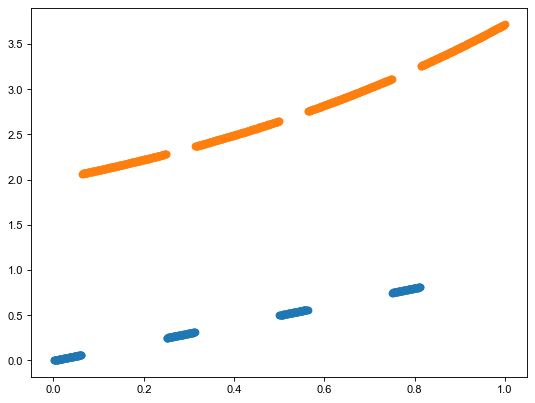

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]
sns.set()
plt.show()

### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                         y_train.reshape(-1,1),
                                                                                         N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks

---
# Perform Ablation:
---

In [ ]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
#     performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, height_mean_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])

    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))

# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = (N_neurons_per_input.reshape(-1,))[get_unique_entries]

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

Epoch 51/200
28/28 [==============================] - 0s 70us/sample - loss: 2.0196 - mse: 5.5225 - mae: 2.0196 - mape: 105.7604
Epoch 52/200
28/28 [==============================] - 0s 96us/sample - loss: 2.0194 - mse: 5.5221 - mae: 2.0194 - mape: 105.7483
Epoch 53/200
28/28 [==============================] - 0s 80us/sample - loss: 2.0193 - mse: 5.5216 - mae: 2.0193 - mape: 105.7363
Epoch 54/200
28/28 [==============================] - 0s 74us/sample - loss: 2.0192 - mse: 5.5212 - mae: 2.0192 - mape: 105.7242
Epoch 55/200
28/28 [==============================] - 0s 94us/sample - loss: 2.0191 - mse: 5.5207 - mae: 2.0191 - mape: 105.7121
Epoch 56/200
28/28 [==============================] - 0s 137us/sample - loss: 2.0190 - mse: 5.5203 - mae: 2.0190 - mape: 105.7001
Epoch 57/200
28/28 [==============================] - 0s 70us/sample - loss: 2.0189 - mse: 5.5199 - mae: 2.0189 - mape: 105.6880
Epoch 58/200
28/28 [==============================] - 0s 70us/sample - loss: 2.0188 - mse: 5.519

Epoch 115/200
28/28 [==============================] - 0s 71us/sample - loss: 2.0128 - mse: 5.4944 - mae: 2.0128 - mape: 104.9874
Epoch 116/200
28/28 [==============================] - 0s 90us/sample - loss: 2.0127 - mse: 5.4940 - mae: 2.0127 - mape: 104.9753
Epoch 117/200
28/28 [==============================] - 0s 88us/sample - loss: 2.0126 - mse: 5.4935 - mae: 2.0126 - mape: 104.9632
Epoch 118/200
28/28 [==============================] - 0s 66us/sample - loss: 2.0125 - mse: 5.4931 - mae: 2.0125 - mape: 104.9511
Epoch 119/200
28/28 [==============================] - 0s 69us/sample - loss: 2.0124 - mse: 5.4926 - mae: 2.0124 - mape: 104.9390
Epoch 120/200
28/28 [==============================] - 0s 84us/sample - loss: 2.0123 - mse: 5.4922 - mae: 2.0123 - mape: 104.9269
Epoch 121/200
28/28 [==============================] - 0s 83us/sample - loss: 2.0122 - mse: 5.4918 - mae: 2.0122 - mape: 104.9148
Epoch 122/200
28/28 [==============================] - 0s 73us/sample - loss: 2.0121 - mse

Epoch 178/200
28/28 [==============================] - 0s 89us/sample - loss: 2.0062 - mse: 5.4667 - mae: 2.0062 - mape: 104.2235
Epoch 179/200
28/28 [==============================] - 0s 100us/sample - loss: 2.0061 - mse: 5.4663 - mae: 2.0061 - mape: 104.2114
Epoch 180/200
28/28 [==============================] - 0s 62us/sample - loss: 2.0059 - mse: 5.4658 - mae: 2.0059 - mape: 104.1992
Epoch 181/200
28/28 [==============================] - 0s 71us/sample - loss: 2.0058 - mse: 5.4654 - mae: 2.0058 - mape: 104.1871
Epoch 182/200
28/28 [==============================] - 0s 111us/sample - loss: 2.0057 - mse: 5.4650 - mae: 2.0057 - mape: 104.1749
Epoch 183/200
28/28 [==============================] - 0s 60us/sample - loss: 2.0056 - mse: 5.4645 - mae: 2.0056 - mape: 104.1627
Epoch 184/200
28/28 [==============================] - 0s 68us/sample - loss: 2.0055 - mse: 5.4641 - mae: 2.0055 - mape: 104.1506
Epoch 185/200
28/28 [==============================] - 0s 73us/sample - loss: 2.0054 - m

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
15/15 [==============================] - 0s 16ms/sample - loss: 1.5488 - mse: 3.4496 - mae: 1.5488 - mape: 101.9357
Epoch 2/200
15/15 [==============================] - 0s 104us/sample - loss: 1.5488 - mse: 3.4494 - mae: 1.5488 - mape: 101.9291
Epoch 3/200
15/15 [==============================] - 0s 100us/sample - loss: 1.5487 - mse: 3.4493 - mae: 1.5487 - mape: 101.9225
Epoch 4/200
15/15 [==============================] - 0s 92us/sample - loss: 1.5487 - mse: 3.4492 - mae: 1.5487 - mape: 101.9159
Epoch 5/200
15/15 [==============================] - 0s 111us/sample - loss: 1.5487 - mse: 3.4491 - mae: 1.5487 - mape: 101.9094
Epoch 6/200
15/15 [==============================] - 0s 95us/sample - loss: 1.5486 - mse: 3.4489 - mae: 1.5486 - mape: 101.9028
Epoch 7/200
15/15 [==============================] - 0s 105us/sample - loss: 1.5486 - mse: 3.4488 - mae: 1.5486 - mape: 101.8962
Epoch 8/200
15/15 [==============================] - 0s 106us/sample - loss: 1.5485 - mse: 3.4487 - 

Epoch 65/200
15/15 [==============================] - 0s 98us/sample - loss: 1.5463 - mse: 3.4416 - mae: 1.5463 - mape: 101.5149
Epoch 66/200
15/15 [==============================] - 0s 101us/sample - loss: 1.5462 - mse: 3.4415 - mae: 1.5462 - mape: 101.5084
Epoch 67/200
15/15 [==============================] - 0s 145us/sample - loss: 1.5462 - mse: 3.4414 - mae: 1.5462 - mape: 101.5018
Epoch 68/200
15/15 [==============================] - 0s 107us/sample - loss: 1.5462 - mse: 3.4413 - mae: 1.5462 - mape: 101.4952
Epoch 69/200
15/15 [==============================] - 0s 96us/sample - loss: 1.5461 - mse: 3.4411 - mae: 1.5461 - mape: 101.4886
Epoch 70/200
15/15 [==============================] - 0s 82us/sample - loss: 1.5461 - mse: 3.4410 - mae: 1.5461 - mape: 101.4820
Epoch 71/200
15/15 [==============================] - 0s 79us/sample - loss: 1.5460 - mse: 3.4409 - mae: 1.5460 - mape: 101.4755
Epoch 72/200
15/15 [==============================] - 0s 84us/sample - loss: 1.5460 - mse: 3.4

Epoch 128/200
15/15 [==============================] - 0s 137us/sample - loss: 1.5438 - mse: 3.4338 - mae: 1.5438 - mape: 101.1000
Epoch 129/200
15/15 [==============================] - 0s 115us/sample - loss: 1.5437 - mse: 3.4337 - mae: 1.5437 - mape: 101.0934
Epoch 130/200
15/15 [==============================] - 0s 212us/sample - loss: 1.5437 - mse: 3.4336 - mae: 1.5437 - mape: 101.0868
Epoch 131/200
15/15 [==============================] - 0s 129us/sample - loss: 1.5436 - mse: 3.4335 - mae: 1.5436 - mape: 101.0802
Epoch 132/200
15/15 [==============================] - 0s 120us/sample - loss: 1.5436 - mse: 3.4333 - mae: 1.5436 - mape: 101.0736
Epoch 133/200
15/15 [==============================] - 0s 177us/sample - loss: 1.5436 - mse: 3.4332 - mae: 1.5436 - mape: 101.0670
Epoch 134/200
15/15 [==============================] - 0s 94us/sample - loss: 1.5435 - mse: 3.4331 - mae: 1.5435 - mape: 101.0604
Epoch 135/200
15/15 [==============================] - 0s 90us/sample - loss: 1.5435

Epoch 191/200
15/15 [==============================] - 0s 102us/sample - loss: 1.5412 - mse: 3.4260 - mae: 1.5412 - mape: 100.6834
Epoch 192/200
15/15 [==============================] - 0s 112us/sample - loss: 1.5412 - mse: 3.4259 - mae: 1.5412 - mape: 100.6768
Epoch 193/200
15/15 [==============================] - 0s 95us/sample - loss: 1.5412 - mse: 3.4258 - mae: 1.5412 - mape: 100.6702
Epoch 194/200
15/15 [==============================] - 0s 119us/sample - loss: 1.5411 - mse: 3.4257 - mae: 1.5411 - mape: 100.6635
Epoch 195/200
15/15 [==============================] - 0s 97us/sample - loss: 1.5411 - mse: 3.4255 - mae: 1.5411 - mape: 100.6569
Epoch 196/200
15/15 [==============================] - 0s 111us/sample - loss: 1.5410 - mse: 3.4254 - mae: 1.5410 - mape: 100.6503
Epoch 197/200
15/15 [==============================] - 0s 107us/sample - loss: 1.5410 - mse: 3.4253 - mae: 1.5410 - mape: 100.6437
Epoch 198/200
15/15 [==============================] - 0s 142us/sample - loss: 1.5410

Epoch 53/200
18/18 [==============================] - 0s 86us/sample - loss: 2.4551 - mse: 7.0647 - mae: 2.4551 - mape: 103.9626
Epoch 54/200
18/18 [==============================] - 0s 97us/sample - loss: 2.4551 - mse: 7.0645 - mae: 2.4551 - mape: 103.9597
Epoch 55/200
18/18 [==============================] - 0s 86us/sample - loss: 2.4550 - mse: 7.0642 - mae: 2.4550 - mape: 103.9568
Epoch 56/200
18/18 [==============================] - 0s 98us/sample - loss: 2.4550 - mse: 7.0640 - mae: 2.4550 - mape: 103.9539
Epoch 57/200
18/18 [==============================] - 0s 111us/sample - loss: 2.4549 - mse: 7.0638 - mae: 2.4549 - mape: 103.9510
Epoch 58/200
18/18 [==============================] - 0s 93us/sample - loss: 2.4549 - mse: 7.0636 - mae: 2.4549 - mape: 103.9481
Epoch 59/200
18/18 [==============================] - 0s 90us/sample - loss: 2.4549 - mse: 7.0633 - mae: 2.4549 - mape: 103.9451
Epoch 60/200
18/18 [==============================] - 0s 90us/sample - loss: 2.4548 - mse: 7.063

Epoch 117/200
18/18 [==============================] - 0s 98us/sample - loss: 2.4522 - mse: 7.0499 - mae: 2.4522 - mape: 103.7758
Epoch 118/200
18/18 [==============================] - 0s 83us/sample - loss: 2.4521 - mse: 7.0497 - mae: 2.4521 - mape: 103.7729
Epoch 119/200
18/18 [==============================] - 0s 90us/sample - loss: 2.4521 - mse: 7.0495 - mae: 2.4521 - mape: 103.7700
Epoch 120/200
18/18 [==============================] - 0s 104us/sample - loss: 2.4520 - mse: 7.0492 - mae: 2.4520 - mape: 103.7671
Epoch 121/200
18/18 [==============================] - 0s 93us/sample - loss: 2.4520 - mse: 7.0490 - mae: 2.4520 - mape: 103.7641
Epoch 122/200
18/18 [==============================] - 0s 98us/sample - loss: 2.4519 - mse: 7.0488 - mae: 2.4519 - mape: 103.7612
Epoch 123/200
18/18 [==============================] - 0s 129us/sample - loss: 2.4519 - mse: 7.0485 - mae: 2.4519 - mape: 103.7583
Epoch 124/200
18/18 [==============================] - 0s 84us/sample - loss: 2.4518 - m

Epoch 180/200
18/18 [==============================] - 0s 85us/sample - loss: 2.4492 - mse: 7.0354 - mae: 2.4492 - mape: 103.5913
Epoch 181/200
18/18 [==============================] - 0s 81us/sample - loss: 2.4492 - mse: 7.0351 - mae: 2.4492 - mape: 103.5883
Epoch 182/200
18/18 [==============================] - 0s 82us/sample - loss: 2.4491 - mse: 7.0349 - mae: 2.4491 - mape: 103.5854
Epoch 183/200
18/18 [==============================] - 0s 104us/sample - loss: 2.4491 - mse: 7.0347 - mae: 2.4491 - mape: 103.5825
Epoch 184/200
18/18 [==============================] - 0s 103us/sample - loss: 2.4490 - mse: 7.0344 - mae: 2.4490 - mape: 103.5795
Epoch 185/200
18/18 [==============================] - 0s 82us/sample - loss: 2.4490 - mse: 7.0342 - mae: 2.4490 - mape: 103.5766
Epoch 186/200
18/18 [==============================] - 0s 89us/sample - loss: 2.4490 - mse: 7.0340 - mae: 2.4490 - mape: 103.5737
Epoch 187/200
18/18 [==============================] - 0s 106us/sample - loss: 2.4489 - 

Epoch 43/200
8/8 [==============================] - 0s 187us/sample - loss: 1.3428 - mse: 2.8048 - mae: 1.3428 - mape: 125.7395
Epoch 44/200
8/8 [==============================] - 0s 156us/sample - loss: 1.3427 - mse: 2.8047 - mae: 1.3427 - mape: 125.6866
Epoch 45/200
8/8 [==============================] - 0s 182us/sample - loss: 1.3427 - mse: 2.8046 - mae: 1.3427 - mape: 125.6338
Epoch 46/200
8/8 [==============================] - 0s 151us/sample - loss: 1.3426 - mse: 2.8045 - mae: 1.3426 - mape: 125.5810
Epoch 47/200
8/8 [==============================] - 0s 176us/sample - loss: 1.3426 - mse: 2.8044 - mae: 1.3426 - mape: 125.5282
Epoch 48/200
8/8 [==============================] - 0s 186us/sample - loss: 1.3426 - mse: 2.8043 - mae: 1.3426 - mape: 125.4754
Epoch 49/200
8/8 [==============================] - 0s 157us/sample - loss: 1.3425 - mse: 2.8042 - mae: 1.3425 - mape: 125.4225
Epoch 50/200
8/8 [==============================] - 0s 168us/sample - loss: 1.3425 - mse: 2.8041 - mae: 

Epoch 107/200
8/8 [==============================] - 0s 191us/sample - loss: 1.3404 - mse: 2.7984 - mae: 1.3404 - mape: 122.3566
Epoch 108/200
8/8 [==============================] - 0s 193us/sample - loss: 1.3404 - mse: 2.7983 - mae: 1.3404 - mape: 122.3037
Epoch 109/200
8/8 [==============================] - 0s 179us/sample - loss: 1.3403 - mse: 2.7982 - mae: 1.3403 - mape: 122.2508
Epoch 110/200
8/8 [==============================] - 0s 222us/sample - loss: 1.3403 - mse: 2.7981 - mae: 1.3403 - mape: 122.1979
Epoch 111/200
8/8 [==============================] - 0s 224us/sample - loss: 1.3402 - mse: 2.7980 - mae: 1.3402 - mape: 122.1450
Epoch 112/200
8/8 [==============================] - 0s 177us/sample - loss: 1.3402 - mse: 2.7979 - mae: 1.3402 - mape: 122.0920
Epoch 113/200
8/8 [==============================] - 0s 138us/sample - loss: 1.3402 - mse: 2.7978 - mae: 1.3402 - mape: 122.0391
Epoch 114/200
8/8 [==============================] - 0s 179us/sample - loss: 1.3401 - mse: 2.7977

Epoch 171/200
8/8 [==============================] - 0s 204us/sample - loss: 1.3380 - mse: 2.7921 - mae: 1.3380 - mape: 118.9646
Epoch 172/200
8/8 [==============================] - 0s 198us/sample - loss: 1.3380 - mse: 2.7920 - mae: 1.3380 - mape: 118.9115
Epoch 173/200
8/8 [==============================] - 0s 223us/sample - loss: 1.3380 - mse: 2.7919 - mae: 1.3380 - mape: 118.8584
Epoch 174/200
8/8 [==============================] - 0s 176us/sample - loss: 1.3379 - mse: 2.7918 - mae: 1.3379 - mape: 118.8052
Epoch 175/200
8/8 [==============================] - 0s 175us/sample - loss: 1.3379 - mse: 2.7917 - mae: 1.3379 - mape: 118.7521
Epoch 176/200
8/8 [==============================] - 0s 245us/sample - loss: 1.3379 - mse: 2.7916 - mae: 1.3379 - mape: 118.6990
Epoch 177/200
8/8 [==============================] - 0s 179us/sample - loss: 1.3378 - mse: 2.7915 - mae: 1.3378 - mape: 118.6459
Epoch 178/200
8/8 [==============================] - 0s 182us/sample - loss: 1.3378 - mse: 2.7914

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
6/6 [==============================] - 0s 47ms/sample - loss: 0.2911 - mse: 0.0850 - mae: 0.2911 - mape: 102.0642
Epoch 2/200
6/6 [==============================] - 0s 199us/sample - loss: 0.2911 - mse: 0.0850 - mae: 0.2911 - mape: 102.0536
Epoch 3/200
6/6 [==============================] - 0s 285us/sample - loss: 0.2910 - mse: 0.0849 - mae: 0.2910 - mape: 102.0429
Epoch 4/200
6/6 [==============================] - 0s 251us/sample - loss: 0.2910 - mse: 0.0849 - mae: 0.2910 - mape: 102.0323
Epoch 5/200
6/6 [==============================] - 0s 223us/sample - loss: 0.2910 - mse: 0.0849 - mae: 0.2910 - mape: 102.0216
Epoch 6/200
6/6 [==============================] - 0s 237us/sample - loss: 0.2909 - mse: 0.0849 - mae: 0.2909 - mape: 102.0110
Epoch 7/200
6/6 [==============================] - 0s 362us/sample - loss: 0.2909 - mse: 0.0849 - mae: 0.2909 - mape: 102.0003
Epoch 8/200
6/6 [==============================] - 0s 259us/sample - loss: 0.2909 - mse: 0.0849 - mae: 0.2909 - 

6/6 [==============================] - 0s 287us/sample - loss: 0.2892 - mse: 0.0839 - mae: 0.2892 - mape: 101.3822
Epoch 66/200
6/6 [==============================] - 0s 517us/sample - loss: 0.2891 - mse: 0.0838 - mae: 0.2891 - mape: 101.3715
Epoch 67/200
6/6 [==============================] - 0s 272us/sample - loss: 0.2891 - mse: 0.0838 - mae: 0.2891 - mape: 101.3608
Epoch 68/200
6/6 [==============================] - 0s 359us/sample - loss: 0.2891 - mse: 0.0838 - mae: 0.2891 - mape: 101.3502
Epoch 69/200
6/6 [==============================] - 0s 271us/sample - loss: 0.2890 - mse: 0.0838 - mae: 0.2890 - mape: 101.3395
Epoch 70/200
6/6 [==============================] - 0s 349us/sample - loss: 0.2890 - mse: 0.0838 - mae: 0.2890 - mape: 101.3289
Epoch 71/200
6/6 [==============================] - 0s 287us/sample - loss: 0.2890 - mse: 0.0837 - mae: 0.2890 - mape: 101.3182
Epoch 72/200
6/6 [==============================] - 0s 257us/sample - loss: 0.2889 - mse: 0.0837 - mae: 0.2889 - mape

Epoch 129/200
6/6 [==============================] - 0s 268us/sample - loss: 0.2872 - mse: 0.0827 - mae: 0.2872 - mape: 100.6992
Epoch 130/200
6/6 [==============================] - 0s 240us/sample - loss: 0.2872 - mse: 0.0827 - mae: 0.2872 - mape: 100.6885
Epoch 131/200
6/6 [==============================] - 0s 254us/sample - loss: 0.2872 - mse: 0.0827 - mae: 0.2872 - mape: 100.6778
Epoch 132/200
6/6 [==============================] - 0s 280us/sample - loss: 0.2871 - mse: 0.0827 - mae: 0.2871 - mape: 100.6671
Epoch 133/200
6/6 [==============================] - 0s 377us/sample - loss: 0.2871 - mse: 0.0827 - mae: 0.2871 - mape: 100.6565
Epoch 134/200
6/6 [==============================] - 0s 226us/sample - loss: 0.2871 - mse: 0.0826 - mae: 0.2871 - mape: 100.6458
Epoch 135/200
6/6 [==============================] - 0s 245us/sample - loss: 0.2870 - mse: 0.0826 - mae: 0.2870 - mape: 100.6351
Epoch 136/200
6/6 [==============================] - 0s 231us/sample - loss: 0.2870 - mse: 0.0826

Epoch 193/200
6/6 [==============================] - 0s 292us/sample - loss: 0.2853 - mse: 0.0816 - mae: 0.2853 - mape: 100.0148
Epoch 194/200
6/6 [==============================] - 0s 296us/sample - loss: 0.2852 - mse: 0.0816 - mae: 0.2852 - mape: 100.0041
Epoch 195/200
6/6 [==============================] - 0s 284us/sample - loss: 0.2852 - mse: 0.0816 - mae: 0.2852 - mape: 99.9933
Epoch 196/200
6/6 [==============================] - 0s 226us/sample - loss: 0.2852 - mse: 0.0816 - mae: 0.2852 - mape: 99.9826
Epoch 197/200
6/6 [==============================] - 0s 317us/sample - loss: 0.2851 - mse: 0.0816 - mae: 0.2851 - mape: 99.9719
Epoch 198/200
6/6 [==============================] - 0s 225us/sample - loss: 0.2851 - mse: 0.0815 - mae: 0.2851 - mape: 99.9612
Epoch 199/200
6/6 [==============================] - 0s 289us/sample - loss: 0.2851 - mse: 0.0815 - mae: 0.2851 - mape: 99.9505
Epoch 200/200
6/6 [==============================] - 0s 239us/sample - loss: 0.2851 - mse: 0.0815 - ma

Epoch 56/200
9/9 [==============================] - 0s 212us/sample - loss: 2.3243 - mse: 5.7799 - mae: 2.3243 - mape: 105.9184
Epoch 57/200
9/9 [==============================] - 0s 162us/sample - loss: 2.3243 - mse: 5.7797 - mae: 2.3243 - mape: 105.9163
Epoch 58/200
9/9 [==============================] - 0s 188us/sample - loss: 2.3243 - mse: 5.7796 - mae: 2.3243 - mape: 105.9142
Epoch 59/200
9/9 [==============================] - 0s 202us/sample - loss: 2.3242 - mse: 5.7794 - mae: 2.3242 - mape: 105.9121
Epoch 60/200
9/9 [==============================] - 0s 230us/sample - loss: 2.3242 - mse: 5.7793 - mae: 2.3242 - mape: 105.9100
Epoch 61/200
9/9 [==============================] - 0s 167us/sample - loss: 2.3242 - mse: 5.7791 - mae: 2.3242 - mape: 105.9079
Epoch 62/200
9/9 [==============================] - 0s 186us/sample - loss: 2.3241 - mse: 5.7789 - mae: 2.3241 - mape: 105.9058
Epoch 63/200
9/9 [==============================] - 0s 191us/sample - loss: 2.3241 - mse: 5.7788 - mae: 

Epoch 120/200
9/9 [==============================] - 0s 185us/sample - loss: 2.3221 - mse: 5.7695 - mae: 2.3221 - mape: 105.7847
Epoch 121/200
9/9 [==============================] - 0s 161us/sample - loss: 2.3220 - mse: 5.7693 - mae: 2.3220 - mape: 105.7826
Epoch 122/200
9/9 [==============================] - 0s 169us/sample - loss: 2.3220 - mse: 5.7692 - mae: 2.3220 - mape: 105.7805
Epoch 123/200
9/9 [==============================] - 0s 134us/sample - loss: 2.3220 - mse: 5.7690 - mae: 2.3220 - mape: 105.7784
Epoch 124/200
9/9 [==============================] - 0s 165us/sample - loss: 2.3219 - mse: 5.7689 - mae: 2.3219 - mape: 105.7763
Epoch 125/200
9/9 [==============================] - 0s 121us/sample - loss: 2.3219 - mse: 5.7687 - mae: 2.3219 - mape: 105.7742
Epoch 126/200
9/9 [==============================] - 0s 165us/sample - loss: 2.3219 - mse: 5.7685 - mae: 2.3219 - mape: 105.7721
Epoch 127/200
9/9 [==============================] - 0s 180us/sample - loss: 2.3218 - mse: 5.7684

Epoch 184/200
9/9 [==============================] - 0s 416us/sample - loss: 2.3198 - mse: 5.7591 - mae: 2.3198 - mape: 105.6506
Epoch 185/200
9/9 [==============================] - 0s 313us/sample - loss: 2.3198 - mse: 5.7589 - mae: 2.3198 - mape: 105.6485
Epoch 186/200
9/9 [==============================] - 0s 328us/sample - loss: 2.3198 - mse: 5.7588 - mae: 2.3198 - mape: 105.6464
Epoch 187/200
9/9 [==============================] - 0s 212us/sample - loss: 2.3197 - mse: 5.7586 - mae: 2.3197 - mape: 105.6443
Epoch 188/200
9/9 [==============================] - 0s 195us/sample - loss: 2.3197 - mse: 5.7584 - mae: 2.3197 - mape: 105.6422
Epoch 189/200
9/9 [==============================] - 0s 259us/sample - loss: 2.3197 - mse: 5.7583 - mae: 2.3197 - mape: 105.6401
Epoch 190/200
9/9 [==============================] - 0s 205us/sample - loss: 2.3196 - mse: 5.7581 - mae: 2.3196 - mape: 105.6380
Epoch 191/200
9/9 [==============================] - 0s 171us/sample - loss: 2.3196 - mse: 5.7579

Epoch 47/200
4/4 [==============================] - 0s 303us/sample - loss: 3.5078 - mse: 12.3144 - mae: 3.5078 - mape: 102.3435
Epoch 48/200
4/4 [==============================] - 0s 380us/sample - loss: 3.5077 - mse: 12.3140 - mae: 3.5077 - mape: 102.3421
Epoch 49/200
4/4 [==============================] - 0s 403us/sample - loss: 3.5077 - mse: 12.3137 - mae: 3.5077 - mape: 102.3407
Epoch 50/200
4/4 [==============================] - 0s 415us/sample - loss: 3.5076 - mse: 12.3134 - mae: 3.5076 - mape: 102.3394
Epoch 51/200
4/4 [==============================] - 0s 363us/sample - loss: 3.5076 - mse: 12.3131 - mae: 3.5076 - mape: 102.3380
Epoch 52/200
4/4 [==============================] - 0s 293us/sample - loss: 3.5075 - mse: 12.3127 - mae: 3.5075 - mape: 102.3367
Epoch 53/200
4/4 [==============================] - 0s 526us/sample - loss: 3.5075 - mse: 12.3124 - mae: 3.5075 - mape: 102.3353
Epoch 54/200
4/4 [==============================] - 0s 576us/sample - loss: 3.5075 - mse: 12.3121

Epoch 111/200
4/4 [==============================] - 0s 288us/sample - loss: 3.5048 - mse: 12.2935 - mae: 3.5048 - mape: 102.2565
Epoch 112/200
4/4 [==============================] - 0s 360us/sample - loss: 3.5048 - mse: 12.2931 - mae: 3.5048 - mape: 102.2552
Epoch 113/200
4/4 [==============================] - 0s 431us/sample - loss: 3.5047 - mse: 12.2928 - mae: 3.5047 - mape: 102.2538
Epoch 114/200
4/4 [==============================] - 0s 469us/sample - loss: 3.5047 - mse: 12.2925 - mae: 3.5047 - mape: 102.2525
Epoch 115/200
4/4 [==============================] - 0s 352us/sample - loss: 3.5046 - mse: 12.2922 - mae: 3.5046 - mape: 102.2511
Epoch 116/200
4/4 [==============================] - 0s 381us/sample - loss: 3.5046 - mse: 12.2918 - mae: 3.5046 - mape: 102.2498
Epoch 117/200
4/4 [==============================] - 0s 602us/sample - loss: 3.5045 - mse: 12.2915 - mae: 3.5045 - mape: 102.2484
Epoch 118/200
4/4 [==============================] - 0s 358us/sample - loss: 3.5045 - mse:

Epoch 175/200
4/4 [==============================] - 0s 392us/sample - loss: 3.5018 - mse: 12.2726 - mae: 3.5018 - mape: 102.1695
Epoch 176/200
4/4 [==============================] - 0s 446us/sample - loss: 3.5018 - mse: 12.2723 - mae: 3.5018 - mape: 102.1682
Epoch 177/200
4/4 [==============================] - 0s 334us/sample - loss: 3.5017 - mse: 12.2719 - mae: 3.5017 - mape: 102.1668
Epoch 178/200
4/4 [==============================] - 0s 386us/sample - loss: 3.5017 - mse: 12.2716 - mae: 3.5017 - mape: 102.1655
Epoch 179/200
4/4 [==============================] - 0s 373us/sample - loss: 3.5016 - mse: 12.2713 - mae: 3.5016 - mape: 102.1641
Epoch 180/200
4/4 [==============================] - 0s 596us/sample - loss: 3.5016 - mse: 12.2709 - mae: 3.5016 - mape: 102.1627
Epoch 181/200
4/4 [==============================] - 0s 378us/sample - loss: 3.5015 - mse: 12.2706 - mae: 3.5015 - mape: 102.1614
Epoch 182/200
4/4 [==============================] - 0s 359us/sample - loss: 3.5015 - mse:

Epoch 38/200
9/9 [==============================] - 0s 263us/sample - loss: 2.1788 - mse: 5.8867 - mae: 2.1788 - mape: 99.1956
Epoch 39/200
9/9 [==============================] - 0s 549us/sample - loss: 2.1788 - mse: 5.8865 - mae: 2.1788 - mape: 99.1927
Epoch 40/200
9/9 [==============================] - 0s 213us/sample - loss: 2.1787 - mse: 5.8864 - mae: 2.1787 - mape: 99.1897
Epoch 41/200
9/9 [==============================] - 0s 170us/sample - loss: 2.1787 - mse: 5.8862 - mae: 2.1787 - mape: 99.1868
Epoch 42/200
9/9 [==============================] - 0s 198us/sample - loss: 2.1786 - mse: 5.8860 - mae: 2.1786 - mape: 99.1839
Epoch 43/200
9/9 [==============================] - 0s 236us/sample - loss: 2.1786 - mse: 5.8858 - mae: 2.1786 - mape: 99.1810
Epoch 44/200
9/9 [==============================] - 0s 211us/sample - loss: 2.1786 - mse: 5.8857 - mae: 2.1786 - mape: 99.1780
Epoch 45/200
9/9 [==============================] - 0s 327us/sample - loss: 2.1785 - mse: 5.8855 - mae: 2.1785 

Epoch 103/200
9/9 [==============================] - 0s 315us/sample - loss: 2.1762 - mse: 5.8753 - mae: 2.1762 - mape: 99.0056
Epoch 104/200
9/9 [==============================] - 0s 160us/sample - loss: 2.1761 - mse: 5.8751 - mae: 2.1761 - mape: 99.0026
Epoch 105/200
9/9 [==============================] - 0s 136us/sample - loss: 2.1761 - mse: 5.8749 - mae: 2.1761 - mape: 98.9997
Epoch 106/200
9/9 [==============================] - 0s 159us/sample - loss: 2.1761 - mse: 5.8748 - mae: 2.1761 - mape: 98.9968
Epoch 107/200
9/9 [==============================] - 0s 213us/sample - loss: 2.1760 - mse: 5.8746 - mae: 2.1760 - mape: 98.9939
Epoch 108/200
9/9 [==============================] - 0s 192us/sample - loss: 2.1760 - mse: 5.8744 - mae: 2.1760 - mape: 98.9909
Epoch 109/200
9/9 [==============================] - 0s 175us/sample - loss: 2.1759 - mse: 5.8742 - mae: 2.1759 - mape: 98.9880
Epoch 110/200
9/9 [==============================] - 0s 146us/sample - loss: 2.1759 - mse: 5.8741 - mae:

Epoch 168/200
9/9 [==============================] - 0s 182us/sample - loss: 2.1735 - mse: 5.8639 - mae: 2.1735 - mape: 98.8150
Epoch 169/200
9/9 [==============================] - 0s 191us/sample - loss: 2.1735 - mse: 5.8637 - mae: 2.1735 - mape: 98.8121
Epoch 170/200
9/9 [==============================] - 0s 157us/sample - loss: 2.1735 - mse: 5.8635 - mae: 2.1735 - mape: 98.8092
Epoch 171/200
9/9 [==============================] - 0s 183us/sample - loss: 2.1734 - mse: 5.8633 - mae: 2.1734 - mape: 98.8062
Epoch 172/200
9/9 [==============================] - 0s 202us/sample - loss: 2.1734 - mse: 5.8632 - mae: 2.1734 - mape: 98.8033
Epoch 173/200
9/9 [==============================] - 0s 175us/sample - loss: 2.1733 - mse: 5.8630 - mae: 2.1733 - mape: 98.8004
Epoch 174/200
9/9 [==============================] - 0s 160us/sample - loss: 2.1733 - mse: 5.8628 - mae: 2.1733 - mape: 98.7974
Epoch 175/200
9/9 [==============================] - 0s 160us/sample - loss: 2.1733 - mse: 5.8626 - mae:

Epoch 31/200
9/9 [==============================] - 0s 157us/sample - loss: 2.0799 - mse: 4.3287 - mae: 2.0799 - mape: 96.3569
Epoch 32/200
9/9 [==============================] - 0s 163us/sample - loss: 2.0798 - mse: 4.3286 - mae: 2.0798 - mape: 96.3555
Epoch 33/200
9/9 [==============================] - 0s 204us/sample - loss: 2.0798 - mse: 4.3285 - mae: 2.0798 - mape: 96.3540
Epoch 34/200
9/9 [==============================] - 0s 190us/sample - loss: 2.0798 - mse: 4.3284 - mae: 2.0798 - mape: 96.3526
Epoch 35/200
9/9 [==============================] - 0s 153us/sample - loss: 2.0797 - mse: 4.3282 - mae: 2.0797 - mape: 96.3512
Epoch 36/200
9/9 [==============================] - 0s 144us/sample - loss: 2.0797 - mse: 4.3281 - mae: 2.0797 - mape: 96.3498
Epoch 37/200
9/9 [==============================] - 0s 147us/sample - loss: 2.0797 - mse: 4.3280 - mae: 2.0797 - mape: 96.3484
Epoch 38/200
9/9 [==============================] - 0s 145us/sample - loss: 2.0797 - mse: 4.3278 - mae: 2.0797 

Epoch 96/200
9/9 [==============================] - 0s 165us/sample - loss: 2.0779 - mse: 4.3204 - mae: 2.0779 - mape: 96.2644
Epoch 97/200
9/9 [==============================] - 0s 146us/sample - loss: 2.0778 - mse: 4.3203 - mae: 2.0778 - mape: 96.2630
Epoch 98/200
9/9 [==============================] - 0s 154us/sample - loss: 2.0778 - mse: 4.3202 - mae: 2.0778 - mape: 96.2616
Epoch 99/200
9/9 [==============================] - 0s 145us/sample - loss: 2.0778 - mse: 4.3201 - mae: 2.0778 - mape: 96.2602
Epoch 100/200
9/9 [==============================] - 0s 192us/sample - loss: 2.0778 - mse: 4.3199 - mae: 2.0778 - mape: 96.2587
Epoch 101/200
9/9 [==============================] - 0s 169us/sample - loss: 2.0777 - mse: 4.3198 - mae: 2.0777 - mape: 96.2573
Epoch 102/200
9/9 [==============================] - 0s 141us/sample - loss: 2.0777 - mse: 4.3197 - mae: 2.0777 - mape: 96.2559
Epoch 103/200
9/9 [==============================] - 0s 148us/sample - loss: 2.0777 - mse: 4.3195 - mae: 2.0

9/9 [==============================] - 0s 163us/sample - loss: 2.0759 - mse: 4.3123 - mae: 2.0759 - mape: 96.1731
Epoch 161/200
9/9 [==============================] - 0s 188us/sample - loss: 2.0759 - mse: 4.3121 - mae: 2.0759 - mape: 96.1717
Epoch 162/200
9/9 [==============================] - 0s 151us/sample - loss: 2.0758 - mse: 4.3120 - mae: 2.0758 - mape: 96.1703
Epoch 163/200
9/9 [==============================] - 0s 168us/sample - loss: 2.0758 - mse: 4.3119 - mae: 2.0758 - mape: 96.1689
Epoch 164/200
9/9 [==============================] - 0s 190us/sample - loss: 2.0758 - mse: 4.3117 - mae: 2.0758 - mape: 96.1674
Epoch 165/200
9/9 [==============================] - 0s 177us/sample - loss: 2.0757 - mse: 4.3116 - mae: 2.0757 - mape: 96.1660
Epoch 166/200
9/9 [==============================] - 0s 150us/sample - loss: 2.0757 - mse: 4.3115 - mae: 2.0757 - mape: 96.1646
Epoch 167/200
9/9 [==============================] - 0s 222us/sample - loss: 2.0757 - mse: 4.3114 - mae: 2.0757 - mape

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
6/6 [==============================] - 0s 48ms/sample - loss: 2.0351 - mse: 5.2120 - mae: 2.0351 - mape: 105.2386
Epoch 2/200
6/6 [==============================] - 0s 222us/sample - loss: 2.0351 - mse: 5.2119 - mae: 2.0351 - mape: 105.2355
Epoch 3/200
6/6 [==============================] - 0s 216us/sample - loss: 2.0351 - mse: 5.2118 - mae: 2.0351 - mape: 105.2324
Epoch 4/200
6/6 [==============================] - 0s 188us/sample - loss: 2.0350 - mse: 5.2116 - mae: 2.0350 - mape: 105.2293
Epoch 5/200
6/6 [==============================] - 0s 253us/sample - loss: 2.0350 - mse: 5.2115 - mae: 2.0350 - mape: 105.2262
Epoch 6/200
6/6 [==============================] - 0s 232us/sample - loss: 2.0350 - mse: 5.2113 - mae: 2.0350 - mape: 105.2232
Epoch 7/200
6/6 [==============================] - 0s 200us/sample - loss: 2.0349 - mse: 5.2112 - mae: 2.0349 - mape: 105.2201
Epoch 8/200
6/6 [==============================] - 0s 373us/sample - loss: 2.0349 - mse: 5.2110 - mae: 2.0349 - 

6/6 [==============================] - 0s 319us/sample - loss: 2.0329 - mse: 5.2030 - mae: 2.0329 - mape: 105.0409
Epoch 66/200
6/6 [==============================] - 0s 238us/sample - loss: 2.0329 - mse: 5.2028 - mae: 2.0329 - mape: 105.0378
Epoch 67/200
6/6 [==============================] - 0s 263us/sample - loss: 2.0328 - mse: 5.2027 - mae: 2.0328 - mape: 105.0347
Epoch 68/200
6/6 [==============================] - 0s 194us/sample - loss: 2.0328 - mse: 5.2025 - mae: 2.0328 - mape: 105.0316
Epoch 69/200
6/6 [==============================] - 0s 295us/sample - loss: 2.0328 - mse: 5.2024 - mae: 2.0328 - mape: 105.0285
Epoch 70/200
6/6 [==============================] - 0s 240us/sample - loss: 2.0327 - mse: 5.2022 - mae: 2.0327 - mape: 105.0254
Epoch 71/200
6/6 [==============================] - 0s 203us/sample - loss: 2.0327 - mse: 5.2021 - mae: 2.0327 - mape: 105.0223
Epoch 72/200
6/6 [==============================] - 0s 245us/sample - loss: 2.0327 - mse: 5.2020 - mae: 2.0327 - mape

Epoch 129/200
6/6 [==============================] - 0s 263us/sample - loss: 2.0307 - mse: 5.1938 - mae: 2.0307 - mape: 104.8421
Epoch 130/200
6/6 [==============================] - 0s 218us/sample - loss: 2.0306 - mse: 5.1937 - mae: 2.0306 - mape: 104.8390
Epoch 131/200
6/6 [==============================] - 0s 341us/sample - loss: 2.0306 - mse: 5.1935 - mae: 2.0306 - mape: 104.8358
Epoch 132/200
6/6 [==============================] - 0s 244us/sample - loss: 2.0306 - mse: 5.1934 - mae: 2.0306 - mape: 104.8327
Epoch 133/200
6/6 [==============================] - 0s 265us/sample - loss: 2.0305 - mse: 5.1933 - mae: 2.0305 - mape: 104.8296
Epoch 134/200
6/6 [==============================] - 0s 218us/sample - loss: 2.0305 - mse: 5.1931 - mae: 2.0305 - mape: 104.8265
Epoch 135/200
6/6 [==============================] - 0s 284us/sample - loss: 2.0305 - mse: 5.1930 - mae: 2.0305 - mape: 104.8234
Epoch 136/200
6/6 [==============================] - 0s 262us/sample - loss: 2.0304 - mse: 5.1928

Epoch 193/200
6/6 [==============================] - 0s 286us/sample - loss: 2.0284 - mse: 5.1846 - mae: 2.0284 - mape: 104.6417
Epoch 194/200
6/6 [==============================] - 0s 229us/sample - loss: 2.0284 - mse: 5.1845 - mae: 2.0284 - mape: 104.6385
Epoch 195/200
6/6 [==============================] - 0s 212us/sample - loss: 2.0283 - mse: 5.1844 - mae: 2.0283 - mape: 104.6354
Epoch 196/200
6/6 [==============================] - 0s 221us/sample - loss: 2.0283 - mse: 5.1842 - mae: 2.0283 - mape: 104.6323
Epoch 197/200
6/6 [==============================] - 0s 266us/sample - loss: 2.0283 - mse: 5.1841 - mae: 2.0283 - mape: 104.6291
Epoch 198/200
6/6 [==============================] - 0s 299us/sample - loss: 2.0282 - mse: 5.1839 - mae: 2.0282 - mape: 104.6260
Epoch 199/200
6/6 [==============================] - 0s 222us/sample - loss: 2.0282 - mse: 5.1838 - mae: 2.0282 - mape: 104.6228
Epoch 200/200
6/6 [==============================] - 0s 208us/sample - loss: 2.0282 - mse: 5.1836

Epoch 56/200
5/5 [==============================] - 0s 290us/sample - loss: 1.2727 - mse: 2.6193 - mae: 1.2727 - mape: 111.1363
Epoch 57/200
5/5 [==============================] - 0s 413us/sample - loss: 1.2727 - mse: 2.6193 - mae: 1.2727 - mape: 111.0985
Epoch 58/200
5/5 [==============================] - 0s 302us/sample - loss: 1.2726 - mse: 2.6192 - mae: 1.2726 - mape: 111.0606
Epoch 59/200
5/5 [==============================] - 0s 293us/sample - loss: 1.2726 - mse: 2.6191 - mae: 1.2726 - mape: 111.0228
Epoch 60/200
5/5 [==============================] - 0s 364us/sample - loss: 1.2726 - mse: 2.6190 - mae: 1.2726 - mape: 110.9849
Epoch 61/200
5/5 [==============================] - 0s 337us/sample - loss: 1.2725 - mse: 2.6190 - mae: 1.2725 - mape: 110.9471
Epoch 62/200
5/5 [==============================] - 0s 316us/sample - loss: 1.2725 - mse: 2.6189 - mae: 1.2725 - mape: 110.9092
Epoch 63/200
5/5 [==============================] - 0s 352us/sample - loss: 1.2725 - mse: 2.6188 - mae: 

Epoch 120/200
5/5 [==============================] - 0s 298us/sample - loss: 1.2708 - mse: 2.6146 - mae: 1.2708 - mape: 108.7133
Epoch 121/200
5/5 [==============================] - 0s 328us/sample - loss: 1.2708 - mse: 2.6145 - mae: 1.2708 - mape: 108.6755
Epoch 122/200
5/5 [==============================] - 0s 274us/sample - loss: 1.2708 - mse: 2.6144 - mae: 1.2708 - mape: 108.6376
Epoch 123/200
5/5 [==============================] - 0s 288us/sample - loss: 1.2707 - mse: 2.6144 - mae: 1.2707 - mape: 108.5997
Epoch 124/200
5/5 [==============================] - 0s 294us/sample - loss: 1.2707 - mse: 2.6143 - mae: 1.2707 - mape: 108.5618
Epoch 125/200
5/5 [==============================] - 0s 345us/sample - loss: 1.2707 - mse: 2.6142 - mae: 1.2707 - mape: 108.5240
Epoch 126/200
5/5 [==============================] - 0s 306us/sample - loss: 1.2707 - mse: 2.6141 - mae: 1.2707 - mape: 108.4861
Epoch 127/200
5/5 [==============================] - 0s 290us/sample - loss: 1.2706 - mse: 2.6141

Epoch 184/200
5/5 [==============================] - 0s 240us/sample - loss: 1.2690 - mse: 2.6098 - mae: 1.2690 - mape: 106.2884
Epoch 185/200
5/5 [==============================] - 0s 262us/sample - loss: 1.2689 - mse: 2.6097 - mae: 1.2689 - mape: 106.2505
Epoch 186/200
5/5 [==============================] - 0s 276us/sample - loss: 1.2689 - mse: 2.6097 - mae: 1.2689 - mape: 106.2126
Epoch 187/200
5/5 [==============================] - 0s 284us/sample - loss: 1.2689 - mse: 2.6096 - mae: 1.2689 - mape: 106.1746
Epoch 188/200
5/5 [==============================] - 0s 254us/sample - loss: 1.2689 - mse: 2.6095 - mae: 1.2689 - mape: 106.1367
Epoch 189/200
5/5 [==============================] - 0s 246us/sample - loss: 1.2688 - mse: 2.6094 - mae: 1.2688 - mape: 106.0988
Epoch 190/200
5/5 [==============================] - 0s 340us/sample - loss: 1.2688 - mse: 2.6094 - mae: 1.2688 - mape: 106.0609
Epoch 191/200
5/5 [==============================] - 0s 281us/sample - loss: 1.2688 - mse: 2.6093

Epoch 47/200
5/5 [==============================] - 0s 279us/sample - loss: 2.2578 - mse: 5.0977 - mae: 2.2578 - mape: 93.6490
Epoch 48/200
5/5 [==============================] - 0s 272us/sample - loss: 2.2577 - mse: 5.0976 - mae: 2.2577 - mape: 93.6476
Epoch 49/200
5/5 [==============================] - 0s 281us/sample - loss: 2.2577 - mse: 5.0975 - mae: 2.2577 - mape: 93.6463
Epoch 50/200
5/5 [==============================] - 0s 371us/sample - loss: 2.2577 - mse: 5.0973 - mae: 2.2577 - mape: 93.6449
Epoch 51/200
5/5 [==============================] - 0s 318us/sample - loss: 2.2576 - mse: 5.0972 - mae: 2.2576 - mape: 93.6435
Epoch 52/200
5/5 [==============================] - 0s 272us/sample - loss: 2.2576 - mse: 5.0970 - mae: 2.2576 - mape: 93.6422
Epoch 53/200
5/5 [==============================] - 0s 314us/sample - loss: 2.2576 - mse: 5.0969 - mae: 2.2576 - mape: 93.6408
Epoch 54/200
5/5 [==============================] - 0s 276us/sample - loss: 2.2575 - mse: 5.0967 - mae: 2.2575 

Epoch 112/200
5/5 [==============================] - 0s 264us/sample - loss: 2.2556 - mse: 5.0881 - mae: 2.2556 - mape: 93.5603
Epoch 113/200
5/5 [==============================] - 0s 411us/sample - loss: 2.2556 - mse: 5.0879 - mae: 2.2556 - mape: 93.5589
Epoch 114/200
5/5 [==============================] - 0s 315us/sample - loss: 2.2556 - mse: 5.0878 - mae: 2.2556 - mape: 93.5575
Epoch 115/200
5/5 [==============================] - 0s 263us/sample - loss: 2.2555 - mse: 5.0876 - mae: 2.2555 - mape: 93.5562
Epoch 116/200
5/5 [==============================] - 0s 258us/sample - loss: 2.2555 - mse: 5.0875 - mae: 2.2555 - mape: 93.5548
Epoch 117/200
5/5 [==============================] - 0s 256us/sample - loss: 2.2555 - mse: 5.0874 - mae: 2.2555 - mape: 93.5534
Epoch 118/200
5/5 [==============================] - 0s 331us/sample - loss: 2.2554 - mse: 5.0872 - mae: 2.2554 - mape: 93.5521
Epoch 119/200
5/5 [==============================] - 0s 299us/sample - loss: 2.2554 - mse: 5.0871 - mae:

Epoch 177/200
5/5 [==============================] - 0s 268us/sample - loss: 2.2535 - mse: 5.0784 - mae: 2.2535 - mape: 93.4714
Epoch 178/200
5/5 [==============================] - 0s 248us/sample - loss: 2.2534 - mse: 5.0783 - mae: 2.2534 - mape: 93.4701
Epoch 179/200
5/5 [==============================] - 0s 273us/sample - loss: 2.2534 - mse: 5.0781 - mae: 2.2534 - mape: 93.4687
Epoch 180/200
5/5 [==============================] - 0s 268us/sample - loss: 2.2534 - mse: 5.0780 - mae: 2.2534 - mape: 93.4673
Epoch 181/200
5/5 [==============================] - 0s 275us/sample - loss: 2.2533 - mse: 5.0778 - mae: 2.2533 - mape: 93.4660
Epoch 182/200
5/5 [==============================] - 0s 244us/sample - loss: 2.2533 - mse: 5.0777 - mae: 2.2533 - mape: 93.4646
Epoch 183/200
5/5 [==============================] - 0s 272us/sample - loss: 2.2533 - mse: 5.0775 - mae: 2.2533 - mape: 93.4632
Epoch 184/200
5/5 [==============================] - 0s 237us/sample - loss: 2.2532 - mse: 5.0774 - mae:

Epoch 40/200
5/5 [==============================] - 0s 273us/sample - loss: 2.2002 - mse: 6.2312 - mae: 2.2002 - mape: 99.8502
Epoch 41/200
5/5 [==============================] - 0s 335us/sample - loss: 2.2001 - mse: 6.2310 - mae: 2.2001 - mape: 99.8469
Epoch 42/200
5/5 [==============================] - 0s 255us/sample - loss: 2.2001 - mse: 6.2308 - mae: 2.2001 - mape: 99.8436
Epoch 43/200
5/5 [==============================] - 0s 293us/sample - loss: 2.2001 - mse: 6.2306 - mae: 2.2001 - mape: 99.8404
Epoch 44/200
5/5 [==============================] - 0s 239us/sample - loss: 2.2000 - mse: 6.2304 - mae: 2.2000 - mape: 99.8371
Epoch 45/200
5/5 [==============================] - 0s 264us/sample - loss: 2.2000 - mse: 6.2302 - mae: 2.2000 - mape: 99.8338
Epoch 46/200
5/5 [==============================] - 0s 316us/sample - loss: 2.1999 - mse: 6.2300 - mae: 2.1999 - mape: 99.8305
Epoch 47/200
5/5 [==============================] - 0s 260us/sample - loss: 2.1999 - mse: 6.2298 - mae: 2.1999 

Epoch 105/200
5/5 [==============================] - 0s 344us/sample - loss: 2.1972 - mse: 6.2181 - mae: 2.1972 - mape: 99.6373
Epoch 106/200
5/5 [==============================] - 0s 355us/sample - loss: 2.1972 - mse: 6.2179 - mae: 2.1972 - mape: 99.6340
Epoch 107/200
5/5 [==============================] - 0s 499us/sample - loss: 2.1971 - mse: 6.2177 - mae: 2.1971 - mape: 99.6307
Epoch 108/200
5/5 [==============================] - 0s 275us/sample - loss: 2.1971 - mse: 6.2175 - mae: 2.1971 - mape: 99.6275
Epoch 109/200
5/5 [==============================] - 0s 291us/sample - loss: 2.1970 - mse: 6.2172 - mae: 2.1970 - mape: 99.6242
Epoch 110/200
5/5 [==============================] - 0s 272us/sample - loss: 2.1970 - mse: 6.2170 - mae: 2.1970 - mape: 99.6209
Epoch 111/200
5/5 [==============================] - 0s 419us/sample - loss: 2.1969 - mse: 6.2168 - mae: 2.1969 - mape: 99.6176
Epoch 112/200
5/5 [==============================] - 0s 308us/sample - loss: 2.1969 - mse: 6.2166 - mae:

Epoch 170/200
5/5 [==============================] - 0s 286us/sample - loss: 2.1942 - mse: 6.2049 - mae: 2.1942 - mape: 99.4242
Epoch 171/200
5/5 [==============================] - 0s 597us/sample - loss: 2.1942 - mse: 6.2047 - mae: 2.1942 - mape: 99.4209
Epoch 172/200
5/5 [==============================] - 0s 323us/sample - loss: 2.1941 - mse: 6.2045 - mae: 2.1941 - mape: 99.4176
Epoch 173/200
5/5 [==============================] - 0s 271us/sample - loss: 2.1941 - mse: 6.2043 - mae: 2.1941 - mape: 99.4144
Epoch 174/200
5/5 [==============================] - 0s 285us/sample - loss: 2.1940 - mse: 6.2041 - mae: 2.1940 - mape: 99.4111
Epoch 175/200
5/5 [==============================] - 0s 412us/sample - loss: 2.1940 - mse: 6.2039 - mae: 2.1940 - mape: 99.4078
Epoch 176/200
5/5 [==============================] - 0s 320us/sample - loss: 2.1939 - mse: 6.2037 - mae: 2.1939 - mape: 99.4045
Epoch 177/200
5/5 [==============================] - 0s 279us/sample - loss: 2.1939 - mse: 6.2035 - mae:

Epoch 33/200
5/5 [==============================] - 0s 312us/sample - loss: 3.2938 - mse: 10.9194 - mae: 3.2938 - mape: 101.4841
Epoch 34/200
5/5 [==============================] - 0s 291us/sample - loss: 3.2937 - mse: 10.9192 - mae: 3.2937 - mape: 101.4829
Epoch 35/200
5/5 [==============================] - 0s 409us/sample - loss: 3.2937 - mse: 10.9189 - mae: 3.2937 - mape: 101.4817
Epoch 36/200
5/5 [==============================] - 0s 349us/sample - loss: 3.2936 - mse: 10.9187 - mae: 3.2936 - mape: 101.4805
Epoch 37/200
5/5 [==============================] - 0s 380us/sample - loss: 3.2936 - mse: 10.9184 - mae: 3.2936 - mape: 101.4793
Epoch 38/200
5/5 [==============================] - 0s 475us/sample - loss: 3.2936 - mse: 10.9182 - mae: 3.2936 - mape: 101.4781
Epoch 39/200
5/5 [==============================] - 0s 348us/sample - loss: 3.2935 - mse: 10.9179 - mae: 3.2935 - mape: 101.4769
Epoch 40/200
5/5 [==============================] - 0s 321us/sample - loss: 3.2935 - mse: 10.9176

Epoch 97/200
5/5 [==============================] - 0s 321us/sample - loss: 3.2913 - mse: 10.9030 - mae: 3.2913 - mape: 101.4072
Epoch 98/200
5/5 [==============================] - 0s 328us/sample - loss: 3.2912 - mse: 10.9027 - mae: 3.2912 - mape: 101.4060
Epoch 99/200
5/5 [==============================] - 0s 429us/sample - loss: 3.2912 - mse: 10.9025 - mae: 3.2912 - mape: 101.4048
Epoch 100/200
5/5 [==============================] - 0s 320us/sample - loss: 3.2912 - mse: 10.9022 - mae: 3.2912 - mape: 101.4036
Epoch 101/200
5/5 [==============================] - 0s 310us/sample - loss: 3.2911 - mse: 10.9020 - mae: 3.2911 - mape: 101.4024
Epoch 102/200
5/5 [==============================] - 0s 377us/sample - loss: 3.2911 - mse: 10.9017 - mae: 3.2911 - mape: 101.4012
Epoch 103/200
5/5 [==============================] - 0s 268us/sample - loss: 3.2910 - mse: 10.9015 - mae: 3.2910 - mape: 101.4000
Epoch 104/200
5/5 [==============================] - 0s 296us/sample - loss: 3.2910 - mse: 10

5/5 [==============================] - 0s 361us/sample - loss: 3.2888 - mse: 10.8867 - mae: 3.2888 - mape: 101.3311
Epoch 161/200
5/5 [==============================] - 0s 275us/sample - loss: 3.2888 - mse: 10.8865 - mae: 3.2888 - mape: 101.3299
Epoch 162/200
5/5 [==============================] - 0s 268us/sample - loss: 3.2887 - mse: 10.8862 - mae: 3.2887 - mape: 101.3287
Epoch 163/200
5/5 [==============================] - 0s 405us/sample - loss: 3.2887 - mse: 10.8859 - mae: 3.2887 - mape: 101.3275
Epoch 164/200
5/5 [==============================] - 0s 285us/sample - loss: 3.2886 - mse: 10.8857 - mae: 3.2886 - mape: 101.3263
Epoch 165/200
5/5 [==============================] - 0s 261us/sample - loss: 3.2886 - mse: 10.8854 - mae: 3.2886 - mape: 101.3251
Epoch 166/200
5/5 [==============================] - 0s 267us/sample - loss: 3.2886 - mse: 10.8852 - mae: 3.2886 - mape: 101.3238
Epoch 167/200
5/5 [==============================] - 0s 414us/sample - loss: 3.2885 - mse: 10.8849 - mae

Epoch 23/200
7/7 [==============================] - 0s 230us/sample - loss: 2.2153 - mse: 4.9094 - mae: 2.2153 - mape: 101.6914
Epoch 24/200
7/7 [==============================] - 0s 217us/sample - loss: 2.2153 - mse: 4.9093 - mae: 2.2153 - mape: 101.6901
Epoch 25/200
7/7 [==============================] - 0s 208us/sample - loss: 2.2152 - mse: 4.9092 - mae: 2.2152 - mape: 101.6888
Epoch 26/200
7/7 [==============================] - 0s 211us/sample - loss: 2.2152 - mse: 4.9091 - mae: 2.2152 - mape: 101.6875
Epoch 27/200
7/7 [==============================] - 0s 270us/sample - loss: 2.2152 - mse: 4.9089 - mae: 2.2152 - mape: 101.6862
Epoch 28/200
7/7 [==============================] - 0s 199us/sample - loss: 2.2152 - mse: 4.9088 - mae: 2.2152 - mape: 101.6849
Epoch 29/200
7/7 [==============================] - 0s 208us/sample - loss: 2.2151 - mse: 4.9087 - mae: 2.2151 - mape: 101.6835
Epoch 30/200
7/7 [==============================] - 0s 206us/sample - loss: 2.2151 - mse: 4.9086 - mae: 

7/7 [==============================] - 0s 404us/sample - loss: 2.2135 - mse: 4.9014 - mae: 2.2135 - mape: 101.6078
Epoch 88/200
7/7 [==============================] - 0s 206us/sample - loss: 2.2135 - mse: 4.9012 - mae: 2.2135 - mape: 101.6065
Epoch 89/200
7/7 [==============================] - 0s 212us/sample - loss: 2.2134 - mse: 4.9011 - mae: 2.2134 - mape: 101.6052
Epoch 90/200
7/7 [==============================] - 0s 248us/sample - loss: 2.2134 - mse: 4.9010 - mae: 2.2134 - mape: 101.6039
Epoch 91/200
7/7 [==============================] - 0s 214us/sample - loss: 2.2134 - mse: 4.9009 - mae: 2.2134 - mape: 101.6026
Epoch 92/200
7/7 [==============================] - 0s 212us/sample - loss: 2.2133 - mse: 4.9007 - mae: 2.2133 - mape: 101.6013
Epoch 93/200
7/7 [==============================] - 0s 218us/sample - loss: 2.2133 - mse: 4.9006 - mae: 2.2133 - mape: 101.6000
Epoch 94/200
7/7 [==============================] - 0s 272us/sample - loss: 2.2133 - mse: 4.9005 - mae: 2.2133 - mape

Epoch 151/200
7/7 [==============================] - 0s 235us/sample - loss: 2.2117 - mse: 4.8933 - mae: 2.2117 - mape: 101.5242
Epoch 152/200
7/7 [==============================] - 0s 249us/sample - loss: 2.2116 - mse: 4.8932 - mae: 2.2116 - mape: 101.5229
Epoch 153/200
7/7 [==============================] - 0s 231us/sample - loss: 2.2116 - mse: 4.8931 - mae: 2.2116 - mape: 101.5216
Epoch 154/200
7/7 [==============================] - 0s 205us/sample - loss: 2.2116 - mse: 4.8929 - mae: 2.2116 - mape: 101.5203
Epoch 155/200
7/7 [==============================] - 0s 227us/sample - loss: 2.2116 - mse: 4.8928 - mae: 2.2116 - mape: 101.5190
Epoch 156/200
7/7 [==============================] - 0s 230us/sample - loss: 2.2115 - mse: 4.8927 - mae: 2.2115 - mape: 101.5176
Epoch 157/200
7/7 [==============================] - 0s 171us/sample - loss: 2.2115 - mse: 4.8926 - mae: 2.2115 - mape: 101.5163
Epoch 158/200
7/7 [==============================] - 0s 182us/sample - loss: 2.2115 - mse: 4.8924

Epoch 14/200
7/7 [==============================] - 0s 237us/sample - loss: 0.4979 - mse: 0.7354 - mae: 0.4979 - mape: 77.7588
Epoch 15/200
7/7 [==============================] - 0s 249us/sample - loss: 0.4979 - mse: 0.7353 - mae: 0.4979 - mape: 77.7493
Epoch 16/200
7/7 [==============================] - 0s 240us/sample - loss: 0.4978 - mse: 0.7353 - mae: 0.4978 - mape: 77.7399
Epoch 17/200
7/7 [==============================] - 0s 279us/sample - loss: 0.4978 - mse: 0.7353 - mae: 0.4978 - mape: 77.7304
Epoch 18/200
7/7 [==============================] - 0s 239us/sample - loss: 0.4978 - mse: 0.7352 - mae: 0.4978 - mape: 77.7210
Epoch 19/200
7/7 [==============================] - 0s 234us/sample - loss: 0.4977 - mse: 0.7352 - mae: 0.4977 - mape: 77.7115
Epoch 20/200
7/7 [==============================] - 0s 243us/sample - loss: 0.4977 - mse: 0.7352 - mae: 0.4977 - mape: 77.7020
Epoch 21/200
7/7 [==============================] - 0s 227us/sample - loss: 0.4977 - mse: 0.7351 - mae: 0.4977 

Epoch 79/200
7/7 [==============================] - 0s 256us/sample - loss: 0.4959 - mse: 0.7334 - mae: 0.4959 - mape: 77.1443
Epoch 80/200
7/7 [==============================] - 0s 201us/sample - loss: 0.4959 - mse: 0.7334 - mae: 0.4959 - mape: 77.1348
Epoch 81/200
7/7 [==============================] - 0s 223us/sample - loss: 0.4958 - mse: 0.7333 - mae: 0.4958 - mape: 77.1254
Epoch 82/200
7/7 [==============================] - 0s 338us/sample - loss: 0.4958 - mse: 0.7333 - mae: 0.4958 - mape: 77.1159
Epoch 83/200
7/7 [==============================] - 0s 271us/sample - loss: 0.4958 - mse: 0.7333 - mae: 0.4958 - mape: 77.1065
Epoch 84/200
7/7 [==============================] - 0s 226us/sample - loss: 0.4957 - mse: 0.7332 - mae: 0.4957 - mape: 77.0970
Epoch 85/200
7/7 [==============================] - 0s 383us/sample - loss: 0.4957 - mse: 0.7332 - mae: 0.4957 - mape: 77.0876
Epoch 86/200
7/7 [==============================] - 0s 256us/sample - loss: 0.4957 - mse: 0.7332 - mae: 0.4957 

Epoch 144/200
7/7 [==============================] - 0s 259us/sample - loss: 0.4939 - mse: 0.7314 - mae: 0.4939 - mape: 76.5299
Epoch 145/200
7/7 [==============================] - 0s 318us/sample - loss: 0.4939 - mse: 0.7314 - mae: 0.4939 - mape: 76.5205
Epoch 146/200
7/7 [==============================] - 0s 233us/sample - loss: 0.4938 - mse: 0.7314 - mae: 0.4938 - mape: 76.5110
Epoch 147/200
7/7 [==============================] - 0s 211us/sample - loss: 0.4938 - mse: 0.7313 - mae: 0.4938 - mape: 76.5016
Epoch 148/200
7/7 [==============================] - 0s 248us/sample - loss: 0.4938 - mse: 0.7313 - mae: 0.4938 - mape: 76.4921
Epoch 149/200
7/7 [==============================] - 0s 329us/sample - loss: 0.4937 - mse: 0.7313 - mae: 0.4937 - mape: 76.4827
Epoch 150/200
7/7 [==============================] - 0s 233us/sample - loss: 0.4937 - mse: 0.7312 - mae: 0.4937 - mape: 76.4732
Epoch 151/200
7/7 [==============================] - 0s 249us/sample - loss: 0.4937 - mse: 0.7312 - mae:

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Train on 3 samples
Epoch 1/200
3/3 [==============================] - 0s 121ms/sample - loss: 2.8558 - mse: 8.1569 - mae: 2.8558 - mape: 100.3690
Epoch 2/200
3/3 [==============================] - 0s 522us/sample - loss: 2.8558 - mse: 8.1567 - mae: 2.8558 - mape: 100.3678
Epoch 3/200
3/3 [==============================] - 0s 452us/sample - loss: 2.8558 - mse: 8.1565 - mae: 2.8558 - mape: 100.3665
Epoch 4/200
3/3 [==============================] - 0s 477us/sample - loss: 2.8557 - mse: 8.1563 - mae: 2.8557 - mape: 100.3653
Epoch 5/200
3/3 [==============================] - 0s 526us/sample - loss: 2.8557 - mse: 8.1561 - mae: 2.8557 - mape: 100.3640
Epoch 6/200
3/3 [==============================] - 0s 848us/sample - loss: 2.8557 - mse: 8.1559 - mae: 2.8557 - mape: 100.3627
Epoch 7/200
3/3 [==============================] - 0s 593us/sample - loss: 2.8556 - mse: 8.1557 - mae: 2.8556 - mape: 100.3615
Epoch 8/200
3/3 [==============================] - 0s 614us/sample - loss: 2.8556 - mse: 8.1

Epoch 65/200
3/3 [==============================] - 0s 629us/sample - loss: 2.8535 - mse: 8.1438 - mae: 2.8535 - mape: 100.2883
Epoch 66/200
3/3 [==============================] - 0s 483us/sample - loss: 2.8535 - mse: 8.1436 - mae: 2.8535 - mape: 100.2870
Epoch 67/200
3/3 [==============================] - 0s 552us/sample - loss: 2.8535 - mse: 8.1434 - mae: 2.8535 - mape: 100.2858
Epoch 68/200
3/3 [==============================] - 0s 441us/sample - loss: 2.8534 - mse: 8.1432 - mae: 2.8534 - mape: 100.2845
Epoch 69/200
3/3 [==============================] - 0s 645us/sample - loss: 2.8534 - mse: 8.1430 - mae: 2.8534 - mape: 100.2833
Epoch 70/200
3/3 [==============================] - 0s 472us/sample - loss: 2.8534 - mse: 8.1428 - mae: 2.8534 - mape: 100.2820
Epoch 71/200
3/3 [==============================] - 0s 491us/sample - loss: 2.8533 - mse: 8.1426 - mae: 2.8533 - mape: 100.2807
Epoch 72/200
3/3 [==============================] - 0s 439us/sample - loss: 2.8533 - mse: 8.1424 - mae: 

Epoch 129/200
3/3 [==============================] - 0s 538us/sample - loss: 2.8512 - mse: 8.1307 - mae: 2.8512 - mape: 100.2076
Epoch 130/200
3/3 [==============================] - 0s 740us/sample - loss: 2.8512 - mse: 8.1305 - mae: 2.8512 - mape: 100.2063
Epoch 131/200
3/3 [==============================] - 0s 574us/sample - loss: 2.8512 - mse: 8.1303 - mae: 2.8512 - mape: 100.2050
Epoch 132/200
3/3 [==============================] - 0s 603us/sample - loss: 2.8511 - mse: 8.1301 - mae: 2.8511 - mape: 100.2038
Epoch 133/200
3/3 [==============================] - 0s 614us/sample - loss: 2.8511 - mse: 8.1299 - mae: 2.8511 - mape: 100.2025
Epoch 134/200
3/3 [==============================] - 0s 559us/sample - loss: 2.8511 - mse: 8.1297 - mae: 2.8511 - mape: 100.2012
Epoch 135/200
3/3 [==============================] - 0s 480us/sample - loss: 2.8510 - mse: 8.1294 - mae: 2.8510 - mape: 100.2000
Epoch 136/200
3/3 [==============================] - 0s 780us/sample - loss: 2.8510 - mse: 8.1292

Epoch 193/200
3/3 [==============================] - 0s 407us/sample - loss: 2.8489 - mse: 8.1176 - mae: 2.8489 - mape: 100.1267
Epoch 194/200
3/3 [==============================] - 0s 420us/sample - loss: 2.8489 - mse: 8.1174 - mae: 2.8489 - mape: 100.1254
Epoch 195/200
3/3 [==============================] - 0s 484us/sample - loss: 2.8489 - mse: 8.1172 - mae: 2.8489 - mape: 100.1242
Epoch 196/200
3/3 [==============================] - 0s 461us/sample - loss: 2.8488 - mse: 8.1169 - mae: 2.8488 - mape: 100.1229
Epoch 197/200
3/3 [==============================] - 0s 653us/sample - loss: 2.8488 - mse: 8.1167 - mae: 2.8488 - mape: 100.1216
Epoch 198/200
3/3 [==============================] - 0s 468us/sample - loss: 2.8488 - mse: 8.1165 - mae: 2.8488 - mape: 100.1204
Epoch 199/200
3/3 [==============================] - 0s 571us/sample - loss: 2.8487 - mse: 8.1163 - mae: 2.8487 - mape: 100.1191
Epoch 200/200
3/3 [==============================] - 0s 424us/sample - loss: 2.8487 - mse: 8.1161

Epoch 56/200
5/5 [==============================] - 0s 295us/sample - loss: 1.3060 - mse: 2.7044 - mae: 1.3060 - mape: 155.9236
Epoch 57/200
5/5 [==============================] - 0s 310us/sample - loss: 1.3060 - mse: 2.7043 - mae: 1.3060 - mape: 155.8795
Epoch 58/200
5/5 [==============================] - 0s 286us/sample - loss: 1.3059 - mse: 2.7042 - mae: 1.3059 - mape: 155.8354
Epoch 59/200
5/5 [==============================] - 0s 341us/sample - loss: 1.3059 - mse: 2.7041 - mae: 1.3059 - mape: 155.7912
Epoch 60/200
5/5 [==============================] - 0s 275us/sample - loss: 1.3059 - mse: 2.7041 - mae: 1.3059 - mape: 155.7471
Epoch 61/200
5/5 [==============================] - 0s 274us/sample - loss: 1.3058 - mse: 2.7040 - mae: 1.3058 - mape: 155.7030
Epoch 62/200
5/5 [==============================] - 0s 374us/sample - loss: 1.3058 - mse: 2.7039 - mae: 1.3058 - mape: 155.6588
Epoch 63/200
5/5 [==============================] - 0s 297us/sample - loss: 1.3058 - mse: 2.7038 - mae: 

Epoch 120/200
5/5 [==============================] - 0s 271us/sample - loss: 1.3038 - mse: 2.6987 - mae: 1.3038 - mape: 153.0992
Epoch 121/200
5/5 [==============================] - 0s 265us/sample - loss: 1.3038 - mse: 2.6986 - mae: 1.3038 - mape: 153.0551
Epoch 122/200
5/5 [==============================] - 0s 383us/sample - loss: 1.3038 - mse: 2.6986 - mae: 1.3038 - mape: 153.0110
Epoch 123/200
5/5 [==============================] - 0s 301us/sample - loss: 1.3037 - mse: 2.6985 - mae: 1.3037 - mape: 152.9668
Epoch 124/200
5/5 [==============================] - 0s 239us/sample - loss: 1.3037 - mse: 2.6984 - mae: 1.3037 - mape: 152.9227
Epoch 125/200
5/5 [==============================] - 0s 266us/sample - loss: 1.3037 - mse: 2.6983 - mae: 1.3037 - mape: 152.8786
Epoch 126/200
5/5 [==============================] - 0s 428us/sample - loss: 1.3036 - mse: 2.6982 - mae: 1.3036 - mape: 152.8344
Epoch 127/200
5/5 [==============================] - 0s 346us/sample - loss: 1.3036 - mse: 2.6981

Epoch 184/200
5/5 [==============================] - 0s 287us/sample - loss: 1.3017 - mse: 2.6931 - mae: 1.3017 - mape: 150.2739
Epoch 185/200
5/5 [==============================] - 0s 331us/sample - loss: 1.3016 - mse: 2.6930 - mae: 1.3016 - mape: 150.2298
Epoch 186/200
5/5 [==============================] - 0s 294us/sample - loss: 1.3016 - mse: 2.6929 - mae: 1.3016 - mape: 150.1856
Epoch 187/200
5/5 [==============================] - 0s 300us/sample - loss: 1.3016 - mse: 2.6928 - mae: 1.3016 - mape: 150.1414
Epoch 188/200
5/5 [==============================] - 0s 474us/sample - loss: 1.3015 - mse: 2.6927 - mae: 1.3015 - mape: 150.0973
Epoch 189/200
5/5 [==============================] - 0s 368us/sample - loss: 1.3015 - mse: 2.6926 - mae: 1.3015 - mape: 150.0531
Epoch 190/200
5/5 [==============================] - 0s 293us/sample - loss: 1.3015 - mse: 2.6925 - mae: 1.3015 - mape: 150.0090
Epoch 191/200
5/5 [==============================] - 0s 274us/sample - loss: 1.3014 - mse: 2.6924

Epoch 47/200
5/5 [==============================] - 0s 311us/sample - loss: 2.0130 - mse: 4.7542 - mae: 2.0130 - mape: 102.8206
Epoch 48/200
5/5 [==============================] - 0s 281us/sample - loss: 2.0130 - mse: 4.7541 - mae: 2.0130 - mape: 102.8175
Epoch 49/200
5/5 [==============================] - 0s 269us/sample - loss: 2.0130 - mse: 4.7539 - mae: 2.0130 - mape: 102.8144
Epoch 50/200
5/5 [==============================] - 0s 290us/sample - loss: 2.0130 - mse: 4.7538 - mae: 2.0130 - mape: 102.8113
Epoch 51/200
5/5 [==============================] - 0s 309us/sample - loss: 2.0129 - mse: 4.7537 - mae: 2.0129 - mape: 102.8082
Epoch 52/200
5/5 [==============================] - 0s 286us/sample - loss: 2.0129 - mse: 4.7535 - mae: 2.0129 - mape: 102.8051
Epoch 53/200
5/5 [==============================] - 0s 268us/sample - loss: 2.0129 - mse: 4.7534 - mae: 2.0129 - mape: 102.8020
Epoch 54/200
5/5 [==============================] - 0s 258us/sample - loss: 2.0128 - mse: 4.7533 - mae: 

Epoch 111/200
5/5 [==============================] - 0s 510us/sample - loss: 2.0110 - mse: 4.7460 - mae: 2.0110 - mape: 102.6215
Epoch 112/200
5/5 [==============================] - 0s 333us/sample - loss: 2.0110 - mse: 4.7458 - mae: 2.0110 - mape: 102.6184
Epoch 113/200
5/5 [==============================] - 0s 321us/sample - loss: 2.0109 - mse: 4.7457 - mae: 2.0109 - mape: 102.6152
Epoch 114/200
5/5 [==============================] - 0s 437us/sample - loss: 2.0109 - mse: 4.7456 - mae: 2.0109 - mape: 102.6121
Epoch 115/200
5/5 [==============================] - 0s 313us/sample - loss: 2.0109 - mse: 4.7454 - mae: 2.0109 - mape: 102.6090
Epoch 116/200
5/5 [==============================] - 0s 292us/sample - loss: 2.0108 - mse: 4.7453 - mae: 2.0108 - mape: 102.6059
Epoch 117/200
5/5 [==============================] - 0s 297us/sample - loss: 2.0108 - mse: 4.7452 - mae: 2.0108 - mape: 102.6028
Epoch 118/200
5/5 [==============================] - 0s 315us/sample - loss: 2.0108 - mse: 4.7451

Epoch 175/200
5/5 [==============================] - 0s 337us/sample - loss: 2.0090 - mse: 4.7377 - mae: 2.0090 - mape: 102.4209
Epoch 176/200
5/5 [==============================] - 0s 294us/sample - loss: 2.0089 - mse: 4.7376 - mae: 2.0089 - mape: 102.4178
Epoch 177/200
5/5 [==============================] - 0s 293us/sample - loss: 2.0089 - mse: 4.7374 - mae: 2.0089 - mape: 102.4146
Epoch 178/200
5/5 [==============================] - 0s 368us/sample - loss: 2.0089 - mse: 4.7373 - mae: 2.0089 - mape: 102.4115
Epoch 179/200
5/5 [==============================] - 0s 368us/sample - loss: 2.0088 - mse: 4.7372 - mae: 2.0088 - mape: 102.4083
Epoch 180/200
5/5 [==============================] - 0s 297us/sample - loss: 2.0088 - mse: 4.7370 - mae: 2.0088 - mape: 102.4052
Epoch 181/200
5/5 [==============================] - 0s 263us/sample - loss: 2.0088 - mse: 4.7369 - mae: 2.0088 - mape: 102.4020
Epoch 182/200
5/5 [==============================] - 0s 299us/sample - loss: 2.0087 - mse: 4.7368

Epoch 38/200
3/3 [==============================] - 0s 542us/sample - loss: 2.2303 - mse: 4.9745 - mae: 2.2303 - mape: 101.5960
Epoch 39/200
3/3 [==============================] - 0s 527us/sample - loss: 2.2302 - mse: 4.9743 - mae: 2.2302 - mape: 101.5946
Epoch 40/200
3/3 [==============================] - 0s 652us/sample - loss: 2.2302 - mse: 4.9742 - mae: 2.2302 - mape: 101.5931
Epoch 41/200
3/3 [==============================] - 0s 601us/sample - loss: 2.2302 - mse: 4.9741 - mae: 2.2302 - mape: 101.5917
Epoch 42/200
3/3 [==============================] - 0s 525us/sample - loss: 2.2301 - mse: 4.9739 - mae: 2.2301 - mape: 101.5903
Epoch 43/200
3/3 [==============================] - 0s 842us/sample - loss: 2.2301 - mse: 4.9738 - mae: 2.2301 - mape: 101.5889
Epoch 44/200
3/3 [==============================] - 0s 485us/sample - loss: 2.2301 - mse: 4.9736 - mae: 2.2301 - mape: 101.5875
Epoch 45/200
3/3 [==============================] - 0s 486us/sample - loss: 2.2300 - mse: 4.9735 - mae: 

Epoch 102/200
3/3 [==============================] - 0s 471us/sample - loss: 2.2283 - mse: 4.9656 - mae: 2.2283 - mape: 101.5057
Epoch 103/200
3/3 [==============================] - 0s 485us/sample - loss: 2.2282 - mse: 4.9655 - mae: 2.2282 - mape: 101.5042
Epoch 104/200
3/3 [==============================] - 0s 520us/sample - loss: 2.2282 - mse: 4.9654 - mae: 2.2282 - mape: 101.5028
Epoch 105/200
3/3 [==============================] - 0s 436us/sample - loss: 2.2282 - mse: 4.9652 - mae: 2.2282 - mape: 101.5014
Epoch 106/200
3/3 [==============================] - 0s 506us/sample - loss: 2.2282 - mse: 4.9651 - mae: 2.2282 - mape: 101.5000
Epoch 107/200
3/3 [==============================] - 0s 785us/sample - loss: 2.2281 - mse: 4.9649 - mae: 2.2281 - mape: 101.4986
Epoch 108/200
3/3 [==============================] - 0s 497us/sample - loss: 2.2281 - mse: 4.9648 - mae: 2.2281 - mape: 101.4972
Epoch 109/200
3/3 [==============================] - 0s 571us/sample - loss: 2.2281 - mse: 4.9647

Epoch 166/200
3/3 [==============================] - 0s 734us/sample - loss: 2.2263 - mse: 4.9568 - mae: 2.2263 - mape: 101.4152
Epoch 167/200
3/3 [==============================] - 0s 521us/sample - loss: 2.2263 - mse: 4.9566 - mae: 2.2263 - mape: 101.4138
Epoch 168/200
3/3 [==============================] - 0s 515us/sample - loss: 2.2262 - mse: 4.9565 - mae: 2.2262 - mape: 101.4124
Epoch 169/200
3/3 [==============================] - 0s 705us/sample - loss: 2.2262 - mse: 4.9564 - mae: 2.2262 - mape: 101.4109
Epoch 170/200
3/3 [==============================] - 0s 459us/sample - loss: 2.2262 - mse: 4.9562 - mae: 2.2262 - mape: 101.4095
Epoch 171/200
3/3 [==============================] - 0s 438us/sample - loss: 2.2261 - mse: 4.9561 - mae: 2.2261 - mape: 101.4081
Epoch 172/200
3/3 [==============================] - 0s 481us/sample - loss: 2.2261 - mse: 4.9560 - mae: 2.2261 - mape: 101.4067
Epoch 173/200
3/3 [==============================] - 0s 507us/sample - loss: 2.2261 - mse: 4.9558

Epoch 29/200
3/3 [==============================] - 0s 490us/sample - loss: 1.5925 - mse: 3.4309 - mae: 1.5925 - mape: 99.3433
Epoch 30/200
3/3 [==============================] - 0s 549us/sample - loss: 1.5924 - mse: 3.4308 - mae: 1.5924 - mape: 99.3381
Epoch 31/200
3/3 [==============================] - 0s 489us/sample - loss: 1.5924 - mse: 3.4307 - mae: 1.5924 - mape: 99.3329
Epoch 32/200
3/3 [==============================] - 0s 440us/sample - loss: 1.5924 - mse: 3.4306 - mae: 1.5924 - mape: 99.3277
Epoch 33/200
3/3 [==============================] - 0s 435us/sample - loss: 1.5923 - mse: 3.4305 - mae: 1.5923 - mape: 99.3225
Epoch 34/200
3/3 [==============================] - 0s 585us/sample - loss: 1.5923 - mse: 3.4304 - mae: 1.5923 - mape: 99.3173
Epoch 35/200
3/3 [==============================] - 0s 483us/sample - loss: 1.5923 - mse: 3.4303 - mae: 1.5923 - mape: 99.3121
Epoch 36/200
3/3 [==============================] - 0s 431us/sample - loss: 1.5922 - mse: 3.4302 - mae: 1.5922 

Epoch 94/200
3/3 [==============================] - 0s 620us/sample - loss: 1.5903 - mse: 3.4242 - mae: 1.5903 - mape: 99.0048
Epoch 95/200
3/3 [==============================] - 0s 509us/sample - loss: 1.5903 - mse: 3.4241 - mae: 1.5903 - mape: 98.9996
Epoch 96/200
3/3 [==============================] - 0s 453us/sample - loss: 1.5903 - mse: 3.4239 - mae: 1.5903 - mape: 98.9944
Epoch 97/200
3/3 [==============================] - 0s 472us/sample - loss: 1.5903 - mse: 3.4238 - mae: 1.5903 - mape: 98.9892
Epoch 98/200
3/3 [==============================] - 0s 721us/sample - loss: 1.5902 - mse: 3.4237 - mae: 1.5902 - mape: 98.9840
Epoch 99/200
3/3 [==============================] - 0s 553us/sample - loss: 1.5902 - mse: 3.4236 - mae: 1.5902 - mape: 98.9788
Epoch 100/200
3/3 [==============================] - 0s 562us/sample - loss: 1.5902 - mse: 3.4235 - mae: 1.5902 - mape: 98.9735
Epoch 101/200
3/3 [==============================] - 0s 973us/sample - loss: 1.5901 - mse: 3.4234 - mae: 1.590

Epoch 159/200
3/3 [==============================] - 0s 510us/sample - loss: 1.5882 - mse: 3.4174 - mae: 1.5882 - mape: 98.6662
Epoch 160/200
3/3 [==============================] - 0s 577us/sample - loss: 1.5882 - mse: 3.4173 - mae: 1.5882 - mape: 98.6609
Epoch 161/200
3/3 [==============================] - 0s 927us/sample - loss: 1.5882 - mse: 3.4172 - mae: 1.5882 - mape: 98.6557
Epoch 162/200
3/3 [==============================] - 0s 724us/sample - loss: 1.5881 - mse: 3.4171 - mae: 1.5881 - mape: 98.6505
Epoch 163/200
3/3 [==============================] - 0s 620us/sample - loss: 1.5881 - mse: 3.4170 - mae: 1.5881 - mape: 98.6453
Epoch 164/200
3/3 [==============================] - 0s 860us/sample - loss: 1.5881 - mse: 3.4169 - mae: 1.5881 - mape: 98.6401
Epoch 165/200
3/3 [==============================] - 0s 502us/sample - loss: 1.5880 - mse: 3.4168 - mae: 1.5880 - mape: 98.6349
Epoch 166/200
3/3 [==============================] - 0s 491us/sample - loss: 1.5880 - mse: 3.4167 - mae:

Epoch 22/200
7/7 [==============================] - 0s 209us/sample - loss: 1.2700 - mse: 2.8559 - mae: 1.2700 - mape: 104.2080
Epoch 23/200
7/7 [==============================] - 0s 202us/sample - loss: 1.2700 - mse: 2.8558 - mae: 1.2700 - mape: 104.2004
Epoch 24/200
7/7 [==============================] - 0s 161us/sample - loss: 1.2699 - mse: 2.8557 - mae: 1.2699 - mape: 104.1929
Epoch 25/200
7/7 [==============================] - 0s 155us/sample - loss: 1.2699 - mse: 2.8556 - mae: 1.2699 - mape: 104.1853
Epoch 26/200
7/7 [==============================] - 0s 203us/sample - loss: 1.2699 - mse: 2.8555 - mae: 1.2699 - mape: 104.1778
Epoch 27/200
7/7 [==============================] - 0s 203us/sample - loss: 1.2698 - mse: 2.8554 - mae: 1.2698 - mape: 104.1702
Epoch 28/200
7/7 [==============================] - 0s 200us/sample - loss: 1.2698 - mse: 2.8554 - mae: 1.2698 - mape: 104.1627
Epoch 29/200
7/7 [==============================] - 0s 156us/sample - loss: 1.2698 - mse: 2.8553 - mae: 

Epoch 87/200
7/7 [==============================] - 0s 214us/sample - loss: 1.2677 - mse: 2.8500 - mae: 1.2677 - mape: 103.7164
Epoch 88/200
7/7 [==============================] - 0s 224us/sample - loss: 1.2677 - mse: 2.8499 - mae: 1.2677 - mape: 103.7088
Epoch 89/200
7/7 [==============================] - 0s 224us/sample - loss: 1.2676 - mse: 2.8498 - mae: 1.2676 - mape: 103.7012
Epoch 90/200
7/7 [==============================] - 0s 338us/sample - loss: 1.2676 - mse: 2.8497 - mae: 1.2676 - mape: 103.6936
Epoch 91/200
7/7 [==============================] - 0s 327us/sample - loss: 1.2676 - mse: 2.8496 - mae: 1.2676 - mape: 103.6861
Epoch 92/200
7/7 [==============================] - 0s 258us/sample - loss: 1.2675 - mse: 2.8495 - mae: 1.2675 - mape: 103.6785
Epoch 93/200
7/7 [==============================] - 0s 306us/sample - loss: 1.2675 - mse: 2.8494 - mae: 1.2675 - mape: 103.6709
Epoch 94/200
7/7 [==============================] - 0s 235us/sample - loss: 1.2675 - mse: 2.8493 - mae: 

Epoch 151/200
7/7 [==============================] - 0s 214us/sample - loss: 1.2654 - mse: 2.8441 - mae: 1.2654 - mape: 103.2306
Epoch 152/200
7/7 [==============================] - 0s 198us/sample - loss: 1.2654 - mse: 2.8440 - mae: 1.2654 - mape: 103.2230
Epoch 153/200
7/7 [==============================] - 0s 222us/sample - loss: 1.2654 - mse: 2.8439 - mae: 1.2654 - mape: 103.2154
Epoch 154/200
7/7 [==============================] - 0s 234us/sample - loss: 1.2653 - mse: 2.8438 - mae: 1.2653 - mape: 103.2078
Epoch 155/200
7/7 [==============================] - 0s 221us/sample - loss: 1.2653 - mse: 2.8437 - mae: 1.2653 - mape: 103.2001
Epoch 156/200
7/7 [==============================] - 0s 253us/sample - loss: 1.2653 - mse: 2.8436 - mae: 1.2653 - mape: 103.1925
Epoch 157/200
7/7 [==============================] - 0s 299us/sample - loss: 1.2652 - mse: 2.8435 - mae: 1.2652 - mape: 103.1849
Epoch 158/200
7/7 [==============================] - 0s 244us/sample - loss: 1.2652 - mse: 2.8434

Epoch 14/200
4/4 [==============================] - 0s 350us/sample - loss: 1.9795 - mse: 5.2410 - mae: 1.9795 - mape: 105.3518
Epoch 15/200
4/4 [==============================] - 0s 369us/sample - loss: 1.9795 - mse: 5.2409 - mae: 1.9795 - mape: 105.3484
Epoch 16/200
4/4 [==============================] - 0s 361us/sample - loss: 1.9794 - mse: 5.2407 - mae: 1.9794 - mape: 105.3450
Epoch 17/200
4/4 [==============================] - 0s 392us/sample - loss: 1.9794 - mse: 5.2405 - mae: 1.9794 - mape: 105.3416
Epoch 18/200
4/4 [==============================] - 0s 404us/sample - loss: 1.9793 - mse: 5.2404 - mae: 1.9793 - mape: 105.3382
Epoch 19/200
4/4 [==============================] - 0s 409us/sample - loss: 1.9793 - mse: 5.2402 - mae: 1.9793 - mape: 105.3348
Epoch 20/200
4/4 [==============================] - 0s 418us/sample - loss: 1.9793 - mse: 5.2400 - mae: 1.9793 - mape: 105.3315
Epoch 21/200
4/4 [==============================] - 0s 426us/sample - loss: 1.9792 - mse: 5.2399 - mae: 

4/4 [==============================] - 0s 319us/sample - loss: 1.9769 - mse: 5.2307 - mae: 1.9769 - mape: 105.1355
Epoch 79/200
4/4 [==============================] - 0s 426us/sample - loss: 1.9768 - mse: 5.2305 - mae: 1.9768 - mape: 105.1321
Epoch 80/200
4/4 [==============================] - 0s 483us/sample - loss: 1.9768 - mse: 5.2303 - mae: 1.9768 - mape: 105.1288
Epoch 81/200
4/4 [==============================] - 0s 706us/sample - loss: 1.9768 - mse: 5.2302 - mae: 1.9768 - mape: 105.1254
Epoch 82/200
4/4 [==============================] - 0s 550us/sample - loss: 1.9767 - mse: 5.2300 - mae: 1.9767 - mape: 105.1220
Epoch 83/200
4/4 [==============================] - 0s 474us/sample - loss: 1.9767 - mse: 5.2299 - mae: 1.9767 - mape: 105.1187
Epoch 84/200
4/4 [==============================] - 0s 368us/sample - loss: 1.9766 - mse: 5.2297 - mae: 1.9766 - mape: 105.1153
Epoch 85/200
4/4 [==============================] - 0s 420us/sample - loss: 1.9766 - mse: 5.2295 - mae: 1.9766 - mape

Epoch 142/200
4/4 [==============================] - 0s 471us/sample - loss: 1.9743 - mse: 5.2203 - mae: 1.9743 - mape: 104.9198
Epoch 143/200
4/4 [==============================] - 0s 365us/sample - loss: 1.9742 - mse: 5.2202 - mae: 1.9742 - mape: 104.9165
Epoch 144/200
4/4 [==============================] - 0s 494us/sample - loss: 1.9742 - mse: 5.2200 - mae: 1.9742 - mape: 104.9131
Epoch 145/200
4/4 [==============================] - 0s 364us/sample - loss: 1.9741 - mse: 5.2199 - mae: 1.9741 - mape: 104.9097
Epoch 146/200
4/4 [==============================] - 0s 432us/sample - loss: 1.9741 - mse: 5.2197 - mae: 1.9741 - mape: 104.9064
Epoch 147/200
4/4 [==============================] - 0s 362us/sample - loss: 1.9740 - mse: 5.2195 - mae: 1.9740 - mape: 104.9030
Epoch 148/200
4/4 [==============================] - 0s 365us/sample - loss: 1.9740 - mse: 5.2194 - mae: 1.9740 - mape: 104.8996
Epoch 149/200
4/4 [==============================] - 0s 405us/sample - loss: 1.9740 - mse: 5.2192

Epoch 5/200
4/4 [==============================] - 0s 663us/sample - loss: 1.8149 - mse: 5.0672 - mae: 1.8149 - mape: 96.6577
Epoch 6/200
4/4 [==============================] - 0s 407us/sample - loss: 1.8149 - mse: 5.0670 - mae: 1.8149 - mape: 96.6538
Epoch 7/200
4/4 [==============================] - 0s 521us/sample - loss: 1.8148 - mse: 5.0669 - mae: 1.8148 - mape: 96.6500
Epoch 8/200
4/4 [==============================] - 0s 396us/sample - loss: 1.8148 - mse: 5.0668 - mae: 1.8148 - mape: 96.6461
Epoch 9/200
4/4 [==============================] - 0s 412us/sample - loss: 1.8148 - mse: 5.0666 - mae: 1.8148 - mape: 96.6422
Epoch 10/200
4/4 [==============================] - 0s 459us/sample - loss: 1.8147 - mse: 5.0665 - mae: 1.8147 - mape: 96.6383
Epoch 11/200
4/4 [==============================] - 0s 416us/sample - loss: 1.8147 - mse: 5.0663 - mae: 1.8147 - mape: 96.6345
Epoch 12/200
4/4 [==============================] - 0s 403us/sample - loss: 1.8147 - mse: 5.0662 - mae: 1.8147 - map

Epoch 70/200
4/4 [==============================] - 0s 365us/sample - loss: 1.8126 - mse: 5.0585 - mae: 1.8126 - mape: 96.4052
Epoch 71/200
4/4 [==============================] - 0s 471us/sample - loss: 1.8126 - mse: 5.0583 - mae: 1.8126 - mape: 96.4013
Epoch 72/200
4/4 [==============================] - 0s 326us/sample - loss: 1.8125 - mse: 5.0582 - mae: 1.8125 - mape: 96.3974
Epoch 73/200
4/4 [==============================] - 0s 328us/sample - loss: 1.8125 - mse: 5.0581 - mae: 1.8125 - mape: 96.3935
Epoch 74/200
4/4 [==============================] - 0s 313us/sample - loss: 1.8124 - mse: 5.0579 - mae: 1.8124 - mape: 96.3896
Epoch 75/200
4/4 [==============================] - 0s 411us/sample - loss: 1.8124 - mse: 5.0578 - mae: 1.8124 - mape: 96.3857
Epoch 76/200
4/4 [==============================] - 0s 342us/sample - loss: 1.8124 - mse: 5.0576 - mae: 1.8124 - mape: 96.3818
Epoch 77/200
4/4 [==============================] - 0s 275us/sample - loss: 1.8123 - mse: 5.0575 - mae: 1.8123 

Epoch 135/200
4/4 [==============================] - 0s 363us/sample - loss: 1.8103 - mse: 5.0497 - mae: 1.8103 - mape: 96.1508
Epoch 136/200
4/4 [==============================] - 0s 292us/sample - loss: 1.8102 - mse: 5.0496 - mae: 1.8102 - mape: 96.1469
Epoch 137/200
4/4 [==============================] - 0s 349us/sample - loss: 1.8102 - mse: 5.0494 - mae: 1.8102 - mape: 96.1430
Epoch 138/200
4/4 [==============================] - 0s 326us/sample - loss: 1.8101 - mse: 5.0493 - mae: 1.8101 - mape: 96.1390
Epoch 139/200
4/4 [==============================] - 0s 387us/sample - loss: 1.8101 - mse: 5.0492 - mae: 1.8101 - mape: 96.1351
Epoch 140/200
4/4 [==============================] - 0s 318us/sample - loss: 1.8101 - mse: 5.0490 - mae: 1.8101 - mape: 96.1312
Epoch 141/200
4/4 [==============================] - 0s 285us/sample - loss: 1.8100 - mse: 5.0489 - mae: 1.8100 - mape: 96.1272
Epoch 142/200
4/4 [==============================] - 0s 269us/sample - loss: 1.8100 - mse: 5.0488 - mae:

4/4 [==============================] - 0s 384us/sample - loss: 1.8079 - mse: 5.0410 - mae: 1.8079 - mape: 95.8983
Epoch 200/200
4/4 [==============================] - 0s 377us/sample - loss: 1.8079 - mse: 5.0409 - mae: 1.8079 - mape: 95.8944
-----------------------------------------------------------
Currently Training Part: 8/9Total Parts.
-----------------------------------------------------------
Train on 4 samples
Epoch 1/200
4/4 [==============================] - 0s 101ms/sample - loss: 1.5371 - mse: 3.0487 - mae: 1.5371 - mape: 198.5834
Epoch 2/200
4/4 [==============================] - 0s 394us/sample - loss: 1.5371 - mse: 3.0486 - mae: 1.5371 - mape: 198.6206
Epoch 3/200
4/4 [==============================] - 0s 360us/sample - loss: 1.5370 - mse: 3.0485 - mae: 1.5370 - mape: 198.6578
Epoch 4/200
4/4 [==============================] - 0s 297us/sample - loss: 1.5370 - mse: 3.0484 - mae: 1.5370 - mape: 198.6950
Epoch 5/200
4/4 [==============================] - 0s 289us/sample - l

Epoch 62/200
4/4 [==============================] - 0s 310us/sample - loss: 1.5361 - mse: 3.0429 - mae: 1.5361 - mape: 200.8562
Epoch 63/200
4/4 [==============================] - 0s 363us/sample - loss: 1.5361 - mse: 3.0428 - mae: 1.5361 - mape: 200.8936
Epoch 64/200
4/4 [==============================] - 0s 381us/sample - loss: 1.5360 - mse: 3.0427 - mae: 1.5360 - mape: 200.9309
Epoch 65/200
4/4 [==============================] - 0s 322us/sample - loss: 1.5360 - mse: 3.0426 - mae: 1.5360 - mape: 200.9683
Epoch 66/200
4/4 [==============================] - 0s 293us/sample - loss: 1.5360 - mse: 3.0425 - mae: 1.5360 - mape: 201.0056
Epoch 67/200
4/4 [==============================] - 0s 290us/sample - loss: 1.5360 - mse: 3.0424 - mae: 1.5360 - mape: 201.0430
Epoch 68/200
4/4 [==============================] - 0s 290us/sample - loss: 1.5360 - mse: 3.0423 - mae: 1.5360 - mape: 201.0804
Epoch 69/200
4/4 [==============================] - 0s 293us/sample - loss: 1.5360 - mse: 3.0422 - mae: 

Epoch 126/200
4/4 [==============================] - 0s 321us/sample - loss: 1.5350 - mse: 3.0367 - mae: 1.5350 - mape: 203.2535
Epoch 127/200
4/4 [==============================] - 0s 357us/sample - loss: 1.5350 - mse: 3.0366 - mae: 1.5350 - mape: 203.2911
Epoch 128/200
4/4 [==============================] - 0s 398us/sample - loss: 1.5350 - mse: 3.0365 - mae: 1.5350 - mape: 203.3287
Epoch 129/200
4/4 [==============================] - 0s 296us/sample - loss: 1.5350 - mse: 3.0364 - mae: 1.5350 - mape: 203.3663
Epoch 130/200
4/4 [==============================] - 0s 305us/sample - loss: 1.5350 - mse: 3.0363 - mae: 1.5350 - mape: 203.4038
Epoch 131/200
4/4 [==============================] - 0s 300us/sample - loss: 1.5349 - mse: 3.0362 - mae: 1.5349 - mape: 203.4414
Epoch 132/200
4/4 [==============================] - 0s 294us/sample - loss: 1.5349 - mse: 3.0361 - mae: 1.5349 - mape: 203.4790
Epoch 133/200
4/4 [==============================] - 0s 265us/sample - loss: 1.5349 - mse: 3.0360

Epoch 190/200
4/4 [==============================] - 0s 309us/sample - loss: 1.5340 - mse: 3.0306 - mae: 1.5340 - mape: 205.6652
Epoch 191/200
4/4 [==============================] - 0s 349us/sample - loss: 1.5339 - mse: 3.0305 - mae: 1.5339 - mape: 205.7030
Epoch 192/200
4/4 [==============================] - 0s 359us/sample - loss: 1.5339 - mse: 3.0304 - mae: 1.5339 - mape: 205.7408
Epoch 193/200
4/4 [==============================] - 0s 343us/sample - loss: 1.5339 - mse: 3.0303 - mae: 1.5339 - mape: 205.7787
Epoch 194/200
4/4 [==============================] - 0s 334us/sample - loss: 1.5339 - mse: 3.0302 - mae: 1.5339 - mape: 205.8165
Epoch 195/200
4/4 [==============================] - 0s 342us/sample - loss: 1.5339 - mse: 3.0301 - mae: 1.5339 - mape: 205.8543
Epoch 196/200
4/4 [==============================] - 0s 355us/sample - loss: 1.5339 - mse: 3.0300 - mae: 1.5339 - mape: 205.8921
Epoch 197/200
4/4 [==============================] - 0s 418us/sample - loss: 1.5338 - mse: 3.0299

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
3/3 [==============================] - 0s 137ms/sample - loss: 0.2401 - mse: 0.0577 - mae: 0.2401 - mape: 84.6742
Epoch 2/200
3/3 [==============================] - 0s 446us/sample - loss: 0.2401 - mse: 0.0577 - mae: 0.2401 - mape: 84.6621
Epoch 3/200
3/3 [==============================] - 0s 400us/sample - loss: 0.2400 - mse: 0.0577 - mae: 0.2400 - mape: 84.6499
Epoch 4/200
3/3 [==============================] - 0s 394us/sample - loss: 0.2400 - mse: 0.0576 - mae: 0.2400 - mape: 84.6378
Epoch 5/200
3/3 [==============================] - 0s 552us/sample - loss: 0.2400 - mse: 0.0576 - mae: 0.2400 - mape: 84.6256
Epoch 6/200
3/3 [==============================] - 0s 577us/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 84.6135
Epoch 7/200
3/3 [==============================] - 0s 722us/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 84.6013
Epoch 8/200
3/3 [==============================] - 0s 644us/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 

Epoch 66/200
3/3 [==============================] - 0s 604us/sample - loss: 0.2379 - mse: 0.0566 - mae: 0.2379 - mape: 83.8835
Epoch 67/200
3/3 [==============================] - 0s 534us/sample - loss: 0.2378 - mse: 0.0566 - mae: 0.2378 - mape: 83.8714
Epoch 68/200
3/3 [==============================] - 0s 436us/sample - loss: 0.2378 - mse: 0.0566 - mae: 0.2378 - mape: 83.8592
Epoch 69/200
3/3 [==============================] - 0s 504us/sample - loss: 0.2378 - mse: 0.0566 - mae: 0.2378 - mape: 83.8470
Epoch 70/200
3/3 [==============================] - 0s 588us/sample - loss: 0.2377 - mse: 0.0566 - mae: 0.2377 - mape: 83.8348
Epoch 71/200
3/3 [==============================] - 0s 452us/sample - loss: 0.2377 - mse: 0.0565 - mae: 0.2377 - mape: 83.8226
Epoch 72/200
3/3 [==============================] - 0s 425us/sample - loss: 0.2377 - mse: 0.0565 - mae: 0.2377 - mape: 83.8105
Epoch 73/200
3/3 [==============================] - 0s 389us/sample - loss: 0.2376 - mse: 0.0565 - mae: 0.2376 

Epoch 131/200
3/3 [==============================] - 0s 503us/sample - loss: 0.2356 - mse: 0.0556 - mae: 0.2356 - mape: 83.0902
Epoch 132/200
3/3 [==============================] - 0s 463us/sample - loss: 0.2356 - mse: 0.0555 - mae: 0.2356 - mape: 83.0779
Epoch 133/200
3/3 [==============================] - 0s 575us/sample - loss: 0.2355 - mse: 0.0555 - mae: 0.2355 - mape: 83.0657
Epoch 134/200
3/3 [==============================] - 0s 447us/sample - loss: 0.2355 - mse: 0.0555 - mae: 0.2355 - mape: 83.0535
Epoch 135/200
3/3 [==============================] - 0s 499us/sample - loss: 0.2355 - mse: 0.0555 - mae: 0.2355 - mape: 83.0412
Epoch 136/200
3/3 [==============================] - 0s 690us/sample - loss: 0.2354 - mse: 0.0555 - mae: 0.2354 - mape: 83.0290
Epoch 137/200
3/3 [==============================] - 0s 452us/sample - loss: 0.2354 - mse: 0.0555 - mae: 0.2354 - mape: 83.0167
Epoch 138/200
3/3 [==============================] - 0s 430us/sample - loss: 0.2354 - mse: 0.0554 - mae:

3/3 [==============================] - 0s 435us/sample - loss: 0.2334 - mse: 0.0545 - mae: 0.2334 - mape: 82.3048
Epoch 196/200
3/3 [==============================] - 0s 678us/sample - loss: 0.2334 - mse: 0.0545 - mae: 0.2334 - mape: 82.2925
Epoch 197/200
3/3 [==============================] - 0s 489us/sample - loss: 0.2333 - mse: 0.0545 - mae: 0.2333 - mape: 82.2802
Epoch 198/200
3/3 [==============================] - 0s 451us/sample - loss: 0.2333 - mse: 0.0545 - mae: 0.2333 - mape: 82.2679
Epoch 199/200
3/3 [==============================] - 0s 417us/sample - loss: 0.2332 - mse: 0.0544 - mae: 0.2332 - mape: 82.2556
Epoch 200/200
3/3 [==============================] - 0s 411us/sample - loss: 0.2332 - mse: 0.0544 - mae: 0.2332 - mape: 82.2433
-----------------------------------------------------------
Currently Training Part: 1/12Total Parts.
-----------------------------------------------------------
Train on 2 samples
Epoch 1/200
2/2 [==============================] - 0s 213ms/sampl

Epoch 59/200
2/2 [==============================] - 0s 757us/sample - loss: 0.2237 - mse: 0.0501 - mae: 0.2237 - mape: 74.3351
Epoch 60/200
2/2 [==============================] - 0s 743us/sample - loss: 0.2237 - mse: 0.0501 - mae: 0.2237 - mape: 74.3238
Epoch 61/200
2/2 [==============================] - 0s 730us/sample - loss: 0.2237 - mse: 0.0501 - mae: 0.2237 - mape: 74.3125
Epoch 62/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.2236 - mse: 0.0501 - mae: 0.2236 - mape: 74.3012
Epoch 63/200
2/2 [==============================] - 0s 859us/sample - loss: 0.2236 - mse: 0.0501 - mae: 0.2236 - mape: 74.2899
Epoch 64/200
2/2 [==============================] - 0s 703us/sample - loss: 0.2236 - mse: 0.0500 - mae: 0.2236 - mape: 74.2786
Epoch 65/200
2/2 [==============================] - 0s 720us/sample - loss: 0.2235 - mse: 0.0500 - mae: 0.2235 - mape: 74.2673
Epoch 66/200
2/2 [==============================] - 0s 900us/sample - loss: 0.2235 - mse: 0.0500 - mae: 0.2235 - 

Epoch 124/200
2/2 [==============================] - 0s 778us/sample - loss: 0.2215 - mse: 0.0491 - mae: 0.2215 - mape: 73.5983
Epoch 125/200
2/2 [==============================] - 0s 610us/sample - loss: 0.2215 - mse: 0.0491 - mae: 0.2215 - mape: 73.5870
Epoch 126/200
2/2 [==============================] - 0s 630us/sample - loss: 0.2215 - mse: 0.0491 - mae: 0.2215 - mape: 73.5756
Epoch 127/200
2/2 [==============================] - 0s 699us/sample - loss: 0.2214 - mse: 0.0491 - mae: 0.2214 - mape: 73.5642
Epoch 128/200
2/2 [==============================] - 0s 661us/sample - loss: 0.2214 - mse: 0.0491 - mae: 0.2214 - mape: 73.5528
Epoch 129/200
2/2 [==============================] - 0s 670us/sample - loss: 0.2214 - mse: 0.0491 - mae: 0.2214 - mape: 73.5415
Epoch 130/200
2/2 [==============================] - 0s 714us/sample - loss: 0.2213 - mse: 0.0490 - mae: 0.2213 - mape: 73.5301
Epoch 131/200
2/2 [==============================] - 0s 594us/sample - loss: 0.2213 - mse: 0.0490 - mae:

Epoch 189/200
2/2 [==============================] - 0s 900us/sample - loss: 0.2193 - mse: 0.0482 - mae: 0.2193 - mape: 72.8563
Epoch 190/200
2/2 [==============================] - 0s 728us/sample - loss: 0.2193 - mse: 0.0481 - mae: 0.2193 - mape: 72.8448
Epoch 191/200
2/2 [==============================] - 0s 761us/sample - loss: 0.2192 - mse: 0.0481 - mae: 0.2192 - mape: 72.8333
Epoch 192/200
2/2 [==============================] - 0s 781us/sample - loss: 0.2192 - mse: 0.0481 - mae: 0.2192 - mape: 72.8219
Epoch 193/200
2/2 [==============================] - 0s 863us/sample - loss: 0.2192 - mse: 0.0481 - mae: 0.2192 - mape: 72.8104
Epoch 194/200
2/2 [==============================] - 0s 646us/sample - loss: 0.2191 - mse: 0.0481 - mae: 0.2191 - mape: 72.7989
Epoch 195/200
2/2 [==============================] - 0s 608us/sample - loss: 0.2191 - mse: 0.0481 - mae: 0.2191 - mape: 72.7875
Epoch 196/200
2/2 [==============================] - 0s 586us/sample - loss: 0.2191 - mse: 0.0480 - mae:

Epoch 52/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0521 - mse: 9.3157 - mae: 3.0521 - mape: 101.5878
Epoch 53/200
2/2 [==============================] - 0s 668us/sample - loss: 3.0520 - mse: 9.3154 - mae: 3.0520 - mape: 101.5865
Epoch 54/200
2/2 [==============================] - 0s 587us/sample - loss: 3.0520 - mse: 9.3152 - mae: 3.0520 - mape: 101.5851
Epoch 55/200
2/2 [==============================] - 0s 608us/sample - loss: 3.0520 - mse: 9.3149 - mae: 3.0520 - mape: 101.5838
Epoch 56/200
2/2 [==============================] - 0s 600us/sample - loss: 3.0519 - mse: 9.3147 - mae: 3.0519 - mape: 101.5824
Epoch 57/200
2/2 [==============================] - 0s 554us/sample - loss: 3.0519 - mse: 9.3144 - mae: 3.0519 - mape: 101.5810
Epoch 58/200
2/2 [==============================] - 0s 590us/sample - loss: 3.0518 - mse: 9.3142 - mae: 3.0518 - mape: 101.5797
Epoch 59/200
2/2 [==============================] - 0s 589us/sample - loss: 3.0518 - mse: 9.3139 - mae: 3.

Epoch 116/200
2/2 [==============================] - 0s 687us/sample - loss: 3.0495 - mse: 9.2997 - mae: 3.0495 - mape: 101.5009
Epoch 117/200
2/2 [==============================] - 0s 783us/sample - loss: 3.0494 - mse: 9.2995 - mae: 3.0494 - mape: 101.4995
Epoch 118/200
2/2 [==============================] - 0s 784us/sample - loss: 3.0494 - mse: 9.2992 - mae: 3.0494 - mape: 101.4981
Epoch 119/200
2/2 [==============================] - 0s 945us/sample - loss: 3.0493 - mse: 9.2990 - mae: 3.0493 - mape: 101.4968
Epoch 120/200
2/2 [==============================] - 0s 723us/sample - loss: 3.0493 - mse: 9.2987 - mae: 3.0493 - mape: 101.4954
Epoch 121/200
2/2 [==============================] - 0s 713us/sample - loss: 3.0493 - mse: 9.2985 - mae: 3.0493 - mape: 101.4941
Epoch 122/200
2/2 [==============================] - 0s 672us/sample - loss: 3.0492 - mse: 9.2982 - mae: 3.0492 - mape: 101.4927
Epoch 123/200
2/2 [==============================] - 0s 675us/sample - loss: 3.0492 - mse: 9.2980

Epoch 180/200
2/2 [==============================] - 0s 751us/sample - loss: 3.0468 - mse: 9.2837 - mae: 3.0468 - mape: 101.4136
Epoch 181/200
2/2 [==============================] - 0s 694us/sample - loss: 3.0468 - mse: 9.2835 - mae: 3.0468 - mape: 101.4122
Epoch 182/200
2/2 [==============================] - 0s 642us/sample - loss: 3.0468 - mse: 9.2832 - mae: 3.0468 - mape: 101.4109
Epoch 183/200
2/2 [==============================] - 0s 656us/sample - loss: 3.0467 - mse: 9.2830 - mae: 3.0467 - mape: 101.4095
Epoch 184/200
2/2 [==============================] - 0s 728us/sample - loss: 3.0467 - mse: 9.2827 - mae: 3.0467 - mape: 101.4081
Epoch 185/200
2/2 [==============================] - 0s 667us/sample - loss: 3.0466 - mse: 9.2825 - mae: 3.0466 - mape: 101.4068
Epoch 186/200
2/2 [==============================] - 0s 748us/sample - loss: 3.0466 - mse: 9.2822 - mae: 3.0466 - mape: 101.4054
Epoch 187/200
2/2 [==============================] - 0s 663us/sample - loss: 3.0466 - mse: 9.2820

Epoch 43/200
4/4 [==============================] - 0s 295us/sample - loss: 1.9965 - mse: 5.5122 - mae: 1.9965 - mape: 100.0125
Epoch 44/200
4/4 [==============================] - 0s 284us/sample - loss: 1.9965 - mse: 5.5120 - mae: 1.9965 - mape: 100.0091
Epoch 45/200
4/4 [==============================] - 0s 297us/sample - loss: 1.9964 - mse: 5.5118 - mae: 1.9964 - mape: 100.0058
Epoch 46/200
4/4 [==============================] - 0s 297us/sample - loss: 1.9964 - mse: 5.5117 - mae: 1.9964 - mape: 100.0024
Epoch 47/200
4/4 [==============================] - 0s 305us/sample - loss: 1.9963 - mse: 5.5115 - mae: 1.9963 - mape: 99.9991
Epoch 48/200
4/4 [==============================] - 0s 280us/sample - loss: 1.9963 - mse: 5.5113 - mae: 1.9963 - mape: 99.9957
Epoch 49/200
4/4 [==============================] - 0s 289us/sample - loss: 1.9962 - mse: 5.5112 - mae: 1.9962 - mape: 99.9924
Epoch 50/200
4/4 [==============================] - 0s 289us/sample - loss: 1.9962 - mse: 5.5110 - mae: 1.9

Epoch 108/200
4/4 [==============================] - 0s 284us/sample - loss: 1.9938 - mse: 5.5014 - mae: 1.9938 - mape: 99.7953
Epoch 109/200
4/4 [==============================] - 0s 288us/sample - loss: 1.9938 - mse: 5.5012 - mae: 1.9938 - mape: 99.7920
Epoch 110/200
4/4 [==============================] - 0s 278us/sample - loss: 1.9937 - mse: 5.5010 - mae: 1.9937 - mape: 99.7887
Epoch 111/200
4/4 [==============================] - 0s 282us/sample - loss: 1.9937 - mse: 5.5009 - mae: 1.9937 - mape: 99.7853
Epoch 112/200
4/4 [==============================] - 0s 288us/sample - loss: 1.9936 - mse: 5.5007 - mae: 1.9936 - mape: 99.7820
Epoch 113/200
4/4 [==============================] - 0s 282us/sample - loss: 1.9936 - mse: 5.5005 - mae: 1.9936 - mape: 99.7786
Epoch 114/200
4/4 [==============================] - 0s 284us/sample - loss: 1.9936 - mse: 5.5004 - mae: 1.9936 - mape: 99.7753
Epoch 115/200
4/4 [==============================] - 0s 295us/sample - loss: 1.9935 - mse: 5.5002 - mae:

Epoch 173/200
4/4 [==============================] - 0s 298us/sample - loss: 1.9911 - mse: 5.4906 - mae: 1.9911 - mape: 99.5787
Epoch 174/200
4/4 [==============================] - 0s 375us/sample - loss: 1.9911 - mse: 5.4904 - mae: 1.9911 - mape: 99.5753
Epoch 175/200
4/4 [==============================] - 0s 382us/sample - loss: 1.9910 - mse: 5.4903 - mae: 1.9910 - mape: 99.5720
Epoch 176/200
4/4 [==============================] - 0s 370us/sample - loss: 1.9910 - mse: 5.4901 - mae: 1.9910 - mape: 99.5687
Epoch 177/200
4/4 [==============================] - 0s 318us/sample - loss: 1.9909 - mse: 5.4900 - mae: 1.9909 - mape: 99.5654
Epoch 178/200
4/4 [==============================] - 0s 307us/sample - loss: 1.9909 - mse: 5.4898 - mae: 1.9909 - mape: 99.5620
Epoch 179/200
4/4 [==============================] - 0s 376us/sample - loss: 1.9909 - mse: 5.4896 - mae: 1.9909 - mape: 99.5587
Epoch 180/200
4/4 [==============================] - 0s 351us/sample - loss: 1.9908 - mse: 5.4895 - mae:

Epoch 36/200
4/4 [==============================] - 0s 486us/sample - loss: 1.5137 - mse: 3.3604 - mae: 1.5137 - mape: 95.4093
Epoch 37/200
4/4 [==============================] - 0s 408us/sample - loss: 1.5137 - mse: 3.3603 - mae: 1.5137 - mape: 95.4050
Epoch 38/200
4/4 [==============================] - 0s 393us/sample - loss: 1.5136 - mse: 3.3602 - mae: 1.5136 - mape: 95.4006
Epoch 39/200
4/4 [==============================] - 0s 486us/sample - loss: 1.5136 - mse: 3.3601 - mae: 1.5136 - mape: 95.3963
Epoch 40/200
4/4 [==============================] - 0s 386us/sample - loss: 1.5135 - mse: 3.3599 - mae: 1.5135 - mape: 95.3920
Epoch 41/200
4/4 [==============================] - 0s 317us/sample - loss: 1.5135 - mse: 3.3598 - mae: 1.5135 - mape: 95.3876
Epoch 42/200
4/4 [==============================] - 0s 319us/sample - loss: 1.5135 - mse: 3.3597 - mae: 1.5135 - mape: 95.3833
Epoch 43/200
4/4 [==============================] - 0s 355us/sample - loss: 1.5134 - mse: 3.3596 - mae: 1.5134 

Epoch 101/200
4/4 [==============================] - 0s 360us/sample - loss: 1.5113 - mse: 3.3532 - mae: 1.5113 - mape: 95.1285
Epoch 102/200
4/4 [==============================] - 0s 308us/sample - loss: 1.5112 - mse: 3.3531 - mae: 1.5112 - mape: 95.1242
Epoch 103/200
4/4 [==============================] - 0s 277us/sample - loss: 1.5112 - mse: 3.3529 - mae: 1.5112 - mape: 95.1199
Epoch 104/200
4/4 [==============================] - 0s 278us/sample - loss: 1.5112 - mse: 3.3528 - mae: 1.5112 - mape: 95.1156
Epoch 105/200
4/4 [==============================] - 0s 301us/sample - loss: 1.5111 - mse: 3.3527 - mae: 1.5111 - mape: 95.1113
Epoch 106/200
4/4 [==============================] - 0s 293us/sample - loss: 1.5111 - mse: 3.3526 - mae: 1.5111 - mape: 95.1070
Epoch 107/200
4/4 [==============================] - 0s 285us/sample - loss: 1.5111 - mse: 3.3525 - mae: 1.5111 - mape: 95.1027
Epoch 108/200
4/4 [==============================] - 0s 281us/sample - loss: 1.5110 - mse: 3.3524 - mae:

4/4 [==============================] - 0s 429us/sample - loss: 1.5089 - mse: 3.3461 - mae: 1.5089 - mape: 94.8533
Epoch 166/200
4/4 [==============================] - 0s 356us/sample - loss: 1.5089 - mse: 3.3460 - mae: 1.5089 - mape: 94.8490
Epoch 167/200
4/4 [==============================] - 0s 341us/sample - loss: 1.5089 - mse: 3.3459 - mae: 1.5089 - mape: 94.8447
Epoch 168/200
4/4 [==============================] - 0s 359us/sample - loss: 1.5088 - mse: 3.3458 - mae: 1.5088 - mape: 94.8405
Epoch 169/200
4/4 [==============================] - 0s 328us/sample - loss: 1.5088 - mse: 3.3457 - mae: 1.5088 - mape: 94.8362
Epoch 170/200
4/4 [==============================] - 0s 339us/sample - loss: 1.5087 - mse: 3.3456 - mae: 1.5087 - mape: 94.8319
Epoch 171/200
4/4 [==============================] - 0s 332us/sample - loss: 1.5087 - mse: 3.3454 - mae: 1.5087 - mape: 94.8276
Epoch 172/200
4/4 [==============================] - 0s 460us/sample - loss: 1.5087 - mse: 3.3453 - mae: 1.5087 - mape

Epoch 29/200
2/2 [==============================] - 0s 593us/sample - loss: 2.3830 - mse: 5.6788 - mae: 2.3830 - mape: 99.4745
Epoch 30/200
2/2 [==============================] - 0s 670us/sample - loss: 2.3830 - mse: 5.6786 - mae: 2.3830 - mape: 99.4732
Epoch 31/200
2/2 [==============================] - 0s 818us/sample - loss: 2.3830 - mse: 5.6785 - mae: 2.3830 - mape: 99.4718
Epoch 32/200
2/2 [==============================] - 0s 884us/sample - loss: 2.3829 - mse: 5.6783 - mae: 2.3829 - mape: 99.4705
Epoch 33/200
2/2 [==============================] - 0s 773us/sample - loss: 2.3829 - mse: 5.6782 - mae: 2.3829 - mape: 99.4692
Epoch 34/200
2/2 [==============================] - 0s 918us/sample - loss: 2.3829 - mse: 5.6780 - mae: 2.3829 - mape: 99.4679
Epoch 35/200
2/2 [==============================] - 0s 956us/sample - loss: 2.3828 - mse: 5.6778 - mae: 2.3828 - mape: 99.4665
Epoch 36/200
2/2 [==============================] - 0s 791us/sample - loss: 2.3828 - mse: 5.6777 - mae: 2.3828 

Epoch 94/200
2/2 [==============================] - 0s 690us/sample - loss: 2.3809 - mse: 5.6689 - mae: 2.3809 - mape: 99.3878
Epoch 95/200
2/2 [==============================] - 0s 930us/sample - loss: 2.3809 - mse: 5.6687 - mae: 2.3809 - mape: 99.3865
Epoch 96/200
2/2 [==============================] - 0s 858us/sample - loss: 2.3809 - mse: 5.6686 - mae: 2.3809 - mape: 99.3851
Epoch 97/200
2/2 [==============================] - 0s 669us/sample - loss: 2.3808 - mse: 5.6684 - mae: 2.3808 - mape: 99.3838
Epoch 98/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.3808 - mse: 5.6683 - mae: 2.3808 - mape: 99.3825
Epoch 99/200
2/2 [==============================] - 0s 887us/sample - loss: 2.3808 - mse: 5.6681 - mae: 2.3808 - mape: 99.3811
Epoch 100/200
2/2 [==============================] - 0s 686us/sample - loss: 2.3807 - mse: 5.6679 - mae: 2.3807 - mape: 99.3798
Epoch 101/200
2/2 [==============================] - 0s 607us/sample - loss: 2.3807 - mse: 5.6678 - mae: 2.3807 

Epoch 159/200
2/2 [==============================] - 0s 778us/sample - loss: 2.3788 - mse: 5.6589 - mae: 2.3788 - mape: 99.3005
Epoch 160/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.3788 - mse: 5.6588 - mae: 2.3788 - mape: 99.2991
Epoch 161/200
2/2 [==============================] - 0s 813us/sample - loss: 2.3788 - mse: 5.6586 - mae: 2.3788 - mape: 99.2978
Epoch 162/200
2/2 [==============================] - 0s 985us/sample - loss: 2.3787 - mse: 5.6584 - mae: 2.3787 - mape: 99.2964
Epoch 163/200
2/2 [==============================] - 0s 823us/sample - loss: 2.3787 - mse: 5.6583 - mae: 2.3787 - mape: 99.2951
Epoch 164/200
2/2 [==============================] - 0s 887us/sample - loss: 2.3787 - mse: 5.6581 - mae: 2.3787 - mape: 99.2937
Epoch 165/200
2/2 [==============================] - 0s 790us/sample - loss: 2.3787 - mse: 5.6580 - mae: 2.3787 - mape: 99.2924
Epoch 166/200
2/2 [==============================] - 0s 769us/sample - loss: 2.3786 - mse: 5.6578 - mae: 2

Epoch 22/200
2/2 [==============================] - 0s 682us/sample - loss: 2.8901 - mse: 8.3536 - mae: 2.8901 - mape: 101.1216
Epoch 23/200
2/2 [==============================] - 0s 702us/sample - loss: 2.8900 - mse: 8.3534 - mae: 2.8900 - mape: 101.1204
Epoch 24/200
2/2 [==============================] - 0s 807us/sample - loss: 2.8900 - mse: 8.3532 - mae: 2.8900 - mape: 101.1192
Epoch 25/200
2/2 [==============================] - 0s 681us/sample - loss: 2.8900 - mse: 8.3530 - mae: 2.8900 - mape: 101.1180
Epoch 26/200
2/2 [==============================] - 0s 602us/sample - loss: 2.8899 - mse: 8.3528 - mae: 2.8899 - mape: 101.1168
Epoch 27/200
2/2 [==============================] - 0s 630us/sample - loss: 2.8899 - mse: 8.3526 - mae: 2.8899 - mape: 101.1156
Epoch 28/200
2/2 [==============================] - 0s 565us/sample - loss: 2.8899 - mse: 8.3524 - mae: 2.8899 - mape: 101.1144
Epoch 29/200
2/2 [==============================] - 0s 618us/sample - loss: 2.8898 - mse: 8.3522 - mae: 

2/2 [==============================] - 0s 723us/sample - loss: 2.8879 - mse: 8.3410 - mae: 2.8879 - mape: 101.0451
Epoch 87/200
2/2 [==============================] - 0s 700us/sample - loss: 2.8878 - mse: 8.3408 - mae: 2.8878 - mape: 101.0439
Epoch 88/200
2/2 [==============================] - 0s 609us/sample - loss: 2.8878 - mse: 8.3406 - mae: 2.8878 - mape: 101.0427
Epoch 89/200
2/2 [==============================] - 0s 604us/sample - loss: 2.8878 - mse: 8.3404 - mae: 2.8878 - mape: 101.0415
Epoch 90/200
2/2 [==============================] - 0s 595us/sample - loss: 2.8877 - mse: 8.3402 - mae: 2.8877 - mape: 101.0403
Epoch 91/200
2/2 [==============================] - 0s 597us/sample - loss: 2.8877 - mse: 8.3400 - mae: 2.8877 - mape: 101.0391
Epoch 92/200
2/2 [==============================] - 0s 608us/sample - loss: 2.8877 - mse: 8.3398 - mae: 2.8877 - mape: 101.0379
Epoch 93/200
2/2 [==============================] - 0s 558us/sample - loss: 2.8876 - mse: 8.3396 - mae: 2.8876 - mape

Epoch 150/200
2/2 [==============================] - 0s 573us/sample - loss: 2.8857 - mse: 8.3283 - mae: 2.8857 - mape: 100.9685
Epoch 151/200
2/2 [==============================] - 0s 610us/sample - loss: 2.8856 - mse: 8.3281 - mae: 2.8856 - mape: 100.9673
Epoch 152/200
2/2 [==============================] - 0s 582us/sample - loss: 2.8856 - mse: 8.3279 - mae: 2.8856 - mape: 100.9661
Epoch 153/200
2/2 [==============================] - 0s 592us/sample - loss: 2.8856 - mse: 8.3277 - mae: 2.8856 - mape: 100.9649
Epoch 154/200
2/2 [==============================] - 0s 657us/sample - loss: 2.8855 - mse: 8.3275 - mae: 2.8855 - mape: 100.9637
Epoch 155/200
2/2 [==============================] - 0s 585us/sample - loss: 2.8855 - mse: 8.3273 - mae: 2.8855 - mape: 100.9625
Epoch 156/200
2/2 [==============================] - 0s 593us/sample - loss: 2.8855 - mse: 8.3271 - mae: 2.8855 - mape: 100.9613
Epoch 157/200
2/2 [==============================] - 0s 616us/sample - loss: 2.8854 - mse: 8.3269

Epoch 13/200
4/4 [==============================] - 0s 490us/sample - loss: 2.1154 - mse: 4.4760 - mae: 2.1154 - mape: 95.7503
Epoch 14/200
4/4 [==============================] - 0s 447us/sample - loss: 2.1154 - mse: 4.4759 - mae: 2.1154 - mape: 95.7488
Epoch 15/200
4/4 [==============================] - 0s 623us/sample - loss: 2.1154 - mse: 4.4758 - mae: 2.1154 - mape: 95.7474
Epoch 16/200
4/4 [==============================] - 0s 389us/sample - loss: 2.1153 - mse: 4.4756 - mae: 2.1153 - mape: 95.7460
Epoch 17/200
4/4 [==============================] - 0s 377us/sample - loss: 2.1153 - mse: 4.4755 - mae: 2.1153 - mape: 95.7445
Epoch 18/200
4/4 [==============================] - 0s 376us/sample - loss: 2.1153 - mse: 4.4754 - mae: 2.1153 - mape: 95.7431
Epoch 19/200
4/4 [==============================] - 0s 362us/sample - loss: 2.1153 - mse: 4.4752 - mae: 2.1153 - mape: 95.7417
Epoch 20/200
4/4 [==============================] - 0s 386us/sample - loss: 2.1152 - mse: 4.4751 - mae: 2.1152 

Epoch 78/200
4/4 [==============================] - 0s 387us/sample - loss: 2.1134 - mse: 4.4673 - mae: 2.1134 - mape: 95.6571
Epoch 79/200
4/4 [==============================] - 0s 371us/sample - loss: 2.1134 - mse: 4.4672 - mae: 2.1134 - mape: 95.6557
Epoch 80/200
4/4 [==============================] - 0s 408us/sample - loss: 2.1133 - mse: 4.4670 - mae: 2.1133 - mape: 95.6542
Epoch 81/200
4/4 [==============================] - 0s 321us/sample - loss: 2.1133 - mse: 4.4669 - mae: 2.1133 - mape: 95.6528
Epoch 82/200
4/4 [==============================] - 0s 303us/sample - loss: 2.1133 - mse: 4.4668 - mae: 2.1133 - mape: 95.6514
Epoch 83/200
4/4 [==============================] - 0s 346us/sample - loss: 2.1132 - mse: 4.4666 - mae: 2.1132 - mape: 95.6499
Epoch 84/200
4/4 [==============================] - 0s 416us/sample - loss: 2.1132 - mse: 4.4665 - mae: 2.1132 - mape: 95.6485
Epoch 85/200
4/4 [==============================] - 0s 468us/sample - loss: 2.1132 - mse: 4.4664 - mae: 2.1132 

Epoch 143/200
4/4 [==============================] - 0s 405us/sample - loss: 2.1113 - mse: 4.4586 - mae: 2.1113 - mape: 95.5638
Epoch 144/200
4/4 [==============================] - 0s 377us/sample - loss: 2.1113 - mse: 4.4585 - mae: 2.1113 - mape: 95.5624
Epoch 145/200
4/4 [==============================] - 0s 765us/sample - loss: 2.1113 - mse: 4.4583 - mae: 2.1113 - mape: 95.5609
Epoch 146/200
4/4 [==============================] - 0s 497us/sample - loss: 2.1112 - mse: 4.4582 - mae: 2.1112 - mape: 95.5595
Epoch 147/200
4/4 [==============================] - 0s 844us/sample - loss: 2.1112 - mse: 4.4581 - mae: 2.1112 - mape: 95.5581
Epoch 148/200
4/4 [==============================] - 0s 668us/sample - loss: 2.1112 - mse: 4.4579 - mae: 2.1112 - mape: 95.5566
Epoch 149/200
4/4 [==============================] - 0s 601us/sample - loss: 2.1111 - mse: 4.4578 - mae: 2.1111 - mape: 95.5552
Epoch 150/200
4/4 [==============================] - 0s 402us/sample - loss: 2.1111 - mse: 4.4577 - mae:

Epoch 6/200
4/4 [==============================] - 0s 434us/sample - loss: 2.1003 - mse: 4.4116 - mae: 2.1003 - mape: 98.7920
Epoch 7/200
4/4 [==============================] - 0s 426us/sample - loss: 2.1002 - mse: 4.4114 - mae: 2.1002 - mape: 98.7905
Epoch 8/200
4/4 [==============================] - 0s 725us/sample - loss: 2.1002 - mse: 4.4113 - mae: 2.1002 - mape: 98.7891
Epoch 9/200
4/4 [==============================] - 0s 483us/sample - loss: 2.1002 - mse: 4.4112 - mae: 2.1002 - mape: 98.7877
Epoch 10/200
4/4 [==============================] - 0s 526us/sample - loss: 2.1001 - mse: 4.4110 - mae: 2.1001 - mape: 98.7863
Epoch 11/200
4/4 [==============================] - 0s 503us/sample - loss: 2.1001 - mse: 4.4109 - mae: 2.1001 - mape: 98.7849
Epoch 12/200
4/4 [==============================] - 0s 414us/sample - loss: 2.1001 - mse: 4.4108 - mae: 2.1001 - mape: 98.7835
Epoch 13/200
4/4 [==============================] - 0s 384us/sample - loss: 2.1000 - mse: 4.4107 - mae: 2.1000 - ma

Epoch 71/200
4/4 [==============================] - 0s 512us/sample - loss: 2.0983 - mse: 4.4033 - mae: 2.0983 - mape: 98.7000
Epoch 72/200
4/4 [==============================] - 0s 485us/sample - loss: 2.0983 - mse: 4.4032 - mae: 2.0983 - mape: 98.6986
Epoch 73/200
4/4 [==============================] - 0s 497us/sample - loss: 2.0982 - mse: 4.4031 - mae: 2.0982 - mape: 98.6972
Epoch 74/200
4/4 [==============================] - 0s 522us/sample - loss: 2.0982 - mse: 4.4030 - mae: 2.0982 - mape: 98.6958
Epoch 75/200
4/4 [==============================] - 0s 883us/sample - loss: 2.0982 - mse: 4.4028 - mae: 2.0982 - mape: 98.6944
Epoch 76/200
4/4 [==============================] - 0s 650us/sample - loss: 2.0981 - mse: 4.4027 - mae: 2.0981 - mape: 98.6929
Epoch 77/200
4/4 [==============================] - 0s 722us/sample - loss: 2.0981 - mse: 4.4026 - mae: 2.0981 - mape: 98.6915
Epoch 78/200
4/4 [==============================] - 0s 984us/sample - loss: 2.0981 - mse: 4.4025 - mae: 2.0981 

Epoch 136/200
4/4 [==============================] - 0s 3ms/sample - loss: 2.0963 - mse: 4.3951 - mae: 2.0963 - mape: 98.6079
Epoch 137/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0963 - mse: 4.3950 - mae: 2.0963 - mape: 98.6065
Epoch 138/200
4/4 [==============================] - 0s 560us/sample - loss: 2.0963 - mse: 4.3949 - mae: 2.0963 - mape: 98.6050
Epoch 139/200
4/4 [==============================] - 0s 567us/sample - loss: 2.0962 - mse: 4.3948 - mae: 2.0962 - mape: 98.6036
Epoch 140/200
4/4 [==============================] - 0s 2ms/sample - loss: 2.0962 - mse: 4.3946 - mae: 2.0962 - mape: 98.6022
Epoch 141/200
4/4 [==============================] - 0s 2ms/sample - loss: 2.0962 - mse: 4.3945 - mae: 2.0962 - mape: 98.6008
Epoch 142/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0962 - mse: 4.3944 - mae: 2.0962 - mape: 98.5994
Epoch 143/200
4/4 [==============================] - 0s 538us/sample - loss: 2.0961 - mse: 4.3942 - mae: 2.0961 - 

-----------------------------------------------------------
Currently Training Part: 9/12Total Parts.
-----------------------------------------------------------
Train on 2 samples
Epoch 1/200
2/2 [==============================] - 0s 243ms/sample - loss: 1.3154 - mse: 2.7508 - mae: 1.3154 - mape: 109.9364
Epoch 2/200
2/2 [==============================] - 0s 660us/sample - loss: 1.3153 - mse: 2.7507 - mae: 1.3153 - mape: 109.9294
Epoch 3/200
2/2 [==============================] - 0s 677us/sample - loss: 1.3153 - mse: 2.7507 - mae: 1.3153 - mape: 109.9223
Epoch 4/200
2/2 [==============================] - 0s 629us/sample - loss: 1.3153 - mse: 2.7506 - mae: 1.3153 - mape: 109.9153
Epoch 5/200
2/2 [==============================] - 0s 670us/sample - loss: 1.3152 - mse: 2.7505 - mae: 1.3152 - mape: 109.9083
Epoch 6/200
2/2 [==============================] - 0s 697us/sample - loss: 1.3152 - mse: 2.7504 - mae: 1.3152 - mape: 109.9012
Epoch 7/200
2/2 [==============================] - 0s 700

Epoch 64/200
2/2 [==============================] - 0s 958us/sample - loss: 1.3133 - mse: 2.7454 - mae: 1.3133 - mape: 109.4928
Epoch 65/200
2/2 [==============================] - 0s 937us/sample - loss: 1.3133 - mse: 2.7453 - mae: 1.3133 - mape: 109.4858
Epoch 66/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3132 - mse: 2.7453 - mae: 1.3132 - mape: 109.4787
Epoch 67/200
2/2 [==============================] - 0s 804us/sample - loss: 1.3132 - mse: 2.7452 - mae: 1.3132 - mape: 109.4717
Epoch 68/200
2/2 [==============================] - 0s 757us/sample - loss: 1.3132 - mse: 2.7451 - mae: 1.3132 - mape: 109.4646
Epoch 69/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3131 - mse: 2.7450 - mae: 1.3131 - mape: 109.4576
Epoch 70/200
2/2 [==============================] - 0s 741us/sample - loss: 1.3131 - mse: 2.7449 - mae: 1.3131 - mape: 109.4505
Epoch 71/200
2/2 [==============================] - 0s 825us/sample - loss: 1.3131 - mse: 2.7448 - mae: 1.31

Epoch 128/200
2/2 [==============================] - 0s 612us/sample - loss: 1.3112 - mse: 2.7399 - mae: 1.3112 - mape: 109.0402
Epoch 129/200
2/2 [==============================] - 0s 934us/sample - loss: 1.3112 - mse: 2.7398 - mae: 1.3112 - mape: 109.0331
Epoch 130/200
2/2 [==============================] - 0s 875us/sample - loss: 1.3111 - mse: 2.7398 - mae: 1.3111 - mape: 109.0261
Epoch 131/200
2/2 [==============================] - 0s 949us/sample - loss: 1.3111 - mse: 2.7397 - mae: 1.3111 - mape: 109.0190
Epoch 132/200
2/2 [==============================] - 0s 870us/sample - loss: 1.3111 - mse: 2.7396 - mae: 1.3111 - mape: 109.0119
Epoch 133/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3110 - mse: 2.7395 - mae: 1.3110 - mape: 109.0048
Epoch 134/200
2/2 [==============================] - 0s 764us/sample - loss: 1.3110 - mse: 2.7394 - mae: 1.3110 - mape: 108.9977
Epoch 135/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3110 - mse: 2.7393 - m

Epoch 192/200
2/2 [==============================] - 0s 776us/sample - loss: 1.3091 - mse: 2.7344 - mae: 1.3091 - mape: 108.5851
Epoch 193/200
2/2 [==============================] - 0s 2ms/sample - loss: 1.3091 - mse: 2.7343 - mae: 1.3091 - mape: 108.5780
Epoch 194/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3090 - mse: 2.7342 - mae: 1.3090 - mape: 108.5709
Epoch 195/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3090 - mse: 2.7342 - mae: 1.3090 - mape: 108.5637
Epoch 196/200
2/2 [==============================] - 0s 865us/sample - loss: 1.3090 - mse: 2.7341 - mae: 1.3090 - mape: 108.5566
Epoch 197/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.3089 - mse: 2.7340 - mae: 1.3089 - mape: 108.5495
Epoch 198/200
2/2 [==============================] - 0s 807us/sample - loss: 1.3089 - mse: 2.7339 - mae: 1.3089 - mape: 108.5423
Epoch 199/200
2/2 [==============================] - 0s 840us/sample - loss: 1.3089 - mse: 2.7338 - mae: 

3/3 [==============================] - 0s 460us/sample - loss: 2.4674 - mse: 6.1224 - mae: 2.4674 - mape: 96.3967
Epoch 56/200
3/3 [==============================] - 0s 802us/sample - loss: 2.4673 - mse: 6.1222 - mae: 2.4673 - mape: 96.3953
Epoch 57/200
3/3 [==============================] - 0s 635us/sample - loss: 2.4673 - mse: 6.1220 - mae: 2.4673 - mape: 96.3938
Epoch 58/200
3/3 [==============================] - 0s 923us/sample - loss: 2.4673 - mse: 6.1218 - mae: 2.4673 - mape: 96.3924
Epoch 59/200
3/3 [==============================] - 0s 728us/sample - loss: 2.4672 - mse: 6.1217 - mae: 2.4672 - mape: 96.3910
Epoch 60/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.4672 - mse: 6.1215 - mae: 2.4672 - mape: 96.3896
Epoch 61/200
3/3 [==============================] - 0s 520us/sample - loss: 2.4672 - mse: 6.1213 - mae: 2.4672 - mape: 96.3882
Epoch 62/200
3/3 [==============================] - 0s 625us/sample - loss: 2.4671 - mse: 6.1211 - mae: 2.4671 - mape: 96.3868

Epoch 120/200
3/3 [==============================] - 0s 648us/sample - loss: 2.4650 - mse: 6.1107 - mae: 2.4650 - mape: 96.3044
Epoch 121/200
3/3 [==============================] - 0s 605us/sample - loss: 2.4650 - mse: 6.1105 - mae: 2.4650 - mape: 96.3030
Epoch 122/200
3/3 [==============================] - 0s 829us/sample - loss: 2.4650 - mse: 6.1104 - mae: 2.4650 - mape: 96.3015
Epoch 123/200
3/3 [==============================] - 0s 988us/sample - loss: 2.4649 - mse: 6.1102 - mae: 2.4649 - mape: 96.3001
Epoch 124/200
3/3 [==============================] - 0s 506us/sample - loss: 2.4649 - mse: 6.1100 - mae: 2.4649 - mape: 96.2987
Epoch 125/200
3/3 [==============================] - 0s 578us/sample - loss: 2.4648 - mse: 6.1098 - mae: 2.4648 - mape: 96.2973
Epoch 126/200
3/3 [==============================] - 0s 483us/sample - loss: 2.4648 - mse: 6.1096 - mae: 2.4648 - mape: 96.2958
Epoch 127/200
3/3 [==============================] - 0s 666us/sample - loss: 2.4648 - mse: 6.1095 - mae:

3/3 [==============================] - 0s 564us/sample - loss: 2.4627 - mse: 6.0992 - mae: 2.4627 - mape: 96.2130
Epoch 185/200
3/3 [==============================] - 0s 561us/sample - loss: 2.4627 - mse: 6.0990 - mae: 2.4627 - mape: 96.2116
Epoch 186/200
3/3 [==============================] - 0s 544us/sample - loss: 2.4626 - mse: 6.0988 - mae: 2.4626 - mape: 96.2102
Epoch 187/200
3/3 [==============================] - 0s 592us/sample - loss: 2.4626 - mse: 6.0986 - mae: 2.4626 - mape: 96.2087
Epoch 188/200
3/3 [==============================] - 0s 720us/sample - loss: 2.4625 - mse: 6.0985 - mae: 2.4625 - mape: 96.2073
Epoch 189/200
3/3 [==============================] - 0s 596us/sample - loss: 2.4625 - mse: 6.0983 - mae: 2.4625 - mape: 96.2058
Epoch 190/200
3/3 [==============================] - 0s 489us/sample - loss: 2.4625 - mse: 6.0981 - mae: 2.4625 - mape: 96.2044
Epoch 191/200
3/3 [==============================] - 0s 481us/sample - loss: 2.4624 - mse: 6.0979 - mae: 2.4624 - mape

Epoch 47/200
4/4 [==============================] - 0s 447us/sample - loss: 3.2422 - mse: 10.7238 - mae: 3.2422 - mape: 101.6754
Epoch 48/200
4/4 [==============================] - 0s 652us/sample - loss: 3.2421 - mse: 10.7236 - mae: 3.2421 - mape: 101.6742
Epoch 49/200
4/4 [==============================] - 0s 498us/sample - loss: 3.2421 - mse: 10.7233 - mae: 3.2421 - mape: 101.6730
Epoch 50/200
4/4 [==============================] - 0s 434us/sample - loss: 3.2420 - mse: 10.7231 - mae: 3.2420 - mape: 101.6719
Epoch 51/200
4/4 [==============================] - 0s 1ms/sample - loss: 3.2420 - mse: 10.7229 - mae: 3.2420 - mape: 101.6707
Epoch 52/200
4/4 [==============================] - 0s 459us/sample - loss: 3.2420 - mse: 10.7226 - mae: 3.2420 - mape: 101.6696
Epoch 53/200
4/4 [==============================] - 0s 1ms/sample - loss: 3.2419 - mse: 10.7224 - mae: 3.2419 - mape: 101.6684
Epoch 54/200
4/4 [==============================] - 0s 1ms/sample - loss: 3.2419 - mse: 10.7221 - mae

Epoch 111/200
4/4 [==============================] - 0s 606us/sample - loss: 3.2398 - mse: 10.7084 - mae: 3.2398 - mape: 101.6010
Epoch 112/200
4/4 [==============================] - 0s 453us/sample - loss: 3.2398 - mse: 10.7081 - mae: 3.2398 - mape: 101.5999
Epoch 113/200
4/4 [==============================] - 0s 414us/sample - loss: 3.2397 - mse: 10.7079 - mae: 3.2397 - mape: 101.5987
Epoch 114/200
4/4 [==============================] - 0s 690us/sample - loss: 3.2397 - mse: 10.7077 - mae: 3.2397 - mape: 101.5975
Epoch 115/200
4/4 [==============================] - 0s 428us/sample - loss: 3.2397 - mse: 10.7074 - mae: 3.2397 - mape: 101.5964
Epoch 116/200
4/4 [==============================] - 0s 474us/sample - loss: 3.2396 - mse: 10.7072 - mae: 3.2396 - mape: 101.5952
Epoch 117/200
4/4 [==============================] - 0s 964us/sample - loss: 3.2396 - mse: 10.7069 - mae: 3.2396 - mape: 101.5941
Epoch 118/200
4/4 [==============================] - 0s 721us/sample - loss: 3.2395 - mse:

4/4 [==============================] - 0s 747us/sample - loss: 3.2375 - mse: 10.6931 - mae: 3.2375 - mape: 101.5275
Epoch 175/200
4/4 [==============================] - 0s 667us/sample - loss: 3.2374 - mse: 10.6929 - mae: 3.2374 - mape: 101.5263
Epoch 176/200
4/4 [==============================] - 0s 898us/sample - loss: 3.2374 - mse: 10.6926 - mae: 3.2374 - mape: 101.5251
Epoch 177/200
4/4 [==============================] - 0s 1ms/sample - loss: 3.2374 - mse: 10.6924 - mae: 3.2374 - mape: 101.5240
Epoch 178/200
4/4 [==============================] - 0s 701us/sample - loss: 3.2373 - mse: 10.6922 - mae: 3.2373 - mape: 101.5228
Epoch 179/200
4/4 [==============================] - 0s 960us/sample - loss: 3.2373 - mse: 10.6919 - mae: 3.2373 - mape: 101.5216
Epoch 180/200
4/4 [==============================] - 0s 779us/sample - loss: 3.2373 - mse: 10.6917 - mae: 3.2373 - mape: 101.5204
Epoch 181/200
4/4 [==============================] - 0s 722us/sample - loss: 3.2372 - mse: 10.6914 - mae: 

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
2/2 [==============================] - 1s 267ms/sample - loss: 3.0392 - mse: 9.2371 - mae: 3.0392 - mape: 101.1589
Epoch 2/200
2/2 [==============================] - 0s 789us/sample - loss: 3.0391 - mse: 9.2369 - mae: 3.0391 - mape: 101.1575
Epoch 3/200
2/2 [==============================] - 0s 805us/sample - loss: 3.0391 - mse: 9.2366 - mae: 3.0391 - mape: 101.1560
Epoch 4/200
2/2 [==============================] - 0s 820us/sample - loss: 3.0391 - mse: 9.2364 - mae: 3.0391 - mape: 101.1546
Epoch 5/200
2/2 [==============================] - 0s 795us/sample - loss: 3.0390 - mse: 9.2361 - mae: 3.0390 - mape: 101.1532
Epoch 6/200
2/2 [==============================] - 0s 761us/sample - loss: 3.0390 - mse: 9.2358 - mae: 3.0390 - mape: 101.1518
Epoch 7/200
2/2 [==============================] - 0s 627us/sample - loss: 3.0389 - mse: 9.2356 - mae: 3.0389 - mape: 101.1504
Epoch 8/200
2/2 [==============================] - 0s 620us/sample - loss: 3.0389 - mse: 9.2353 - mae: 3.0389 -

Epoch 66/200
2/2 [==============================] - 0s 790us/sample - loss: 3.0364 - mse: 9.2203 - mae: 3.0364 - mape: 101.0664
Epoch 67/200
2/2 [==============================] - 0s 773us/sample - loss: 3.0364 - mse: 9.2200 - mae: 3.0364 - mape: 101.0650
Epoch 68/200
2/2 [==============================] - 0s 705us/sample - loss: 3.0363 - mse: 9.2197 - mae: 3.0363 - mape: 101.0636
Epoch 69/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0363 - mse: 9.2195 - mae: 3.0363 - mape: 101.0621
Epoch 70/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0362 - mse: 9.2192 - mae: 3.0362 - mape: 101.0607
Epoch 71/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.0362 - mse: 9.2190 - mae: 3.0362 - mape: 101.0593
Epoch 72/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0362 - mse: 9.2187 - mae: 3.0362 - mape: 101.0579
Epoch 73/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0361 - mse: 9.2184 - mae: 3.0361 - m

Epoch 130/200
2/2 [==============================] - 0s 755us/sample - loss: 3.0337 - mse: 9.2036 - mae: 3.0337 - mape: 100.9749
Epoch 131/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.0336 - mse: 9.2033 - mae: 3.0336 - mape: 100.9735
Epoch 132/200
2/2 [==============================] - 0s 857us/sample - loss: 3.0336 - mse: 9.2031 - mae: 3.0336 - mape: 100.9721
Epoch 133/200
2/2 [==============================] - 0s 798us/sample - loss: 3.0335 - mse: 9.2028 - mae: 3.0335 - mape: 100.9706
Epoch 134/200
2/2 [==============================] - 0s 889us/sample - loss: 3.0335 - mse: 9.2025 - mae: 3.0335 - mape: 100.9692
Epoch 135/200
2/2 [==============================] - 0s 902us/sample - loss: 3.0334 - mse: 9.2023 - mae: 3.0334 - mape: 100.9678
Epoch 136/200
2/2 [==============================] - 0s 726us/sample - loss: 3.0334 - mse: 9.2020 - mae: 3.0334 - mape: 100.9664
Epoch 137/200
2/2 [==============================] - 0s 962us/sample - loss: 3.0334 - mse: 9.2017 -

Epoch 194/200
2/2 [==============================] - 0s 844us/sample - loss: 3.0309 - mse: 9.1868 - mae: 3.0309 - mape: 100.8830
Epoch 195/200
2/2 [==============================] - 0s 948us/sample - loss: 3.0309 - mse: 9.1866 - mae: 3.0309 - mape: 100.8815
Epoch 196/200
2/2 [==============================] - 0s 715us/sample - loss: 3.0308 - mse: 9.1863 - mae: 3.0308 - mape: 100.8801
Epoch 197/200
2/2 [==============================] - 0s 646us/sample - loss: 3.0308 - mse: 9.1860 - mae: 3.0308 - mape: 100.8786
Epoch 198/200
2/2 [==============================] - 0s 672us/sample - loss: 3.0307 - mse: 9.1858 - mae: 3.0307 - mape: 100.8772
Epoch 199/200
2/2 [==============================] - 0s 818us/sample - loss: 3.0307 - mse: 9.1855 - mae: 3.0307 - mape: 100.8757
Epoch 200/200
2/2 [==============================] - 0s 774us/sample - loss: 3.0306 - mse: 9.1852 - mae: 3.0306 - mape: 100.8743
-----------------------------------------------------------
Currently Training Part: 1/14Total Pa

Epoch 58/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0881 - mse: 0.0078 - mae: 0.0881 - mape: 429.0063
Epoch 59/200
2/2 [==============================] - 0s 7ms/sample - loss: 0.0881 - mse: 0.0078 - mae: 0.0881 - mape: 428.8594
Epoch 60/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0880 - mse: 0.0078 - mae: 0.0880 - mape: 428.7125
Epoch 61/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0880 - mse: 0.0077 - mae: 0.0880 - mape: 428.5656
Epoch 62/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0880 - mse: 0.0077 - mae: 0.0880 - mape: 428.4187
Epoch 63/200
2/2 [==============================] - 0s 3ms/sample - loss: 0.0879 - mse: 0.0077 - mae: 0.0879 - mape: 428.2718
Epoch 64/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0879 - mse: 0.0077 - mae: 0.0879 - mape: 428.1249
Epoch 65/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0879 - mse: 0.0077 - mae: 0.0879 - mape: 4

Epoch 123/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0861 - mse: 0.0074 - mae: 0.0861 - mape: 419.4470
Epoch 124/200
2/2 [==============================] - 0s 942us/sample - loss: 0.0861 - mse: 0.0074 - mae: 0.0861 - mape: 419.2997
Epoch 125/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0861 - mse: 0.0074 - mae: 0.0861 - mape: 419.1525
Epoch 126/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0860 - mse: 0.0074 - mae: 0.0860 - mape: 419.0052
Epoch 127/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0860 - mse: 0.0074 - mae: 0.0860 - mape: 418.8580
Epoch 128/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0860 - mse: 0.0074 - mae: 0.0860 - mape: 418.7106
Epoch 129/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0860 - mse: 0.0074 - mae: 0.0860 - mape: 418.5634
Epoch 130/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0859 - mse: 0.0074 - mae: 0.0859

Epoch 188/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0842 - mse: 0.0071 - mae: 0.0842 - mape: 409.8601
Epoch 189/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0841 - mse: 0.0071 - mae: 0.0841 - mape: 409.7124
Epoch 190/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0841 - mse: 0.0071 - mae: 0.0841 - mape: 409.5646
Epoch 191/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0841 - mse: 0.0071 - mae: 0.0841 - mape: 409.4169
Epoch 192/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.0840 - mse: 0.0071 - mae: 0.0840 - mape: 409.2692
Epoch 193/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.0840 - mse: 0.0071 - mae: 0.0840 - mape: 409.1214
Epoch 194/200
2/2 [==============================] - 0s 856us/sample - loss: 0.0840 - mse: 0.0071 - mae: 0.0840 - mape: 408.9736
Epoch 195/200
2/2 [==============================] - 0s 782us/sample - loss: 0.0840 - mse: 0.0070 - mae: 0.08

Epoch 52/200
2/2 [==============================] - 0s 959us/sample - loss: 0.2445 - mse: 0.0598 - mae: 0.2445 - mape: 87.1780
Epoch 53/200
2/2 [==============================] - 0s 795us/sample - loss: 0.2445 - mse: 0.0598 - mae: 0.2445 - mape: 87.1656
Epoch 54/200
2/2 [==============================] - 0s 761us/sample - loss: 0.2445 - mse: 0.0598 - mae: 0.2445 - mape: 87.1532
Epoch 55/200
2/2 [==============================] - 0s 795us/sample - loss: 0.2444 - mse: 0.0598 - mae: 0.2444 - mape: 87.1408
Epoch 56/200
2/2 [==============================] - 0s 659us/sample - loss: 0.2444 - mse: 0.0598 - mae: 0.2444 - mape: 87.1284
Epoch 57/200
2/2 [==============================] - 0s 607us/sample - loss: 0.2444 - mse: 0.0598 - mae: 0.2444 - mape: 87.1160
Epoch 58/200
2/2 [==============================] - 0s 760us/sample - loss: 0.2443 - mse: 0.0597 - mae: 0.2443 - mape: 87.1036
Epoch 59/200
2/2 [==============================] - 0s 854us/sample - loss: 0.2443 - mse: 0.0597 - mae: 0.2443 

Epoch 117/200
2/2 [==============================] - 0s 944us/sample - loss: 0.2423 - mse: 0.0587 - mae: 0.2423 - mape: 86.3724
Epoch 118/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2423 - mse: 0.0587 - mae: 0.2423 - mape: 86.3600
Epoch 119/200
2/2 [==============================] - 0s 995us/sample - loss: 0.2422 - mse: 0.0587 - mae: 0.2422 - mape: 86.3476
Epoch 120/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.2422 - mse: 0.0587 - mae: 0.2422 - mape: 86.3352
Epoch 121/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.2422 - mse: 0.0587 - mae: 0.2422 - mape: 86.3228
Epoch 122/200
2/2 [==============================] - 0s 922us/sample - loss: 0.2421 - mse: 0.0587 - mae: 0.2421 - mape: 86.3104
Epoch 123/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.2421 - mse: 0.0586 - mae: 0.2421 - mape: 86.2980
Epoch 124/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2420 - mse: 0.0586 - mae: 0.2420 - 

Epoch 182/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2400 - mse: 0.0577 - mae: 0.2400 - mape: 85.5657
Epoch 183/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2400 - mse: 0.0576 - mae: 0.2400 - mape: 85.5533
Epoch 184/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2400 - mse: 0.0576 - mae: 0.2400 - mape: 85.5409
Epoch 185/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 85.5285
Epoch 186/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 85.5160
Epoch 187/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2399 - mse: 0.0576 - mae: 0.2399 - mape: 85.5036
Epoch 188/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2398 - mse: 0.0576 - mae: 0.2398 - mape: 85.4912
Epoch 189/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.2398 - mse: 0.0575 - mae: 0.2398 - mape: 

Epoch 45/200
4/4 [==============================] - 0s 369us/sample - loss: 0.3011 - mse: 0.0910 - mae: 0.3011 - mape: 104.7135
Epoch 46/200
4/4 [==============================] - 0s 355us/sample - loss: 0.3010 - mse: 0.0909 - mae: 0.3010 - mape: 104.7015
Epoch 47/200
4/4 [==============================] - 0s 384us/sample - loss: 0.3010 - mse: 0.0909 - mae: 0.3010 - mape: 104.6895
Epoch 48/200
4/4 [==============================] - 0s 350us/sample - loss: 0.3010 - mse: 0.0909 - mae: 0.3010 - mape: 104.6775
Epoch 49/200
4/4 [==============================] - 0s 435us/sample - loss: 0.3009 - mse: 0.0909 - mae: 0.3009 - mape: 104.6656
Epoch 50/200
4/4 [==============================] - 0s 440us/sample - loss: 0.3009 - mse: 0.0909 - mae: 0.3009 - mape: 104.6536
Epoch 51/200
4/4 [==============================] - 0s 452us/sample - loss: 0.3009 - mse: 0.0908 - mae: 0.3009 - mape: 104.6416
Epoch 52/200
4/4 [==============================] - 0s 410us/sample - loss: 0.3008 - mse: 0.0908 - mae: 

Epoch 109/200
4/4 [==============================] - 0s 471us/sample - loss: 0.2989 - mse: 0.0896 - mae: 0.2989 - mape: 103.9464
Epoch 110/200
4/4 [==============================] - 0s 960us/sample - loss: 0.2988 - mse: 0.0896 - mae: 0.2988 - mape: 103.9344
Epoch 111/200
4/4 [==============================] - 0s 649us/sample - loss: 0.2988 - mse: 0.0896 - mae: 0.2988 - mape: 103.9224
Epoch 112/200
4/4 [==============================] - 0s 951us/sample - loss: 0.2988 - mse: 0.0896 - mae: 0.2988 - mape: 103.9104
Epoch 113/200
4/4 [==============================] - 0s 466us/sample - loss: 0.2987 - mse: 0.0896 - mae: 0.2987 - mape: 103.8984
Epoch 114/200
4/4 [==============================] - 0s 821us/sample - loss: 0.2987 - mse: 0.0895 - mae: 0.2987 - mape: 103.8865
Epoch 115/200
4/4 [==============================] - 0s 520us/sample - loss: 0.2987 - mse: 0.0895 - mae: 0.2987 - mape: 103.8745
Epoch 116/200
4/4 [==============================] - 0s 780us/sample - loss: 0.2986 - mse: 0.0895

Epoch 173/200
4/4 [==============================] - 0s 528us/sample - loss: 0.2967 - mse: 0.0883 - mae: 0.2967 - mape: 103.1789
Epoch 174/200
4/4 [==============================] - 0s 713us/sample - loss: 0.2966 - mse: 0.0883 - mae: 0.2966 - mape: 103.1669
Epoch 175/200
4/4 [==============================] - 0s 520us/sample - loss: 0.2966 - mse: 0.0883 - mae: 0.2966 - mape: 103.1549
Epoch 176/200
4/4 [==============================] - 0s 549us/sample - loss: 0.2966 - mse: 0.0883 - mae: 0.2966 - mape: 103.1429
Epoch 177/200
4/4 [==============================] - 0s 457us/sample - loss: 0.2965 - mse: 0.0882 - mae: 0.2965 - mape: 103.1309
Epoch 178/200
4/4 [==============================] - 0s 581us/sample - loss: 0.2965 - mse: 0.0882 - mae: 0.2965 - mape: 103.1189
Epoch 179/200
4/4 [==============================] - 0s 543us/sample - loss: 0.2965 - mse: 0.0882 - mae: 0.2965 - mape: 103.1069
Epoch 180/200
4/4 [==============================] - 0s 467us/sample - loss: 0.2964 - mse: 0.0882

Epoch 36/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9789 - mse: 5.2946 - mae: 1.9789 - mape: 104.2793
Epoch 37/200
2/2 [==============================] - 0s 911us/sample - loss: 1.9789 - mse: 5.2945 - mae: 1.9789 - mape: 104.2761
Epoch 38/200
2/2 [==============================] - 0s 910us/sample - loss: 1.9788 - mse: 5.2943 - mae: 1.9788 - mape: 104.2730
Epoch 39/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9788 - mse: 5.2942 - mae: 1.9788 - mape: 104.2698
Epoch 40/200
2/2 [==============================] - 0s 870us/sample - loss: 1.9787 - mse: 5.2940 - mae: 1.9787 - mape: 104.2666
Epoch 41/200
2/2 [==============================] - 0s 920us/sample - loss: 1.9787 - mse: 5.2939 - mae: 1.9787 - mape: 104.2635
Epoch 42/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9787 - mse: 5.2937 - mae: 1.9787 - mape: 104.2603
Epoch 43/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9786 - mse: 5.2936 - mae: 1.9786 -

Epoch 101/200
2/2 [==============================] - 0s 751us/sample - loss: 1.9764 - mse: 5.2848 - mae: 1.9764 - mape: 104.0736
Epoch 102/200
2/2 [==============================] - 0s 818us/sample - loss: 1.9764 - mse: 5.2846 - mae: 1.9764 - mape: 104.0705
Epoch 103/200
2/2 [==============================] - 0s 785us/sample - loss: 1.9763 - mse: 5.2845 - mae: 1.9763 - mape: 104.0673
Epoch 104/200
2/2 [==============================] - 0s 739us/sample - loss: 1.9763 - mse: 5.2843 - mae: 1.9763 - mape: 104.0642
Epoch 105/200
2/2 [==============================] - 0s 795us/sample - loss: 1.9763 - mse: 5.2842 - mae: 1.9763 - mape: 104.0610
Epoch 106/200
2/2 [==============================] - 0s 857us/sample - loss: 1.9762 - mse: 5.2840 - mae: 1.9762 - mape: 104.0578
Epoch 107/200
2/2 [==============================] - 0s 817us/sample - loss: 1.9762 - mse: 5.2839 - mae: 1.9762 - mape: 104.0547
Epoch 108/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9761 - mse: 5.2837 -

Epoch 165/200
2/2 [==============================] - 0s 847us/sample - loss: 1.9740 - mse: 5.2751 - mae: 1.9740 - mape: 103.8718
Epoch 166/200
2/2 [==============================] - 0s 840us/sample - loss: 1.9739 - mse: 5.2750 - mae: 1.9739 - mape: 103.8687
Epoch 167/200
2/2 [==============================] - 0s 872us/sample - loss: 1.9739 - mse: 5.2748 - mae: 1.9739 - mape: 103.8655
Epoch 168/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.9739 - mse: 5.2747 - mae: 1.9739 - mape: 103.8624
Epoch 169/200
2/2 [==============================] - 0s 835us/sample - loss: 1.9738 - mse: 5.2745 - mae: 1.9738 - mape: 103.8592
Epoch 170/200
2/2 [==============================] - 0s 919us/sample - loss: 1.9738 - mse: 5.2744 - mae: 1.9738 - mape: 103.8561
Epoch 171/200
2/2 [==============================] - 0s 978us/sample - loss: 1.9737 - mse: 5.2742 - mae: 1.9737 - mape: 103.8529
Epoch 172/200
2/2 [==============================] - 0s 766us/sample - loss: 1.9737 - mse: 5.2741 -

Epoch 28/200
4/4 [==============================] - 0s 933us/sample - loss: 3.3982 - mse: 11.5577 - mae: 3.3982 - mape: 99.1432
Epoch 29/200
4/4 [==============================] - 0s 466us/sample - loss: 3.3981 - mse: 11.5574 - mae: 3.3981 - mape: 99.1419
Epoch 30/200
4/4 [==============================] - 0s 436us/sample - loss: 3.3981 - mse: 11.5570 - mae: 3.3981 - mape: 99.1404
Epoch 31/200
4/4 [==============================] - 0s 404us/sample - loss: 3.3981 - mse: 11.5567 - mae: 3.3981 - mape: 99.1391
Epoch 32/200
4/4 [==============================] - 0s 859us/sample - loss: 3.3980 - mse: 11.5564 - mae: 3.3980 - mape: 99.1376
Epoch 33/200
4/4 [==============================] - 0s 535us/sample - loss: 3.3980 - mse: 11.5561 - mae: 3.3980 - mape: 99.1362
Epoch 34/200
4/4 [==============================] - 0s 413us/sample - loss: 3.3979 - mse: 11.5557 - mae: 3.3979 - mape: 99.1348
Epoch 35/200
4/4 [==============================] - 0s 463us/sample - loss: 3.3979 - mse: 11.5554 - mae:

Epoch 93/200
4/4 [==============================] - 0s 443us/sample - loss: 3.3951 - mse: 11.5365 - mae: 3.3951 - mape: 99.0520
Epoch 94/200
4/4 [==============================] - 0s 416us/sample - loss: 3.3950 - mse: 11.5361 - mae: 3.3950 - mape: 99.0506
Epoch 95/200
4/4 [==============================] - 0s 412us/sample - loss: 3.3950 - mse: 11.5358 - mae: 3.3950 - mape: 99.0492
Epoch 96/200
4/4 [==============================] - 0s 513us/sample - loss: 3.3949 - mse: 11.5355 - mae: 3.3949 - mape: 99.0478
Epoch 97/200
4/4 [==============================] - 0s 442us/sample - loss: 3.3949 - mse: 11.5351 - mae: 3.3949 - mape: 99.0464
Epoch 98/200
4/4 [==============================] - 0s 455us/sample - loss: 3.3948 - mse: 11.5348 - mae: 3.3948 - mape: 99.0450
Epoch 99/200
4/4 [==============================] - 0s 614us/sample - loss: 3.3948 - mse: 11.5345 - mae: 3.3948 - mape: 99.0436
Epoch 100/200
4/4 [==============================] - 0s 501us/sample - loss: 3.3947 - mse: 11.5342 - mae

Epoch 157/200
4/4 [==============================] - 0s 651us/sample - loss: 3.3920 - mse: 11.5155 - mae: 3.3920 - mape: 98.9619
Epoch 158/200
4/4 [==============================] - 0s 507us/sample - loss: 3.3919 - mse: 11.5152 - mae: 3.3919 - mape: 98.9605
Epoch 159/200
4/4 [==============================] - 0s 446us/sample - loss: 3.3919 - mse: 11.5148 - mae: 3.3919 - mape: 98.9591
Epoch 160/200
4/4 [==============================] - 0s 480us/sample - loss: 3.3918 - mse: 11.5145 - mae: 3.3918 - mape: 98.9577
Epoch 161/200
4/4 [==============================] - 0s 496us/sample - loss: 3.3918 - mse: 11.5142 - mae: 3.3918 - mape: 98.9563
Epoch 162/200
4/4 [==============================] - 0s 484us/sample - loss: 3.3917 - mse: 11.5139 - mae: 3.3917 - mape: 98.9549
Epoch 163/200
4/4 [==============================] - 0s 442us/sample - loss: 3.3917 - mse: 11.5135 - mae: 3.3917 - mape: 98.9535
Epoch 164/200
4/4 [==============================] - 0s 516us/sample - loss: 3.3916 - mse: 11.513

Epoch 20/200
4/4 [==============================] - 0s 495us/sample - loss: 2.4774 - mse: 6.1377 - mae: 2.4774 - mape: 102.5892
Epoch 21/200
4/4 [==============================] - 0s 708us/sample - loss: 2.4773 - mse: 6.1375 - mae: 2.4773 - mape: 102.5877
Epoch 22/200
4/4 [==============================] - 0s 518us/sample - loss: 2.4773 - mse: 6.1373 - mae: 2.4773 - mape: 102.5861
Epoch 23/200
4/4 [==============================] - 0s 926us/sample - loss: 2.4773 - mse: 6.1371 - mae: 2.4773 - mape: 102.5845
Epoch 24/200
4/4 [==============================] - 0s 502us/sample - loss: 2.4772 - mse: 6.1370 - mae: 2.4772 - mape: 102.5829
Epoch 25/200
4/4 [==============================] - 0s 491us/sample - loss: 2.4772 - mse: 6.1368 - mae: 2.4772 - mape: 102.5813
Epoch 26/200
4/4 [==============================] - 0s 483us/sample - loss: 2.4772 - mse: 6.1366 - mae: 2.4772 - mape: 102.5798
Epoch 27/200
4/4 [==============================] - 0s 607us/sample - loss: 2.4771 - mse: 6.1364 - mae: 

4/4 [==============================] - 0s 504us/sample - loss: 2.4749 - mse: 6.1256 - mae: 2.4749 - mape: 102.4880
Epoch 85/200
4/4 [==============================] - 0s 466us/sample - loss: 2.4749 - mse: 6.1254 - mae: 2.4749 - mape: 102.4864
Epoch 86/200
4/4 [==============================] - 0s 452us/sample - loss: 2.4749 - mse: 6.1252 - mae: 2.4749 - mape: 102.4848
Epoch 87/200
4/4 [==============================] - 0s 588us/sample - loss: 2.4748 - mse: 6.1250 - mae: 2.4748 - mape: 102.4832
Epoch 88/200
4/4 [==============================] - 0s 642us/sample - loss: 2.4748 - mse: 6.1248 - mae: 2.4748 - mape: 102.4817
Epoch 89/200
4/4 [==============================] - 0s 578us/sample - loss: 2.4747 - mse: 6.1247 - mae: 2.4747 - mape: 102.4801
Epoch 90/200
4/4 [==============================] - 0s 741us/sample - loss: 2.4747 - mse: 6.1245 - mae: 2.4747 - mape: 102.4785
Epoch 91/200
4/4 [==============================] - 0s 812us/sample - loss: 2.4747 - mse: 6.1243 - mae: 2.4747 - mape

Epoch 148/200
4/4 [==============================] - 0s 755us/sample - loss: 2.4725 - mse: 6.1135 - mae: 2.4725 - mape: 102.3863
Epoch 149/200
4/4 [==============================] - 0s 769us/sample - loss: 2.4724 - mse: 6.1133 - mae: 2.4724 - mape: 102.3847
Epoch 150/200
4/4 [==============================] - 0s 405us/sample - loss: 2.4724 - mse: 6.1131 - mae: 2.4724 - mape: 102.3831
Epoch 151/200
4/4 [==============================] - 0s 423us/sample - loss: 2.4724 - mse: 6.1129 - mae: 2.4724 - mape: 102.3815
Epoch 152/200
4/4 [==============================] - 0s 447us/sample - loss: 2.4723 - mse: 6.1127 - mae: 2.4723 - mape: 102.3799
Epoch 153/200
4/4 [==============================] - 0s 407us/sample - loss: 2.4723 - mse: 6.1125 - mae: 2.4723 - mape: 102.3783
Epoch 154/200
4/4 [==============================] - 0s 431us/sample - loss: 2.4723 - mse: 6.1123 - mae: 2.4723 - mape: 102.3767
Epoch 155/200
4/4 [==============================] - 0s 447us/sample - loss: 2.4722 - mse: 6.1121

Epoch 11/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.1172 - mse: 4.4824 - mae: 2.1172 - mape: 101.3796
Epoch 12/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.1171 - mse: 4.4822 - mae: 2.1171 - mape: 101.3781
Epoch 13/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1171 - mse: 4.4821 - mae: 2.1171 - mape: 101.3766
Epoch 14/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1171 - mse: 4.4820 - mae: 2.1171 - mape: 101.3751
Epoch 15/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1170 - mse: 4.4818 - mae: 2.1170 - mape: 101.3736
Epoch 16/200
2/2 [==============================] - 0s 986us/sample - loss: 2.1170 - mse: 4.4817 - mae: 2.1170 - mape: 101.3721
Epoch 17/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1170 - mse: 4.4816 - mae: 2.1170 - mape: 101.3706
Epoch 18/200
2/2 [==============================] - 0s 909us/sample - loss: 2.1169 - mse: 4.4814 - mae: 2.1169 - map

Epoch 76/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1151 - mse: 4.4738 - mae: 2.1151 - mape: 101.2825
Epoch 77/200
2/2 [==============================] - 0s 914us/sample - loss: 2.1151 - mse: 4.4737 - mae: 2.1151 - mape: 101.2810
Epoch 78/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.1151 - mse: 4.4735 - mae: 2.1151 - mape: 101.2795
Epoch 79/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.1150 - mse: 4.4734 - mae: 2.1150 - mape: 101.2781
Epoch 80/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1150 - mse: 4.4733 - mae: 2.1150 - mape: 101.2766
Epoch 81/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.1150 - mse: 4.4731 - mae: 2.1150 - mape: 101.2751
Epoch 82/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1149 - mse: 4.4730 - mae: 2.1149 - mape: 101.2736
Epoch 83/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1149 - mse: 4.4729 - mae: 2.1149 - mape:

Epoch 141/200
2/2 [==============================] - 0s 965us/sample - loss: 2.1131 - mse: 4.4652 - mae: 2.1131 - mape: 101.1857
Epoch 142/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.1131 - mse: 4.4651 - mae: 2.1131 - mape: 101.1842
Epoch 143/200
2/2 [==============================] - 0s 898us/sample - loss: 2.1130 - mse: 4.4650 - mae: 2.1130 - mape: 101.1827
Epoch 144/200
2/2 [==============================] - 0s 834us/sample - loss: 2.1130 - mse: 4.4648 - mae: 2.1130 - mape: 101.1812
Epoch 145/200
2/2 [==============================] - 0s 820us/sample - loss: 2.1130 - mse: 4.4647 - mae: 2.1130 - mape: 101.1797
Epoch 146/200
2/2 [==============================] - 0s 926us/sample - loss: 2.1130 - mse: 4.4646 - mae: 2.1130 - mape: 101.1782
Epoch 147/200
2/2 [==============================] - 0s 947us/sample - loss: 2.1129 - mse: 4.4644 - mae: 2.1129 - mape: 101.1767
Epoch 148/200
2/2 [==============================] - 0s 859us/sample - loss: 2.1129 - mse: 4.4643 -

Epoch 4/200
4/4 [==============================] - 0s 539us/sample - loss: 2.2357 - mse: 6.0008 - mae: 2.2357 - mape: 97.6300
Epoch 5/200
4/4 [==============================] - 0s 537us/sample - loss: 2.2356 - mse: 6.0006 - mae: 2.2356 - mape: 97.6273
Epoch 6/200
4/4 [==============================] - 0s 646us/sample - loss: 2.2356 - mse: 6.0005 - mae: 2.2356 - mape: 97.6247
Epoch 7/200
4/4 [==============================] - 0s 528us/sample - loss: 2.2355 - mse: 6.0003 - mae: 2.2355 - mape: 97.6220
Epoch 8/200
4/4 [==============================] - 0s 594us/sample - loss: 2.2355 - mse: 6.0001 - mae: 2.2355 - mape: 97.6193
Epoch 9/200
4/4 [==============================] - 0s 490us/sample - loss: 2.2355 - mse: 6.0000 - mae: 2.2355 - mape: 97.6166
Epoch 10/200
4/4 [==============================] - 0s 456us/sample - loss: 2.2354 - mse: 5.9998 - mae: 2.2354 - mape: 97.6140
Epoch 11/200
4/4 [==============================] - 0s 493us/sample - loss: 2.2354 - mse: 5.9996 - mae: 2.2354 - mape

Epoch 69/200
4/4 [==============================] - 0s 430us/sample - loss: 2.2333 - mse: 5.9900 - mae: 2.2333 - mape: 97.4562
Epoch 70/200
4/4 [==============================] - 0s 434us/sample - loss: 2.2332 - mse: 5.9898 - mae: 2.2332 - mape: 97.4535
Epoch 71/200
4/4 [==============================] - 0s 421us/sample - loss: 2.2332 - mse: 5.9897 - mae: 2.2332 - mape: 97.4509
Epoch 72/200
4/4 [==============================] - 0s 440us/sample - loss: 2.2331 - mse: 5.9895 - mae: 2.2331 - mape: 97.4482
Epoch 73/200
4/4 [==============================] - 0s 336us/sample - loss: 2.2331 - mse: 5.9893 - mae: 2.2331 - mape: 97.4455
Epoch 74/200
4/4 [==============================] - 0s 372us/sample - loss: 2.2331 - mse: 5.9892 - mae: 2.2331 - mape: 97.4428
Epoch 75/200
4/4 [==============================] - 0s 402us/sample - loss: 2.2330 - mse: 5.9890 - mae: 2.2330 - mape: 97.4402
Epoch 76/200
4/4 [==============================] - 0s 509us/sample - loss: 2.2330 - mse: 5.9888 - mae: 2.2330 

Epoch 134/200
4/4 [==============================] - 0s 708us/sample - loss: 2.2309 - mse: 5.9792 - mae: 2.2309 - mape: 97.2826
Epoch 135/200
4/4 [==============================] - 0s 440us/sample - loss: 2.2308 - mse: 5.9791 - mae: 2.2308 - mape: 97.2799
Epoch 136/200
4/4 [==============================] - 0s 449us/sample - loss: 2.2308 - mse: 5.9789 - mae: 2.2308 - mape: 97.2772
Epoch 137/200
4/4 [==============================] - 0s 451us/sample - loss: 2.2307 - mse: 5.9787 - mae: 2.2307 - mape: 97.2746
Epoch 138/200
4/4 [==============================] - 0s 503us/sample - loss: 2.2307 - mse: 5.9786 - mae: 2.2307 - mape: 97.2719
Epoch 139/200
4/4 [==============================] - 0s 424us/sample - loss: 2.2307 - mse: 5.9784 - mae: 2.2307 - mape: 97.2692
Epoch 140/200
4/4 [==============================] - 0s 431us/sample - loss: 2.2306 - mse: 5.9782 - mae: 2.2306 - mape: 97.2665
Epoch 141/200
4/4 [==============================] - 0s 478us/sample - loss: 2.2306 - mse: 5.9781 - mae:

Epoch 199/200
4/4 [==============================] - 0s 516us/sample - loss: 2.2285 - mse: 5.9685 - mae: 2.2285 - mape: 97.1088
Epoch 200/200
4/4 [==============================] - 0s 618us/sample - loss: 2.2284 - mse: 5.9683 - mae: 2.2284 - mape: 97.1062
-----------------------------------------------------------
Currently Training Part: 9/14Total Parts.
-----------------------------------------------------------
Train on 2 samples
Epoch 1/200
2/2 [==============================] - 1s 325ms/sample - loss: 2.0651 - mse: 4.2645 - mae: 2.0651 - mape: 96.9627
Epoch 2/200
2/2 [==============================] - 0s 984us/sample - loss: 2.0650 - mse: 4.2644 - mae: 2.0650 - mape: 96.9613
Epoch 3/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0650 - mse: 4.2643 - mae: 2.0650 - mape: 96.9598
Epoch 4/200
2/2 [==============================] - 0s 894us/sample - loss: 2.0650 - mse: 4.2641 - mae: 2.0650 - mape: 96.9583
Epoch 5/200
2/2 [==============================] - 0s 1ms/sam

Epoch 63/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0631 - mse: 4.2565 - mae: 2.0631 - mape: 96.8718
Epoch 64/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0631 - mse: 4.2564 - mae: 2.0631 - mape: 96.8704
Epoch 65/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0631 - mse: 4.2563 - mae: 2.0631 - mape: 96.8689
Epoch 66/200
2/2 [==============================] - 0s 888us/sample - loss: 2.0630 - mse: 4.2561 - mae: 2.0630 - mape: 96.8674
Epoch 67/200
2/2 [==============================] - 0s 913us/sample - loss: 2.0630 - mse: 4.2560 - mae: 2.0630 - mape: 96.8660
Epoch 68/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0630 - mse: 4.2559 - mae: 2.0630 - mape: 96.8645
Epoch 69/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0629 - mse: 4.2557 - mae: 2.0629 - mape: 96.8630
Epoch 70/200
2/2 [==============================] - 0s 986us/sample - loss: 2.0629 - mse: 4.2556 - mae: 2.0629 - mape: 96

Epoch 128/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0611 - mse: 4.2481 - mae: 2.0611 - mape: 96.7764
Epoch 129/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0611 - mse: 4.2480 - mae: 2.0611 - mape: 96.7750
Epoch 130/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0610 - mse: 4.2479 - mae: 2.0610 - mape: 96.7735
Epoch 131/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0610 - mse: 4.2478 - mae: 2.0610 - mape: 96.7720
Epoch 132/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0610 - mse: 4.2476 - mae: 2.0610 - mape: 96.7706
Epoch 133/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0609 - mse: 4.2475 - mae: 2.0609 - mape: 96.7691
Epoch 134/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0609 - mse: 4.2474 - mae: 2.0609 - mape: 96.7676
Epoch 135/200
2/2 [==============================] - 0s 3ms/sample - loss: 2.0609 - mse: 4.2472 - mae: 2.0609 - mape: 

Epoch 193/200
2/2 [==============================] - 0s 3ms/sample - loss: 2.0591 - mse: 4.2398 - mae: 2.0591 - mape: 96.6809
Epoch 194/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0590 - mse: 4.2396 - mae: 2.0590 - mape: 96.6794
Epoch 195/200
2/2 [==============================] - 0s 966us/sample - loss: 2.0590 - mse: 4.2395 - mae: 2.0590 - mape: 96.6780
Epoch 196/200
2/2 [==============================] - 0s 948us/sample - loss: 2.0590 - mse: 4.2394 - mae: 2.0590 - mape: 96.6765
Epoch 197/200
2/2 [==============================] - 0s 832us/sample - loss: 2.0589 - mse: 4.2392 - mae: 2.0589 - mape: 96.6750
Epoch 198/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.0589 - mse: 4.2391 - mae: 2.0589 - mape: 96.6735
Epoch 199/200
2/2 [==============================] - 0s 826us/sample - loss: 2.0589 - mse: 4.2390 - mae: 2.0589 - mape: 96.6721
Epoch 200/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.0588 - mse: 4.2389 - mae: 2.0588 

Epoch 56/200
2/2 [==============================] - 0s 979us/sample - loss: 2.2808 - mse: 5.2019 - mae: 2.2808 - mape: 103.2327
Epoch 57/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2807 - mse: 5.2018 - mae: 2.2807 - mape: 103.2314
Epoch 58/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2807 - mse: 5.2016 - mae: 2.2807 - mape: 103.2300
Epoch 59/200
2/2 [==============================] - 0s 914us/sample - loss: 2.2807 - mse: 5.2015 - mae: 2.2807 - mape: 103.2286
Epoch 60/200
2/2 [==============================] - 0s 996us/sample - loss: 2.2806 - mse: 5.2013 - mae: 2.2806 - mape: 103.2272
Epoch 61/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2806 - mse: 5.2012 - mae: 2.2806 - mape: 103.2259
Epoch 62/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2806 - mse: 5.2011 - mae: 2.2806 - mape: 103.2245
Epoch 63/200
2/2 [==============================] - 0s 926us/sample - loss: 2.2805 - mse: 5.2009 - mae: 2.2805 -

Epoch 121/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2788 - mse: 5.1929 - mae: 2.2788 - mape: 103.1434
Epoch 122/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2788 - mse: 5.1928 - mae: 2.2788 - mape: 103.1421
Epoch 123/200
2/2 [==============================] - 0s 928us/sample - loss: 2.2787 - mse: 5.1926 - mae: 2.2787 - mape: 103.1407
Epoch 124/200
2/2 [==============================] - 0s 925us/sample - loss: 2.2787 - mse: 5.1925 - mae: 2.2787 - mape: 103.1393
Epoch 125/200
2/2 [==============================] - 0s 980us/sample - loss: 2.2787 - mse: 5.1923 - mae: 2.2787 - mape: 103.1379
Epoch 126/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2786 - mse: 5.1922 - mae: 2.2786 - mape: 103.1366
Epoch 127/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2786 - mse: 5.1921 - mae: 2.2786 - mape: 103.1352
Epoch 128/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2786 - mse: 5.1919 - mae: 2.

2/2 [==============================] - 0s 918us/sample - loss: 2.2768 - mse: 5.1841 - mae: 2.2768 - mape: 103.0556
Epoch 186/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2768 - mse: 5.1839 - mae: 2.2768 - mape: 103.0542
Epoch 187/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2768 - mse: 5.1838 - mae: 2.2768 - mape: 103.0528
Epoch 188/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2767 - mse: 5.1836 - mae: 2.2767 - mape: 103.0514
Epoch 189/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2767 - mse: 5.1835 - mae: 2.2767 - mape: 103.0501
Epoch 190/200
2/2 [==============================] - 0s 930us/sample - loss: 2.2767 - mse: 5.1834 - mae: 2.2767 - mape: 103.0487
Epoch 191/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2767 - mse: 5.1832 - mae: 2.2767 - mape: 103.0473
Epoch 192/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2766 - mse: 5.1831 - mae: 2.2766 - mape: 103

Epoch 49/200
2/2 [==============================] - 0s 798us/sample - loss: 2.3320 - mse: 5.4384 - mae: 2.3320 - mape: 102.9330
Epoch 50/200
2/2 [==============================] - 0s 934us/sample - loss: 2.3320 - mse: 5.4382 - mae: 2.3320 - mape: 102.9316
Epoch 51/200
2/2 [==============================] - 0s 944us/sample - loss: 2.3319 - mse: 5.4381 - mae: 2.3319 - mape: 102.9302
Epoch 52/200
2/2 [==============================] - 0s 873us/sample - loss: 2.3319 - mse: 5.4379 - mae: 2.3319 - mape: 102.9288
Epoch 53/200
2/2 [==============================] - 0s 919us/sample - loss: 2.3319 - mse: 5.4378 - mae: 2.3319 - mape: 102.9274
Epoch 54/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.3318 - mse: 5.4377 - mae: 2.3318 - mape: 102.9260
Epoch 55/200
2/2 [==============================] - 0s 901us/sample - loss: 2.3318 - mse: 5.4375 - mae: 2.3318 - mape: 102.9246
Epoch 56/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.3318 - mse: 5.4374 - mae: 2.33

Epoch 114/200
2/2 [==============================] - 0s 781us/sample - loss: 2.3299 - mse: 5.4288 - mae: 2.3299 - mape: 102.8420
Epoch 115/200
2/2 [==============================] - 0s 919us/sample - loss: 2.3299 - mse: 5.4286 - mae: 2.3299 - mape: 102.8406
Epoch 116/200
2/2 [==============================] - 0s 918us/sample - loss: 2.3299 - mse: 5.4285 - mae: 2.3299 - mape: 102.8392
Epoch 117/200
2/2 [==============================] - 0s 847us/sample - loss: 2.3298 - mse: 5.4283 - mae: 2.3298 - mape: 102.8378
Epoch 118/200
2/2 [==============================] - 0s 794us/sample - loss: 2.3298 - mse: 5.4282 - mae: 2.3298 - mape: 102.8364
Epoch 119/200
2/2 [==============================] - 0s 739us/sample - loss: 2.3298 - mse: 5.4280 - mae: 2.3298 - mape: 102.8350
Epoch 120/200
2/2 [==============================] - 0s 860us/sample - loss: 2.3297 - mse: 5.4279 - mae: 2.3297 - mape: 102.8336
Epoch 121/200
2/2 [==============================] - 0s 749us/sample - loss: 2.3297 - mse: 5.4278

Epoch 178/200
2/2 [==============================] - 0s 990us/sample - loss: 2.3279 - mse: 5.4193 - mae: 2.3279 - mape: 102.7525
Epoch 179/200
2/2 [==============================] - 0s 944us/sample - loss: 2.3279 - mse: 5.4192 - mae: 2.3279 - mape: 102.7511
Epoch 180/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.3278 - mse: 5.4190 - mae: 2.3278 - mape: 102.7497
Epoch 181/200
2/2 [==============================] - 0s 930us/sample - loss: 2.3278 - mse: 5.4189 - mae: 2.3278 - mape: 102.7483
Epoch 182/200
2/2 [==============================] - 0s 999us/sample - loss: 2.3278 - mse: 5.4188 - mae: 2.3278 - mape: 102.7469
Epoch 183/200
2/2 [==============================] - 0s 757us/sample - loss: 2.3277 - mse: 5.4186 - mae: 2.3277 - mape: 102.7455
Epoch 184/200
2/2 [==============================] - 0s 797us/sample - loss: 2.3277 - mse: 5.4185 - mae: 2.3277 - mape: 102.7441
Epoch 185/200
2/2 [==============================] - 0s 950us/sample - loss: 2.3277 - mse: 5.4183 -

Epoch 41/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0812 - mse: 5.1030 - mae: 2.0812 - mape: 104.9297
Epoch 42/200
4/4 [==============================] - 0s 702us/sample - loss: 2.0812 - mse: 5.1029 - mae: 2.0812 - mape: 104.9271
Epoch 43/200
4/4 [==============================] - 0s 699us/sample - loss: 2.0811 - mse: 5.1027 - mae: 2.0811 - mape: 104.9244
Epoch 44/200
4/4 [==============================] - 0s 532us/sample - loss: 2.0811 - mse: 5.1026 - mae: 2.0811 - mape: 104.9217
Epoch 45/200
4/4 [==============================] - 0s 615us/sample - loss: 2.0811 - mse: 5.1025 - mae: 2.0811 - mape: 104.9191
Epoch 46/200
4/4 [==============================] - 0s 529us/sample - loss: 2.0810 - mse: 5.1023 - mae: 2.0810 - mape: 104.9164
Epoch 47/200
4/4 [==============================] - 0s 634us/sample - loss: 2.0810 - mse: 5.1022 - mae: 2.0810 - mape: 104.9137
Epoch 48/200
4/4 [==============================] - 0s 568us/sample - loss: 2.0810 - mse: 5.1021 - mae: 2.

Epoch 106/200
4/4 [==============================] - 0s 552us/sample - loss: 2.0790 - mse: 5.0941 - mae: 2.0790 - mape: 104.7556
Epoch 107/200
4/4 [==============================] - 0s 915us/sample - loss: 2.0790 - mse: 5.0939 - mae: 2.0790 - mape: 104.7530
Epoch 108/200
4/4 [==============================] - 0s 642us/sample - loss: 2.0790 - mse: 5.0938 - mae: 2.0790 - mape: 104.7503
Epoch 109/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0789 - mse: 5.0936 - mae: 2.0789 - mape: 104.7476
Epoch 110/200
4/4 [==============================] - 0s 968us/sample - loss: 2.0789 - mse: 5.0935 - mae: 2.0789 - mape: 104.7449
Epoch 111/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0789 - mse: 5.0934 - mae: 2.0789 - mape: 104.7422
Epoch 112/200
4/4 [==============================] - 0s 726us/sample - loss: 2.0788 - mse: 5.0932 - mae: 2.0788 - mape: 104.7395
Epoch 113/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0788 - mse: 5.0931 - mae

Epoch 170/200
4/4 [==============================] - 0s 730us/sample - loss: 2.0769 - mse: 5.0852 - mae: 2.0769 - mape: 104.5827
Epoch 171/200
4/4 [==============================] - 0s 658us/sample - loss: 2.0769 - mse: 5.0850 - mae: 2.0769 - mape: 104.5800
Epoch 172/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0768 - mse: 5.0849 - mae: 2.0768 - mape: 104.5773
Epoch 173/200
4/4 [==============================] - 0s 529us/sample - loss: 2.0768 - mse: 5.0848 - mae: 2.0768 - mape: 104.5746
Epoch 174/200
4/4 [==============================] - 0s 743us/sample - loss: 2.0768 - mse: 5.0846 - mae: 2.0768 - mape: 104.5719
Epoch 175/200
4/4 [==============================] - 0s 737us/sample - loss: 2.0767 - mse: 5.0845 - mae: 2.0767 - mape: 104.5692
Epoch 176/200
4/4 [==============================] - 0s 811us/sample - loss: 2.0767 - mse: 5.0843 - mae: 2.0767 - mape: 104.5664
Epoch 177/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.0766 - mse: 5.0842 - m

Epoch 33/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5058 - mse: 2.7506 - mae: 1.5058 - mape: 103.0318
Epoch 34/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5057 - mse: 2.7505 - mae: 1.5057 - mape: 103.0284
Epoch 35/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5057 - mse: 2.7504 - mae: 1.5057 - mape: 103.0249
Epoch 36/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5057 - mse: 2.7503 - mae: 1.5057 - mape: 103.0215
Epoch 37/200
2/2 [==============================] - 0s 990us/sample - loss: 1.5056 - mse: 2.7502 - mae: 1.5056 - mape: 103.0181
Epoch 38/200
2/2 [==============================] - 0s 981us/sample - loss: 1.5056 - mse: 2.7501 - mae: 1.5056 - mape: 103.0146
Epoch 39/200
2/2 [==============================] - 0s 906us/sample - loss: 1.5056 - mse: 2.7500 - mae: 1.5056 - mape: 103.0112
Epoch 40/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5055 - mse: 2.7499 - mae: 1.5055 - m

Epoch 98/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5034 - mse: 2.7438 - mae: 1.5034 - mape: 102.8074
Epoch 99/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5033 - mse: 2.7437 - mae: 1.5033 - mape: 102.8040
Epoch 100/200
2/2 [==============================] - 0s 973us/sample - loss: 1.5033 - mse: 2.7436 - mae: 1.5033 - mape: 102.8005
Epoch 101/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5033 - mse: 2.7435 - mae: 1.5033 - mape: 102.7970
Epoch 102/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5032 - mse: 2.7434 - mae: 1.5032 - mape: 102.7936
Epoch 103/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5032 - mse: 2.7433 - mae: 1.5032 - mape: 102.7901
Epoch 104/200
2/2 [==============================] - 0s 2ms/sample - loss: 1.5032 - mse: 2.7432 - mae: 1.5032 - mape: 102.7867
Epoch 105/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5031 - mse: 2.7431 - mae: 1.5031 -

Epoch 163/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5010 - mse: 2.7371 - mae: 1.5010 - mape: 102.5817
Epoch 164/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5009 - mse: 2.7370 - mae: 1.5009 - mape: 102.5782
Epoch 165/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5009 - mse: 2.7369 - mae: 1.5009 - mape: 102.5747
Epoch 166/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5008 - mse: 2.7367 - mae: 1.5008 - mape: 102.5712
Epoch 167/200
2/2 [==============================] - 0s 2ms/sample - loss: 1.5008 - mse: 2.7366 - mae: 1.5008 - mape: 102.5677
Epoch 168/200
2/2 [==============================] - 0s 1ms/sample - loss: 1.5008 - mse: 2.7365 - mae: 1.5008 - mape: 102.5643
Epoch 169/200
2/2 [==============================] - 0s 4ms/sample - loss: 1.5007 - mse: 2.7364 - mae: 1.5007 - mape: 102.5608
Epoch 170/200
2/2 [==============================] - 0s 3ms/sample - loss: 1.5007 - mse: 2.7363 - mae: 1.5007 -

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
3/3 [==============================] - 1s 257ms/sample - loss: 1.4848 - mse: 3.4183 - mae: 1.4848 - mape: 94.2693
Epoch 2/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4848 - mse: 3.4182 - mae: 1.4848 - mape: 94.2654
Epoch 3/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4847 - mse: 3.4180 - mae: 1.4847 - mape: 94.2615
Epoch 4/200
3/3 [==============================] - 0s 845us/sample - loss: 1.4847 - mse: 3.4179 - mae: 1.4847 - mape: 94.2577
Epoch 5/200
3/3 [==============================] - 0s 798us/sample - loss: 1.4846 - mse: 3.4178 - mae: 1.4846 - mape: 94.2538
Epoch 6/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4846 - mse: 3.4177 - mae: 1.4846 - mape: 94.2499
Epoch 7/200
3/3 [==============================] - 0s 696us/sample - loss: 1.4846 - mse: 3.4176 - mae: 1.4846 - mape: 94.2461
Epoch 8/200
3/3 [==============================] - 0s 960us/sample - loss: 1.4845 - mse: 3.4175 - mae: 1.4845 - mape: 94.242

3/3 [==============================] - 0s 966us/sample - loss: 1.4822 - mse: 3.4107 - mae: 1.4822 - mape: 94.0182
Epoch 67/200
3/3 [==============================] - 0s 788us/sample - loss: 1.4822 - mse: 3.4106 - mae: 1.4822 - mape: 94.0143
Epoch 68/200
3/3 [==============================] - 0s 693us/sample - loss: 1.4822 - mse: 3.4105 - mae: 1.4822 - mape: 94.0105
Epoch 69/200
3/3 [==============================] - 0s 744us/sample - loss: 1.4821 - mse: 3.4104 - mae: 1.4821 - mape: 94.0066
Epoch 70/200
3/3 [==============================] - 0s 667us/sample - loss: 1.4821 - mse: 3.4102 - mae: 1.4821 - mape: 94.0028
Epoch 71/200
3/3 [==============================] - 0s 660us/sample - loss: 1.4820 - mse: 3.4101 - mae: 1.4820 - mape: 93.9989
Epoch 72/200
3/3 [==============================] - 0s 524us/sample - loss: 1.4820 - mse: 3.4100 - mae: 1.4820 - mape: 93.9950
Epoch 73/200
3/3 [==============================] - 0s 604us/sample - loss: 1.4820 - mse: 3.4099 - mae: 1.4820 - mape: 93.99

Epoch 131/200
3/3 [==============================] - 0s 864us/sample - loss: 1.4797 - mse: 3.4032 - mae: 1.4797 - mape: 93.7679
Epoch 132/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4797 - mse: 3.4031 - mae: 1.4797 - mape: 93.7641
Epoch 133/200
3/3 [==============================] - 0s 973us/sample - loss: 1.4796 - mse: 3.4029 - mae: 1.4796 - mape: 93.7602
Epoch 134/200
3/3 [==============================] - 0s 612us/sample - loss: 1.4796 - mse: 3.4028 - mae: 1.4796 - mape: 93.7564
Epoch 135/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4795 - mse: 3.4027 - mae: 1.4795 - mape: 93.7525
Epoch 136/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4795 - mse: 3.4026 - mae: 1.4795 - mape: 93.7487
Epoch 137/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4795 - mse: 3.4025 - mae: 1.4795 - mape: 93.7448
Epoch 138/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.4794 - mse: 3.4024 - mae: 1.4794 - 

Epoch 196/200
3/3 [==============================] - 0s 677us/sample - loss: 1.4771 - mse: 3.3957 - mae: 1.4771 - mape: 93.5181
Epoch 197/200
3/3 [==============================] - 0s 841us/sample - loss: 1.4771 - mse: 3.3956 - mae: 1.4771 - mape: 93.5143
Epoch 198/200
3/3 [==============================] - 0s 960us/sample - loss: 1.4771 - mse: 3.3954 - mae: 1.4771 - mape: 93.5104
Epoch 199/200
3/3 [==============================] - 0s 922us/sample - loss: 1.4770 - mse: 3.3953 - mae: 1.4770 - mape: 93.5066
Epoch 200/200
3/3 [==============================] - 0s 664us/sample - loss: 1.4770 - mse: 3.3952 - mae: 1.4770 - mape: 93.5027
-----------------------------------------------------------
Currently Training Part: 1/15Total Parts.
-----------------------------------------------------------
Train on 2 samples
Epoch 1/200
2/2 [==============================] - 1s 658ms/sample - loss: 2.2636 - mse: 5.1243 - mae: 2.2636 - mape: 99.9157
Epoch 2/200
2/2 [==============================] - 0s

Epoch 61/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2618 - mse: 5.1158 - mae: 2.2618 - mape: 99.8329
Epoch 62/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2617 - mse: 5.1156 - mae: 2.2617 - mape: 99.8315
Epoch 63/200
2/2 [==============================] - 0s 3ms/sample - loss: 2.2617 - mse: 5.1155 - mae: 2.2617 - mape: 99.8301
Epoch 64/200
2/2 [==============================] - 0s 3ms/sample - loss: 2.2617 - mse: 5.1154 - mae: 2.2617 - mape: 99.8288
Epoch 65/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2616 - mse: 5.1152 - mae: 2.2616 - mape: 99.8274
Epoch 66/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2616 - mse: 5.1151 - mae: 2.2616 - mape: 99.8260
Epoch 67/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2616 - mse: 5.1149 - mae: 2.2616 - mape: 99.8246
Epoch 68/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2615 - mse: 5.1148 - mae: 2.2615 - mape: 99.8232


Epoch 127/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2597 - mse: 5.1064 - mae: 2.2597 - mape: 99.7417
Epoch 128/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2597 - mse: 5.1063 - mae: 2.2597 - mape: 99.7403
Epoch 129/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2596 - mse: 5.1062 - mae: 2.2596 - mape: 99.7390
Epoch 130/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2596 - mse: 5.1060 - mae: 2.2596 - mape: 99.7376
Epoch 131/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2596 - mse: 5.1059 - mae: 2.2596 - mape: 99.7362
Epoch 132/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2595 - mse: 5.1057 - mae: 2.2595 - mape: 99.7348
Epoch 133/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2595 - mse: 5.1056 - mae: 2.2595 - mape: 99.7334
Epoch 134/200
2/2 [==============================] - 0s 927us/sample - loss: 2.2595 - mse: 5.1054 - mae: 2.2595 - mape

Epoch 192/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2577 - mse: 5.0972 - mae: 2.2577 - mape: 99.6517
Epoch 193/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2576 - mse: 5.0971 - mae: 2.2576 - mape: 99.6503
Epoch 194/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2576 - mse: 5.0969 - mae: 2.2576 - mape: 99.6489
Epoch 195/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2576 - mse: 5.0968 - mae: 2.2576 - mape: 99.6475
Epoch 196/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2575 - mse: 5.0967 - mae: 2.2575 - mape: 99.6461
Epoch 197/200
2/2 [==============================] - 0s 2ms/sample - loss: 2.2575 - mse: 5.0965 - mae: 2.2575 - mape: 99.6448
Epoch 198/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2575 - mse: 5.0964 - mae: 2.2575 - mape: 99.6434
Epoch 199/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.2574 - mse: 5.0962 - mae: 2.2574 - mape: 

Epoch 55/200
3/3 [==============================] - 0s 876us/sample - loss: 2.8523 - mse: 8.1368 - mae: 2.8523 - mape: 100.2457
Epoch 56/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.8523 - mse: 8.1367 - mae: 2.8523 - mape: 100.2445
Epoch 57/200
3/3 [==============================] - 0s 760us/sample - loss: 2.8523 - mse: 8.1365 - mae: 2.8523 - mape: 100.2434
Epoch 58/200
3/3 [==============================] - 0s 670us/sample - loss: 2.8522 - mse: 8.1363 - mae: 2.8522 - mape: 100.2422
Epoch 59/200
3/3 [==============================] - 0s 998us/sample - loss: 2.8522 - mse: 8.1361 - mae: 2.8522 - mape: 100.2411
Epoch 60/200
3/3 [==============================] - 0s 699us/sample - loss: 2.8522 - mse: 8.1359 - mae: 2.8522 - mape: 100.2399
Epoch 61/200
3/3 [==============================] - 0s 2ms/sample - loss: 2.8521 - mse: 8.1357 - mae: 2.8521 - mape: 100.2387
Epoch 62/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.8521 - mse: 8.1355 - mae: 2.8521

Epoch 120/200
3/3 [==============================] - 0s 748us/sample - loss: 2.8502 - mse: 8.1246 - mae: 2.8502 - mape: 100.1703
Epoch 121/200
3/3 [==============================] - 0s 665us/sample - loss: 2.8501 - mse: 8.1244 - mae: 2.8501 - mape: 100.1691
Epoch 122/200
3/3 [==============================] - 0s 736us/sample - loss: 2.8501 - mse: 8.1242 - mae: 2.8501 - mape: 100.1680
Epoch 123/200
3/3 [==============================] - 0s 602us/sample - loss: 2.8501 - mse: 8.1240 - mae: 2.8501 - mape: 100.1668
Epoch 124/200
3/3 [==============================] - 0s 591us/sample - loss: 2.8500 - mse: 8.1239 - mae: 2.8500 - mape: 100.1656
Epoch 125/200
3/3 [==============================] - 0s 664us/sample - loss: 2.8500 - mse: 8.1237 - mae: 2.8500 - mape: 100.1645
Epoch 126/200
3/3 [==============================] - 0s 659us/sample - loss: 2.8500 - mse: 8.1235 - mae: 2.8500 - mape: 100.1633
Epoch 127/200
3/3 [==============================] - 0s 553us/sample - loss: 2.8499 - mse: 8.1233

Epoch 184/200
3/3 [==============================] - 0s 707us/sample - loss: 2.8481 - mse: 8.1126 - mae: 2.8481 - mape: 100.0962
Epoch 185/200
3/3 [==============================] - 0s 762us/sample - loss: 2.8480 - mse: 8.1124 - mae: 2.8480 - mape: 100.0951
Epoch 186/200
3/3 [==============================] - 0s 718us/sample - loss: 2.8480 - mse: 8.1122 - mae: 2.8480 - mape: 100.0939
Epoch 187/200
3/3 [==============================] - 0s 668us/sample - loss: 2.8480 - mse: 8.1120 - mae: 2.8480 - mape: 100.0927
Epoch 188/200
3/3 [==============================] - 0s 613us/sample - loss: 2.8479 - mse: 8.1118 - mae: 2.8479 - mape: 100.0916
Epoch 189/200
3/3 [==============================] - 0s 749us/sample - loss: 2.8479 - mse: 8.1117 - mae: 2.8479 - mape: 100.0904
Epoch 190/200
3/3 [==============================] - 0s 689us/sample - loss: 2.8479 - mse: 8.1115 - mae: 2.8479 - mape: 100.0893
Epoch 191/200
3/3 [==============================] - 0s 707us/sample - loss: 2.8478 - mse: 8.1113

Epoch 47/200
4/4 [==============================] - 0s 2ms/sample - loss: 0.3470 - mse: 0.1206 - mae: 0.3470 - mape: 125.1674
Epoch 48/200
4/4 [==============================] - 0s 722us/sample - loss: 0.3470 - mse: 0.1206 - mae: 0.3470 - mape: 125.1554
Epoch 49/200
4/4 [==============================] - 0s 873us/sample - loss: 0.3470 - mse: 0.1205 - mae: 0.3470 - mape: 125.1434
Epoch 50/200
4/4 [==============================] - 0s 518us/sample - loss: 0.3469 - mse: 0.1205 - mae: 0.3469 - mape: 125.1314
Epoch 51/200
4/4 [==============================] - 0s 490us/sample - loss: 0.3469 - mse: 0.1205 - mae: 0.3469 - mape: 125.1194
Epoch 52/200
4/4 [==============================] - 0s 592us/sample - loss: 0.3469 - mse: 0.1205 - mae: 0.3469 - mape: 125.1073
Epoch 53/200
4/4 [==============================] - 0s 462us/sample - loss: 0.3468 - mse: 0.1204 - mae: 0.3468 - mape: 125.0953
Epoch 54/200
4/4 [==============================] - 0s 522us/sample - loss: 0.3468 - mse: 0.1204 - mae: 0.

Epoch 111/200
4/4 [==============================] - 0s 475us/sample - loss: 0.3449 - mse: 0.1191 - mae: 0.3449 - mape: 124.3978
Epoch 112/200
4/4 [==============================] - 0s 483us/sample - loss: 0.3449 - mse: 0.1191 - mae: 0.3449 - mape: 124.3858
Epoch 113/200
4/4 [==============================] - 0s 734us/sample - loss: 0.3448 - mse: 0.1191 - mae: 0.3448 - mape: 124.3737
Epoch 114/200
4/4 [==============================] - 0s 565us/sample - loss: 0.3448 - mse: 0.1190 - mae: 0.3448 - mape: 124.3617
Epoch 115/200
4/4 [==============================] - 0s 870us/sample - loss: 0.3448 - mse: 0.1190 - mae: 0.3448 - mape: 124.3497
Epoch 116/200
4/4 [==============================] - 0s 791us/sample - loss: 0.3447 - mse: 0.1190 - mae: 0.3447 - mape: 124.3376
Epoch 117/200
4/4 [==============================] - 0s 1ms/sample - loss: 0.3447 - mse: 0.1190 - mae: 0.3447 - mape: 124.3256
Epoch 118/200
4/4 [==============================] - 0s 764us/sample - loss: 0.3447 - mse: 0.1189 -

Epoch 175/200
4/4 [==============================] - 0s 575us/sample - loss: 0.3428 - mse: 0.1176 - mae: 0.3428 - mape: 123.6266
Epoch 176/200
4/4 [==============================] - 0s 915us/sample - loss: 0.3427 - mse: 0.1176 - mae: 0.3427 - mape: 123.6146
Epoch 177/200
4/4 [==============================] - 0s 832us/sample - loss: 0.3427 - mse: 0.1176 - mae: 0.3427 - mape: 123.6025
Epoch 178/200
4/4 [==============================] - 0s 1ms/sample - loss: 0.3427 - mse: 0.1176 - mae: 0.3427 - mape: 123.5904
Epoch 179/200
4/4 [==============================] - 0s 540us/sample - loss: 0.3426 - mse: 0.1175 - mae: 0.3426 - mape: 123.5784
Epoch 180/200
4/4 [==============================] - 0s 567us/sample - loss: 0.3426 - mse: 0.1175 - mae: 0.3426 - mape: 123.5663
Epoch 181/200
4/4 [==============================] - 0s 517us/sample - loss: 0.3426 - mse: 0.1175 - mae: 0.3426 - mape: 123.5542
Epoch 182/200
4/4 [==============================] - 0s 423us/sample - loss: 0.3425 - mse: 0.1175 -

Epoch 38/200
4/4 [==============================] - 0s 539us/sample - loss: 1.5123 - mse: 3.0417 - mae: 1.5123 - mape: 75.9260
Epoch 39/200
4/4 [==============================] - 0s 441us/sample - loss: 1.5123 - mse: 3.0416 - mae: 1.5123 - mape: 75.9377
Epoch 40/200
4/4 [==============================] - 0s 670us/sample - loss: 1.5123 - mse: 3.0415 - mae: 1.5123 - mape: 75.9494
Epoch 41/200
4/4 [==============================] - 0s 566us/sample - loss: 1.5123 - mse: 3.0414 - mae: 1.5123 - mape: 75.9610
Epoch 42/200
4/4 [==============================] - 0s 470us/sample - loss: 1.5123 - mse: 3.0413 - mae: 1.5123 - mape: 75.9727
Epoch 43/200
4/4 [==============================] - 0s 598us/sample - loss: 1.5122 - mse: 3.0412 - mae: 1.5122 - mape: 75.9844
Epoch 44/200
4/4 [==============================] - 0s 508us/sample - loss: 1.5122 - mse: 3.0411 - mae: 1.5122 - mape: 75.9961
Epoch 45/200
4/4 [==============================] - 0s 450us/sample - loss: 1.5122 - mse: 3.0411 - mae: 1.5122 

Epoch 103/200
4/4 [==============================] - 0s 447us/sample - loss: 1.5113 - mse: 3.0358 - mae: 1.5113 - mape: 76.6870
Epoch 104/200
4/4 [==============================] - 0s 477us/sample - loss: 1.5113 - mse: 3.0357 - mae: 1.5113 - mape: 76.6987
Epoch 105/200
4/4 [==============================] - 0s 457us/sample - loss: 1.5113 - mse: 3.0356 - mae: 1.5113 - mape: 76.7105
Epoch 106/200
4/4 [==============================] - 0s 556us/sample - loss: 1.5113 - mse: 3.0355 - mae: 1.5113 - mape: 76.7222
Epoch 107/200
4/4 [==============================] - 0s 811us/sample - loss: 1.5113 - mse: 3.0354 - mae: 1.5113 - mape: 76.7339
Epoch 108/200
4/4 [==============================] - 0s 480us/sample - loss: 1.5113 - mse: 3.0353 - mae: 1.5113 - mape: 76.7457
Epoch 109/200
4/4 [==============================] - 0s 463us/sample - loss: 1.5112 - mse: 3.0352 - mae: 1.5112 - mape: 76.7574
Epoch 110/200
4/4 [==============================] - 0s 523us/sample - loss: 1.5112 - mse: 3.0351 - mae:

Epoch 168/200
4/4 [==============================] - 0s 505us/sample - loss: 1.5103 - mse: 3.0298 - mae: 1.5103 - mape: 77.4510
Epoch 169/200
4/4 [==============================] - 0s 486us/sample - loss: 1.5103 - mse: 3.0297 - mae: 1.5103 - mape: 77.4628
Epoch 170/200
4/4 [==============================] - 0s 473us/sample - loss: 1.5103 - mse: 3.0296 - mae: 1.5103 - mape: 77.4746
Epoch 171/200
4/4 [==============================] - 0s 621us/sample - loss: 1.5103 - mse: 3.0295 - mae: 1.5103 - mape: 77.4863
Epoch 172/200
4/4 [==============================] - 0s 442us/sample - loss: 1.5103 - mse: 3.0294 - mae: 1.5103 - mape: 77.4981
Epoch 173/200
4/4 [==============================] - 0s 498us/sample - loss: 1.5103 - mse: 3.0294 - mae: 1.5103 - mape: 77.5099
Epoch 174/200
4/4 [==============================] - 0s 434us/sample - loss: 1.5103 - mse: 3.0293 - mae: 1.5103 - mape: 77.5217
Epoch 175/200
4/4 [==============================] - 0s 537us/sample - loss: 1.5102 - mse: 3.0292 - mae:

Epoch 32/200
2/2 [==============================] - 0s 740us/sample - loss: 2.5852 - mse: 6.6848 - mae: 2.5852 - mape: 99.9272
Epoch 33/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.5851 - mse: 6.6847 - mae: 2.5851 - mape: 99.9258
Epoch 34/200
2/2 [==============================] - 0s 880us/sample - loss: 2.5851 - mse: 6.6845 - mae: 2.5851 - mape: 99.9245
Epoch 35/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.5851 - mse: 6.6843 - mae: 2.5851 - mape: 99.9231
Epoch 36/200
2/2 [==============================] - 0s 723us/sample - loss: 2.5850 - mse: 6.6841 - mae: 2.5850 - mape: 99.9217
Epoch 37/200
2/2 [==============================] - 0s 696us/sample - loss: 2.5850 - mse: 6.6839 - mae: 2.5850 - mape: 99.9204
Epoch 38/200
2/2 [==============================] - 0s 712us/sample - loss: 2.5849 - mse: 6.6837 - mae: 2.5849 - mape: 99.9190
Epoch 39/200
2/2 [==============================] - 0s 721us/sample - loss: 2.5849 - mse: 6.6836 - mae: 2.5849 - ma

Epoch 97/200
2/2 [==============================] - 0s 849us/sample - loss: 2.5829 - mse: 6.6729 - mae: 2.5829 - mape: 99.8382
Epoch 98/200
2/2 [==============================] - 0s 955us/sample - loss: 2.5828 - mse: 6.6728 - mae: 2.5828 - mape: 99.8368
Epoch 99/200
2/2 [==============================] - 0s 836us/sample - loss: 2.5828 - mse: 6.6726 - mae: 2.5828 - mape: 99.8354
Epoch 100/200
2/2 [==============================] - 0s 864us/sample - loss: 2.5827 - mse: 6.6724 - mae: 2.5827 - mape: 99.8341
Epoch 101/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.5827 - mse: 6.6722 - mae: 2.5827 - mape: 99.8327
Epoch 102/200
2/2 [==============================] - 0s 753us/sample - loss: 2.5827 - mse: 6.6720 - mae: 2.5827 - mape: 99.8313
Epoch 103/200
2/2 [==============================] - 0s 926us/sample - loss: 2.5826 - mse: 6.6718 - mae: 2.5826 - mape: 99.8299
Epoch 104/200
2/2 [==============================] - 0s 1ms/sample - loss: 2.5826 - mse: 6.6717 - mae: 2.5826

Epoch 162/200
2/2 [==============================] - 0s 929us/sample - loss: 2.5805 - mse: 6.6610 - mae: 2.5805 - mape: 99.7486
Epoch 163/200
2/2 [==============================] - 0s 992us/sample - loss: 2.5805 - mse: 6.6608 - mae: 2.5805 - mape: 99.7472
Epoch 164/200
2/2 [==============================] - 0s 777us/sample - loss: 2.5805 - mse: 6.6606 - mae: 2.5805 - mape: 99.7458
Epoch 165/200
2/2 [==============================] - 0s 732us/sample - loss: 2.5804 - mse: 6.6604 - mae: 2.5804 - mape: 99.7445
Epoch 166/200
2/2 [==============================] - 0s 736us/sample - loss: 2.5804 - mse: 6.6602 - mae: 2.5804 - mape: 99.7431
Epoch 167/200
2/2 [==============================] - 0s 783us/sample - loss: 2.5804 - mse: 6.6600 - mae: 2.5804 - mape: 99.7417
Epoch 168/200
2/2 [==============================] - 0s 710us/sample - loss: 2.5803 - mse: 6.6599 - mae: 2.5803 - mape: 99.7403
Epoch 169/200
2/2 [==============================] - 0s 790us/sample - loss: 2.5803 - mse: 6.6597 - mae:

Epoch 25/200
4/4 [==============================] - 0s 556us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6249
Epoch 26/200
4/4 [==============================] - 0s 480us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6256
Epoch 27/200
4/4 [==============================] - 0s 485us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6264
Epoch 28/200
4/4 [==============================] - 0s 473us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6270
Epoch 29/200
4/4 [==============================] - 0s 472us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6277
Epoch 30/200
4/4 [==============================] - 0s 518us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6284
Epoch 31/200
4/4 [==============================] - 0s 456us/sample - loss: 1.0548 - mse: 2.1545 - mae: 1.0548 - mape: 131.6291
Epoch 32/200
4/4 [==============================] - 0s 494us/sample - loss: 1.0548 - mse: 2.1545 - mae: 

Epoch 90/200
4/4 [==============================] - 0s 566us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6287
Epoch 91/200
4/4 [==============================] - 0s 552us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6279
Epoch 92/200
4/4 [==============================] - 0s 790us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6271
Epoch 93/200
4/4 [==============================] - 0s 484us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6263
Epoch 94/200
4/4 [==============================] - 0s 543us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6255
Epoch 95/200
4/4 [==============================] - 0s 548us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6247
Epoch 96/200
4/4 [==============================] - 0s 511us/sample - loss: 1.0547 - mse: 2.1542 - mae: 1.0547 - mape: 131.6238
Epoch 97/200
4/4 [==============================] - 0s 558us/sample - loss: 1.0547 - mse: 2.1542 - mae: 

Epoch 154/200
4/4 [==============================] - 0s 611us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5450
Epoch 155/200
4/4 [==============================] - 0s 411us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5432
Epoch 156/200
4/4 [==============================] - 0s 484us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5413
Epoch 157/200
4/4 [==============================] - 0s 395us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5394
Epoch 158/200
4/4 [==============================] - 0s 428us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5374
Epoch 159/200
4/4 [==============================] - 0s 352us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5355
Epoch 160/200
4/4 [==============================] - 0s 467us/sample - loss: 1.0546 - mse: 2.1540 - mae: 1.0546 - mape: 131.5335
Epoch 161/200
4/4 [==============================] - 0s 436us/sample - loss: 1.0546 - mse: 2.1540

Epoch 17/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.1799 - mse: 4.7526 - mae: 2.1799 - mape: 99.3030
Epoch 18/200
3/3 [==============================] - 0s 974us/sample - loss: 2.1799 - mse: 4.7524 - mae: 2.1799 - mape: 99.3017
Epoch 19/200
3/3 [==============================] - 0s 734us/sample - loss: 2.1799 - mse: 4.7523 - mae: 2.1799 - mape: 99.3003
Epoch 20/200
3/3 [==============================] - 0s 875us/sample - loss: 2.1798 - mse: 4.7522 - mae: 2.1798 - mape: 99.2989
Epoch 21/200
3/3 [==============================] - 0s 659us/sample - loss: 2.1798 - mse: 4.7520 - mae: 2.1798 - mape: 99.2975
Epoch 22/200
3/3 [==============================] - 0s 769us/sample - loss: 2.1798 - mse: 4.7519 - mae: 2.1798 - mape: 99.2961
Epoch 23/200
3/3 [==============================] - 0s 677us/sample - loss: 2.1798 - mse: 4.7518 - mae: 2.1798 - mape: 99.2948
Epoch 24/200
3/3 [==============================] - 0s 627us/sample - loss: 2.1797 - mse: 4.7516 - mae: 2.1797 - 

Epoch 82/200
3/3 [==============================] - 0s 652us/sample - loss: 2.1780 - mse: 4.7440 - mae: 2.1780 - mape: 99.2135
Epoch 83/200
3/3 [==============================] - 0s 933us/sample - loss: 2.1779 - mse: 4.7439 - mae: 2.1779 - mape: 99.2121
Epoch 84/200
3/3 [==============================] - 0s 684us/sample - loss: 2.1779 - mse: 4.7437 - mae: 2.1779 - mape: 99.2107
Epoch 85/200
3/3 [==============================] - 0s 633us/sample - loss: 2.1779 - mse: 4.7436 - mae: 2.1779 - mape: 99.2093
Epoch 86/200
3/3 [==============================] - 0s 653us/sample - loss: 2.1778 - mse: 4.7435 - mae: 2.1778 - mape: 99.2080
Epoch 87/200
3/3 [==============================] - 0s 667us/sample - loss: 2.1778 - mse: 4.7433 - mae: 2.1778 - mape: 99.2066
Epoch 88/200
3/3 [==============================] - 0s 825us/sample - loss: 2.1778 - mse: 4.7432 - mae: 2.1778 - mape: 99.2052
Epoch 89/200
3/3 [==============================] - 0s 660us/sample - loss: 2.1778 - mse: 4.7431 - mae: 2.1778 

Epoch 147/200
3/3 [==============================] - 0s 813us/sample - loss: 2.1760 - mse: 4.7355 - mae: 2.1760 - mape: 99.1242
Epoch 148/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.1760 - mse: 4.7353 - mae: 2.1760 - mape: 99.1228
Epoch 149/200
3/3 [==============================] - 0s 712us/sample - loss: 2.1759 - mse: 4.7352 - mae: 2.1759 - mape: 99.1214
Epoch 150/200
3/3 [==============================] - 0s 1ms/sample - loss: 2.1759 - mse: 4.7351 - mae: 2.1759 - mape: 99.1201
Epoch 151/200
3/3 [==============================] - 0s 670us/sample - loss: 2.1759 - mse: 4.7349 - mae: 2.1759 - mape: 99.1187
Epoch 152/200
3/3 [==============================] - 0s 952us/sample - loss: 2.1759 - mse: 4.7348 - mae: 2.1759 - mape: 99.1173
Epoch 153/200
3/3 [==============================] - 0s 652us/sample - loss: 2.1758 - mse: 4.7347 - mae: 2.1758 - mape: 99.1160
Epoch 154/200
3/3 [==============================] - 0s 814us/sample - loss: 2.1758 - mse: 4.7345 - mae: 2.1

Epoch 10/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3205 - mse: 0.1028 - mae: 0.3205 - mape: 106.5014
Epoch 11/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3204 - mse: 0.1027 - mae: 0.3204 - mape: 106.4909
Epoch 12/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3204 - mse: 0.1027 - mae: 0.3204 - mape: 106.4805
Epoch 13/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3204 - mse: 0.1027 - mae: 0.3204 - mape: 106.4700
Epoch 14/200
2/2 [==============================] - 0s 3ms/sample - loss: 0.3204 - mse: 0.1027 - mae: 0.3204 - mape: 106.4596
Epoch 15/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3203 - mse: 0.1027 - mae: 0.3203 - mape: 106.4491
Epoch 16/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3203 - mse: 0.1026 - mae: 0.3203 - mape: 106.4387
Epoch 17/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3203 - mse: 0.1026 - mae: 0.3203 - mape: 1

Epoch 75/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3184 - mse: 0.1015 - mae: 0.3184 - mape: 105.8223
Epoch 76/200
2/2 [==============================] - 0s 4ms/sample - loss: 0.3184 - mse: 0.1014 - mae: 0.3184 - mape: 105.8119
Epoch 77/200
2/2 [==============================] - 0s 3ms/sample - loss: 0.3184 - mse: 0.1014 - mae: 0.3184 - mape: 105.8014
Epoch 78/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3183 - mse: 0.1014 - mae: 0.3183 - mape: 105.7910
Epoch 79/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3183 - mse: 0.1014 - mae: 0.3183 - mape: 105.7805
Epoch 80/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3183 - mse: 0.1014 - mae: 0.3183 - mape: 105.7701
Epoch 81/200
2/2 [==============================] - 0s 3ms/sample - loss: 0.3182 - mse: 0.1013 - mae: 0.3182 - mape: 105.7597
Epoch 82/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3182 - mse: 0.1013 - mae: 0.3182 - mape: 1

Epoch 140/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3164 - mse: 0.1002 - mae: 0.3164 - mape: 105.1434
Epoch 141/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3164 - mse: 0.1001 - mae: 0.3164 - mape: 105.1330
Epoch 142/200
2/2 [==============================] - 0s 860us/sample - loss: 0.3163 - mse: 0.1001 - mae: 0.3163 - mape: 105.1225
Epoch 143/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3163 - mse: 0.1001 - mae: 0.3163 - mape: 105.1121
Epoch 144/200
2/2 [==============================] - 0s 976us/sample - loss: 0.3163 - mse: 0.1001 - mae: 0.3163 - mape: 105.1016
Epoch 145/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3162 - mse: 0.1001 - mae: 0.3162 - mape: 105.0912
Epoch 146/200
2/2 [==============================] - 0s 1ms/sample - loss: 0.3162 - mse: 0.1000 - mae: 0.3162 - mape: 105.0807
Epoch 147/200
2/2 [==============================] - 0s 2ms/sample - loss: 0.3162 - mse: 0.1000 - mae: 0.31

Epoch 3/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2216 - mse: 2.8391 - mae: 1.2216 - mape: 83.4207
Epoch 4/200
3/3 [==============================] - 0s 721us/sample - loss: 1.2216 - mse: 2.8390 - mae: 1.2216 - mape: 83.4153
Epoch 5/200
3/3 [==============================] - 0s 604us/sample - loss: 1.2216 - mse: 2.8389 - mae: 1.2216 - mape: 83.4100
Epoch 6/200
3/3 [==============================] - 0s 808us/sample - loss: 1.2215 - mse: 2.8388 - mae: 1.2215 - mape: 83.4046
Epoch 7/200
3/3 [==============================] - 0s 892us/sample - loss: 1.2215 - mse: 2.8387 - mae: 1.2215 - mape: 83.3992
Epoch 8/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2214 - mse: 2.8386 - mae: 1.2214 - mape: 83.3939
Epoch 9/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2214 - mse: 2.8385 - mae: 1.2214 - mape: 83.3885
Epoch 10/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2214 - mse: 2.8384 - mae: 1.2214 - mape: 83.3832

Epoch 68/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2191 - mse: 2.8326 - mae: 1.2191 - mape: 83.0725
Epoch 69/200
3/3 [==============================] - 0s 625us/sample - loss: 1.2191 - mse: 2.8325 - mae: 1.2191 - mape: 83.0671
Epoch 70/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2190 - mse: 2.8324 - mae: 1.2190 - mape: 83.0618
Epoch 71/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2190 - mse: 2.8324 - mae: 1.2190 - mape: 83.0564
Epoch 72/200
3/3 [==============================] - 0s 617us/sample - loss: 1.2189 - mse: 2.8323 - mae: 1.2189 - mape: 83.0511
Epoch 73/200
3/3 [==============================] - 0s 727us/sample - loss: 1.2189 - mse: 2.8322 - mae: 1.2189 - mape: 83.0457
Epoch 74/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2189 - mse: 2.8321 - mae: 1.2189 - mape: 83.0403
Epoch 75/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2188 - mse: 2.8320 - mae: 1.2188 - mape: 83

Epoch 133/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2165 - mse: 2.8262 - mae: 1.2165 - mape: 82.7239
Epoch 134/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2165 - mse: 2.8261 - mae: 1.2165 - mape: 82.7185
Epoch 135/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2165 - mse: 2.8260 - mae: 1.2165 - mape: 82.7132
Epoch 136/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2164 - mse: 2.8260 - mae: 1.2164 - mape: 82.7078
Epoch 137/200
3/3 [==============================] - 0s 2ms/sample - loss: 1.2164 - mse: 2.8259 - mae: 1.2164 - mape: 82.7024
Epoch 138/200
3/3 [==============================] - 0s 844us/sample - loss: 1.2164 - mse: 2.8258 - mae: 1.2164 - mape: 82.6970
Epoch 139/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2163 - mse: 2.8257 - mae: 1.2163 - mape: 82.6917
Epoch 140/200
3/3 [==============================] - 0s 766us/sample - loss: 1.2163 - mse: 2.8256 - mae: 1.2163 - ma

Epoch 198/200
3/3 [==============================] - 0s 904us/sample - loss: 1.2140 - mse: 2.8198 - mae: 1.2140 - mape: 82.3746
Epoch 199/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2140 - mse: 2.8197 - mae: 1.2140 - mape: 82.3692
Epoch 200/200
3/3 [==============================] - 0s 1ms/sample - loss: 1.2139 - mse: 2.8197 - mae: 1.2139 - mape: 82.3638
-----------------------------------------------------------
Currently Training Part: 10/15Total Parts.
-----------------------------------------------------------
Train on 4 samples
Epoch 1/200
4/4 [==============================] - 1s 186ms/sample - loss: 2.3998 - mse: 5.7590 - mae: 2.3998 - mape: 99.8521
Epoch 2/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.3997 - mse: 5.7588 - mae: 2.3997 - mape: 99.8507
Epoch 3/200
4/4 [==============================] - 0s 979us/sample - loss: 2.3997 - mse: 5.7587 - mae: 2.3997 - mape: 99.8493
Epoch 4/200
4/4 [==============================] - 0s 1ms/samp

Epoch 62/200
4/4 [==============================] - 0s 569us/sample - loss: 2.3977 - mse: 5.7492 - mae: 2.3977 - mape: 99.7668
Epoch 63/200
4/4 [==============================] - 0s 503us/sample - loss: 2.3977 - mse: 5.7490 - mae: 2.3977 - mape: 99.7654
Epoch 64/200
4/4 [==============================] - 0s 521us/sample - loss: 2.3977 - mse: 5.7489 - mae: 2.3977 - mape: 99.7640
Epoch 65/200
4/4 [==============================] - 0s 720us/sample - loss: 2.3976 - mse: 5.7487 - mae: 2.3976 - mape: 99.7626
Epoch 66/200
4/4 [==============================] - 0s 942us/sample - loss: 2.3976 - mse: 5.7485 - mae: 2.3976 - mape: 99.7612
Epoch 67/200
4/4 [==============================] - 0s 623us/sample - loss: 2.3976 - mse: 5.7484 - mae: 2.3976 - mape: 99.7598
Epoch 68/200
4/4 [==============================] - 0s 995us/sample - loss: 2.3975 - mse: 5.7482 - mae: 2.3975 - mape: 99.7584
Epoch 69/200
4/4 [==============================] - 0s 523us/sample - loss: 2.3975 - mse: 5.7481 - mae: 2.3975 

Epoch 127/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.3955 - mse: 5.7387 - mae: 2.3955 - mape: 99.6755
Epoch 128/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.3955 - mse: 5.7385 - mae: 2.3955 - mape: 99.6741
Epoch 129/200
4/4 [==============================] - 0s 726us/sample - loss: 2.3955 - mse: 5.7383 - mae: 2.3955 - mape: 99.6727
Epoch 130/200
4/4 [==============================] - 0s 944us/sample - loss: 2.3954 - mse: 5.7382 - mae: 2.3954 - mape: 99.6713
Epoch 131/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.3954 - mse: 5.7380 - mae: 2.3954 - mape: 99.6699
Epoch 132/200
4/4 [==============================] - 0s 555us/sample - loss: 2.3954 - mse: 5.7379 - mae: 2.3954 - mape: 99.6685
Epoch 133/200
4/4 [==============================] - 0s 991us/sample - loss: 2.3953 - mse: 5.7377 - mae: 2.3953 - mape: 99.6671
Epoch 134/200
4/4 [==============================] - 0s 442us/sample - loss: 2.3953 - mse: 5.7375 - mae: 2.395

Epoch 192/200
4/4 [==============================] - 0s 577us/sample - loss: 2.3933 - mse: 5.7281 - mae: 2.3933 - mape: 99.5836
Epoch 193/200
4/4 [==============================] - 0s 1ms/sample - loss: 2.3933 - mse: 5.7279 - mae: 2.3933 - mape: 99.5822
Epoch 194/200
4/4 [==============================] - 0s 575us/sample - loss: 2.3933 - mse: 5.7278 - mae: 2.3933 - mape: 99.5808
Epoch 195/200
4/4 [==============================] - 0s 555us/sample - loss: 2.3932 - mse: 5.7276 - mae: 2.3932 - mape: 99.5794
Epoch 196/200
4/4 [==============================] - 0s 557us/sample - loss: 2.3932 - mse: 5.7274 - mae: 2.3932 - mape: 99.5780
Epoch 197/200
4/4 [==============================] - 0s 563us/sample - loss: 2.3932 - mse: 5.7273 - mae: 2.3932 - mape: 99.5765
Epoch 198/200
4/4 [==============================] - 0s 654us/sample - loss: 2.3931 - mse: 5.7271 - mae: 2.3931 - mape: 99.5751
Epoch 199/200
4/4 [==============================] - 0s 695us/sample - loss: 2.3931 - mse: 5.7269 - mae: 2

Epoch 56/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4314 - mse: 11.7745 - mae: 3.4314 - mape: 102.1188
Epoch 57/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4313 - mse: 11.7742 - mae: 3.4313 - mape: 102.1174
Epoch 58/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4313 - mse: 11.7738 - mae: 3.4313 - mape: 102.1161
Epoch 59/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4313 - mse: 11.7735 - mae: 3.4313 - mape: 102.1147
Epoch 60/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4312 - mse: 11.7732 - mae: 3.4312 - mape: 102.1134
Epoch 61/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4312 - mse: 11.7729 - mae: 3.4312 - mape: 102.1120
Epoch 62/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4311 - mse: 11.7726 - mae: 3.4311 - mape: 102.1107
Epoch 63/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4311 - mse: 11.7723 - mae: 3.4311 -

Epoch 121/200
2/2 [==============================] - 0s 4ms/sample - loss: 3.4285 - mse: 11.7543 - mae: 3.4285 - mape: 102.0313
Epoch 122/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.4284 - mse: 11.7540 - mae: 3.4284 - mape: 102.0300
Epoch 123/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4284 - mse: 11.7537 - mae: 3.4284 - mape: 102.0286
Epoch 124/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.4283 - mse: 11.7534 - mae: 3.4283 - mape: 102.0273
Epoch 125/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.4283 - mse: 11.7531 - mae: 3.4283 - mape: 102.0259
Epoch 126/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.4282 - mse: 11.7528 - mae: 3.4282 - mape: 102.0246
Epoch 127/200
2/2 [==============================] - 0s 6ms/sample - loss: 3.4282 - mse: 11.7524 - mae: 3.4282 - mape: 102.0233
Epoch 128/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4281 - mse: 11.7521 - mae: 

Epoch 185/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.4256 - mse: 11.7345 - mae: 3.4256 - mape: 101.9453
Epoch 186/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.4255 - mse: 11.7342 - mae: 3.4255 - mape: 101.9440
Epoch 187/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4255 - mse: 11.7339 - mae: 3.4255 - mape: 101.9426
Epoch 188/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4254 - mse: 11.7336 - mae: 3.4254 - mape: 101.9413
Epoch 189/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4254 - mse: 11.7333 - mae: 3.4254 - mape: 101.9399
Epoch 190/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4253 - mse: 11.7330 - mae: 3.4253 - mape: 101.9386
Epoch 191/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4253 - mse: 11.7326 - mae: 3.4253 - mape: 101.9373
Epoch 192/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.4252 - mse: 11.7323 - mae: 

Epoch 49/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.1122 - mse: 9.7188 - mae: 3.1122 - mape: 96.9915
Epoch 50/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.1122 - mse: 9.7185 - mae: 3.1122 - mape: 96.9902
Epoch 51/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1122 - mse: 9.7183 - mae: 3.1122 - mape: 96.9889
Epoch 52/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1121 - mse: 9.7180 - mae: 3.1121 - mape: 96.9876
Epoch 53/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.1121 - mse: 9.7177 - mae: 3.1121 - mape: 96.9863
Epoch 54/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1120 - mse: 9.7175 - mae: 3.1120 - mape: 96.9850
Epoch 55/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1120 - mse: 9.7172 - mae: 3.1120 - mape: 96.9837
Epoch 56/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1119 - mse: 9.7170 - mae: 3.1119 - mape: 96.9824


Epoch 115/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1095 - mse: 9.7016 - mae: 3.1095 - mape: 96.9054
Epoch 116/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1094 - mse: 9.7013 - mae: 3.1094 - mape: 96.9041
Epoch 117/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1094 - mse: 9.7011 - mae: 3.1094 - mape: 96.9028
Epoch 118/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1094 - mse: 9.7008 - mae: 3.1094 - mape: 96.9015
Epoch 119/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1093 - mse: 9.7005 - mae: 3.1093 - mape: 96.9002
Epoch 120/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1093 - mse: 9.7003 - mae: 3.1093 - mape: 96.8989
Epoch 121/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1092 - mse: 9.7000 - mae: 3.1092 - mape: 96.8976
Epoch 122/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1092 - mse: 9.6998 - mae: 3.1092 - mape: 

Epoch 180/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1068 - mse: 9.6846 - mae: 3.1068 - mape: 96.8205
Epoch 181/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1067 - mse: 9.6844 - mae: 3.1067 - mape: 96.8192
Epoch 182/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1067 - mse: 9.6841 - mae: 3.1067 - mape: 96.8179
Epoch 183/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.1066 - mse: 9.6839 - mae: 3.1066 - mape: 96.8166
Epoch 184/200
2/2 [==============================] - 0s 2ms/sample - loss: 3.1066 - mse: 9.6836 - mae: 3.1066 - mape: 96.8153
Epoch 185/200
2/2 [==============================] - 0s 1ms/sample - loss: 3.1066 - mse: 9.6833 - mae: 3.1066 - mape: 96.8140
Epoch 186/200
2/2 [==============================] - 0s 962us/sample - loss: 3.1065 - mse: 9.6831 - mae: 3.1065 - mape: 96.8127
Epoch 187/200
2/2 [==============================] - 0s 3ms/sample - loss: 3.1065 - mse: 9.6828 - mae: 3.1065 - mape

---

# Feedforward Neural Network (ffNN) Benchmark

---

In [ ]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

---
## Plots
---

In [ ]:
plt.show()

## MAE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Width_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

---
# Fin
---